## DataPrepare

In [349]:
import pandas as pd
import matplotlib.pyplot as plt
from time import *
from pprint import pprint
import os
current_dir = os.getcwd()

In [244]:
# buffer_data = pd.read_csv('/tmp-data/yanhaoyue/workspace/RL/data/support_feature_buffer.csv', sep='\t')
# buffer_data = pd.read_csv('/tmp-data/yanhaoyue/workspace/RL/data/buffer_timeshift.csv', sep='\t')

In [350]:
import numpy as np
from collections import deque, namedtuple
import torch
from torch.utils.data import DataLoader, TensorDataset
import wandb
import argparse
import glob
import random
from types import SimpleNamespace
import ast

## utils

In [431]:
def load(model, save_dir=None, ep=None, device=torch.device('cpu')):
    import os
    import glob
    save_dir = '/tmp-data/zhx/DriverOrderOfflineRL/scripts/trained_models/11-22-CQL-DDQN/11-22-CQL-DDQN490.pth'
#     save_dir = '/tmp-data/yanhaoyue/workspace/RL/CQL/trained_models/11-9-CQL-DDQN_screenRun/11-9-CQL-DDQN_screenRun300.pth'

    if os.path.exists(save_dir):
        model.load_state_dict(torch.load(save_dir, map_location=device))
        print("Model loaded successfully.")
        print("Model path: ", save_dir)
    else:
        print("Model path does not exist. No model loaded.")

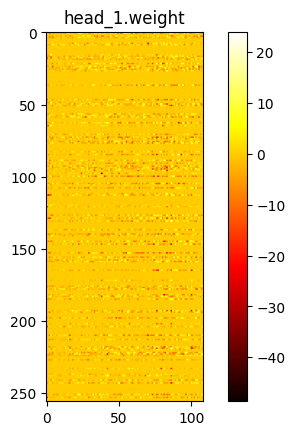

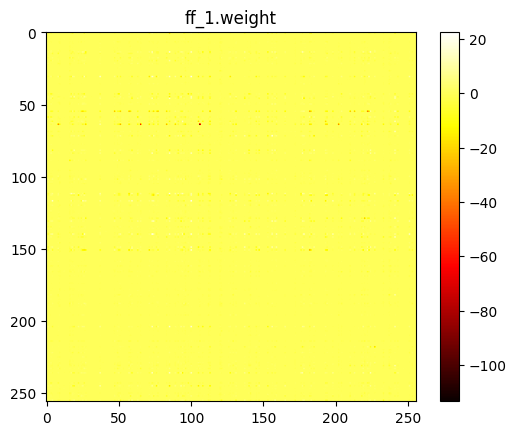

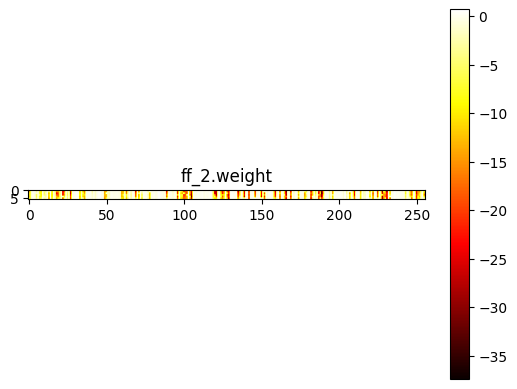

In [432]:
save_dir = '/tmp-data/zhx/DriverOrderOfflineRL/scripts/trained_models/11-22-CQL-DDQN/11-22-CQL-DDQN490.pth'
# 加载模型
model = torch.load(save_dir, map_location=torch.device('cpu'))

# 可视化权重
for name, tensor in model.items():
    if 'bias' in name:
        continue
    plt.figure()
    plt.title(name)
    plt.imshow(tensor.numpy(), cmap='hot')
    plt.colorbar()
    plt.show()

In [104]:
print(current_dir)

/tmp-data/zhx/DriverOrderOfflineRL/scripts


## agent

In [353]:
import sys
sys.path.append('/tmp-data/yanhaoyue/workspace/RL/CQL/CQL-DQN')

In [354]:
from agent import CQLAgent

In [355]:
# config
parser = argparse.ArgumentParser(description='RL')
parser.add_argument("--run_name", type=str, default="CQL-DDQN", help="Run name, default: CQL-DQN")
parser.add_argument("--env", type=str, default="order_filter", help="env name")
parser.add_argument("--episodes", type=int, default=400, help="Number of episodes, default: 200")
parser.add_argument("--buffer_size", type=int, default=100_000, help="Maximal training dataset size, default: 100_000")
parser.add_argument("--seed", type=int, default=1, help="Seed, default: 1")
parser.add_argument("--min_eps", type=float, default=0.01, help="Minimal Epsilon, default: 4")
parser.add_argument("--eps_frames", type=int, default=1e4, help="Number of steps for annealing the epsilon value to the min epsilon, default: 1e5")
parser.add_argument("--log_video", type=int, default=0, help="Log agent behaviour to wanbd when set to 1, default: 0")
parser.add_argument("--save_every", type=int, default=100, help="Saves the network every x epochs, default: 25")

config = SimpleNamespace()
# args = parser.parse_args()
config.run_name = "11-9-CQL-DDQN_test"
config.env = 'order_filter'
config.episodes = 400
config.buffer_size = 1_000_000
config.seed = 1
config.min_eps = 1e-4
config.eps_frames = 1e4
config.log_video = 0
config.save_every = 1
config.eval_every = 100

## Test core

In [356]:
np.random.seed(config.seed)
random.seed(config.seed)
torch.manual_seed(config.seed)

batches = 0
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

eps = 1.
d_eps = 1 - config.min_eps
steps = 0
average10 = deque(maxlen=10)
total_steps = 0

In [253]:
agent = CQLAgent(state_size=109,
                    action_size=6,
                    device=device)

In [433]:
load(agent.network)

Model loaded successfully.
Model path:  /tmp-data/zhx/DriverOrderOfflineRL/scripts/trained_models/11-22-CQL-DDQN/11-22-CQL-DDQN490.pth


In [228]:
import pickle

# 保存DataLoader
def save_dataloader(dataloader, filename):
    with open(filename, 'wb') as f:
        pickle.dump(dataloader, f)

# 加载DataLoader
def load_dataloader(filename):
    with open(filename, 'rb') as f:
        dataloader = pickle.load(f)
    return dataloader

In [256]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, buffer_size, batch_size, device):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.device = device
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def add_batch(self, states, actions, rewards, next_states, dones):
        """Add a batch of experiences to memory."""
        for i in range(len(states)):
            self.add(states[i], actions[i], rewards[i], next_states[i], dones[i])
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.stack([e.state for e in experiences if e is not None])).float().to(self.device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(self.device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(self.device)
        next_states = torch.from_numpy(np.stack([e.next_state for e in experiences if e is not None])).float().to(self.device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(self.device)
  
        return (states, actions, rewards, next_states, dones)
    
    def create_dataloader(self):
        """Create a DataLoader from the replay buffer."""
        states = torch.tensor([e.state for e in self.memory], dtype=torch.float32, device=self.device)
        actions = torch.tensor([e.action for e in self.memory], dtype=torch.long, device=self.device)
        rewards = torch.tensor([e.reward for e in self.memory], dtype=torch.float32, device=self.device)
        next_states = torch.tensor([e.next_state for e in self.memory], dtype=torch.float32, device=self.device)
        dones = torch.tensor([e.done for e in self.memory], dtype=torch.long, device=self.device)

        dataset = TensorDataset(states, actions.unsqueeze(1), rewards.unsqueeze(1), next_states, dones.unsqueeze(1))
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        return dataloader

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)


In [400]:
dataloader = load_dataloader('support_feature_ddqn.pkl')
# dataloader = load_dataloader('feature11_ddqn.pkl')

In [391]:
def getQ(agent, state):
    state = torch.from_numpy(state).float().unsqueeze(0)
    action_value = agent.network(state)
    if action_value.data[0].argmax().item() == 0 or True:
        pd.Series(action_value.data[0]).plot()
        plt.title(action_value.data[0].argmax().item())
        plt.show()

target act 2


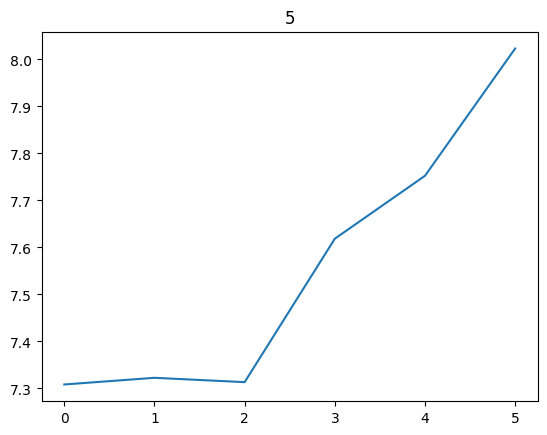

target act 4


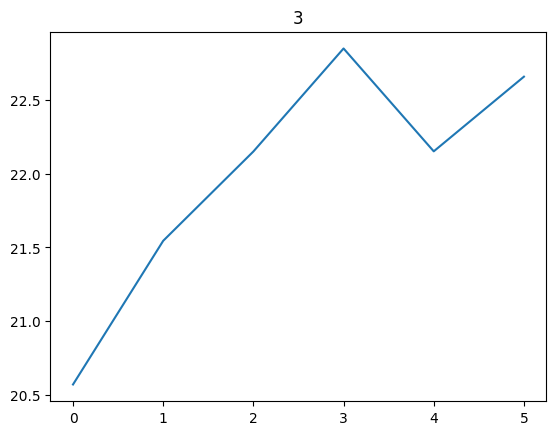

target act 5


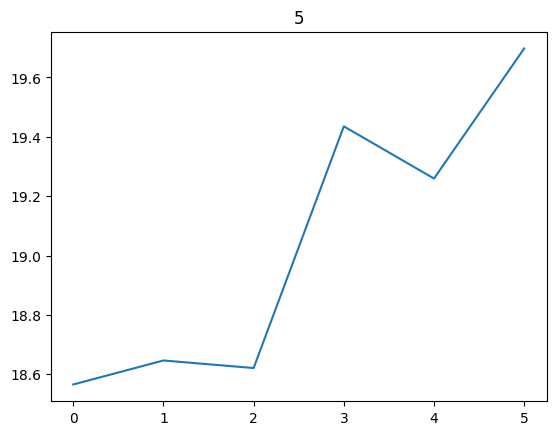

target act 4


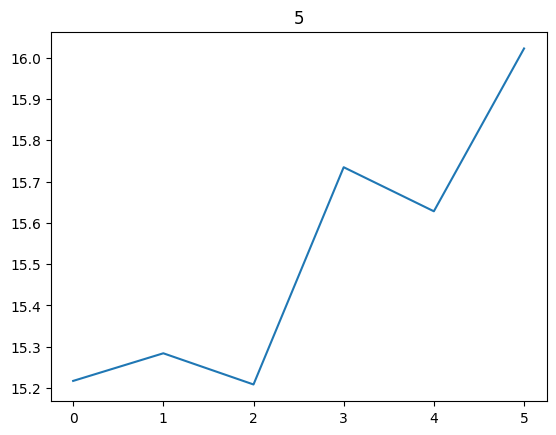

target act 5


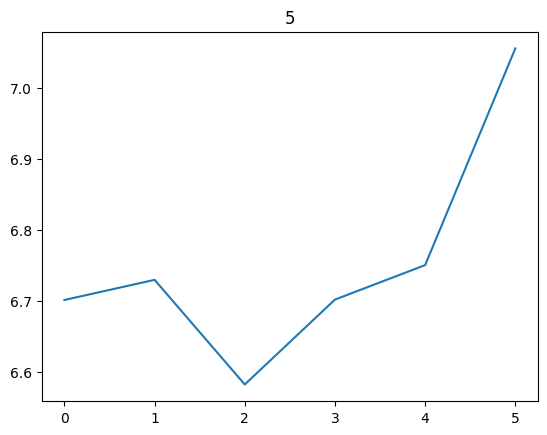

target act 3


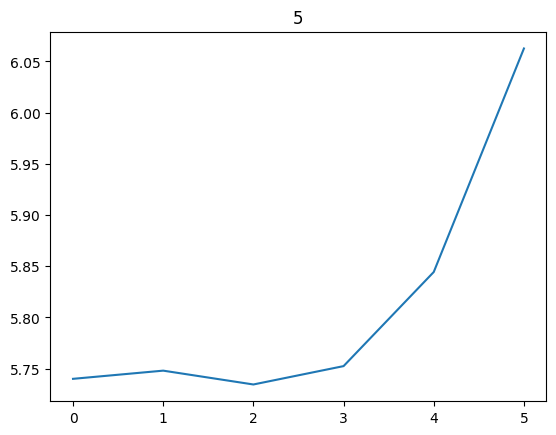

target act 5


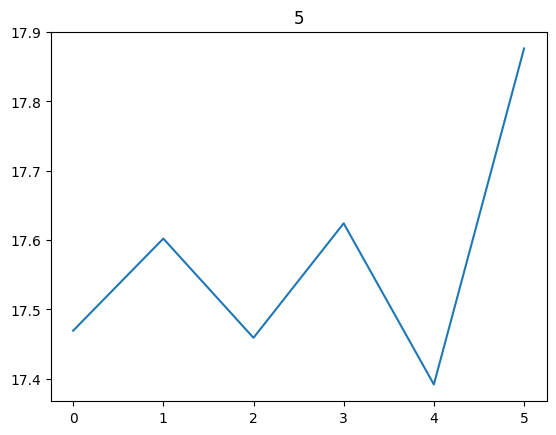

target act 4


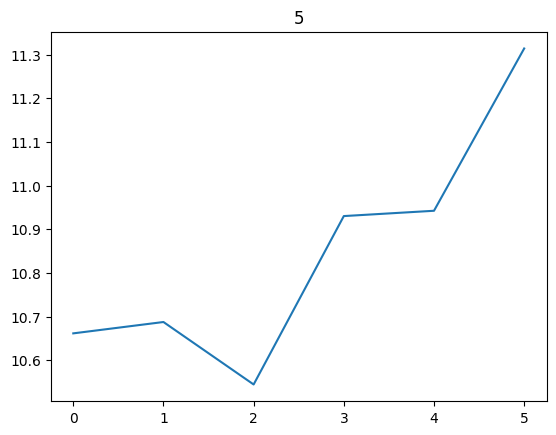

target act 5


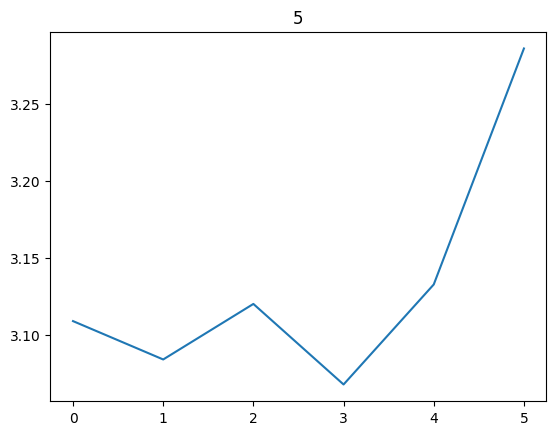

target act 2


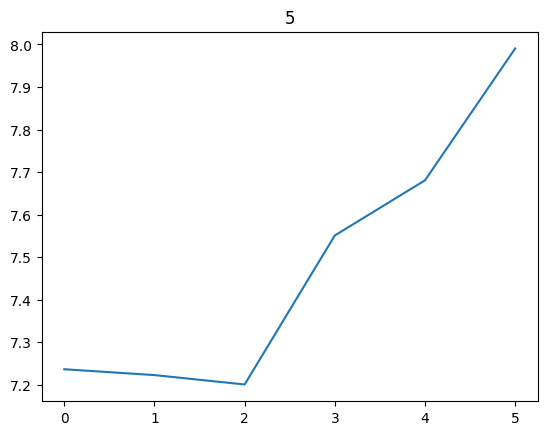

target act 5


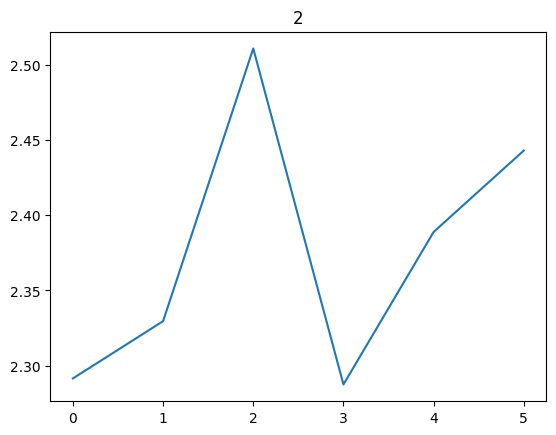

target act 0


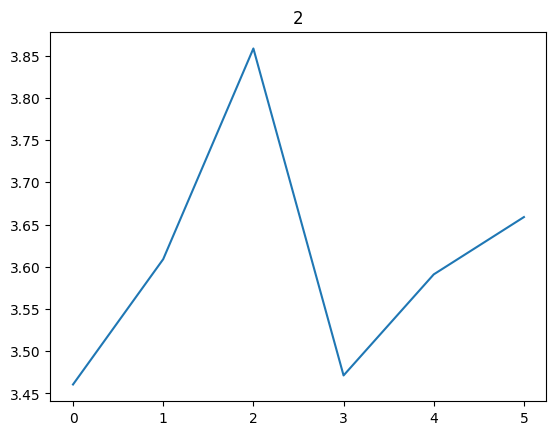

target act 1


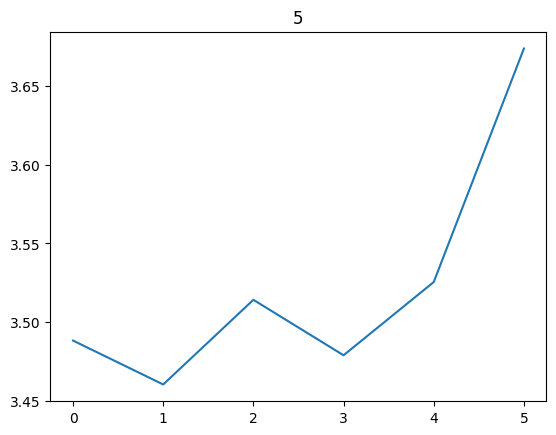

target act 2


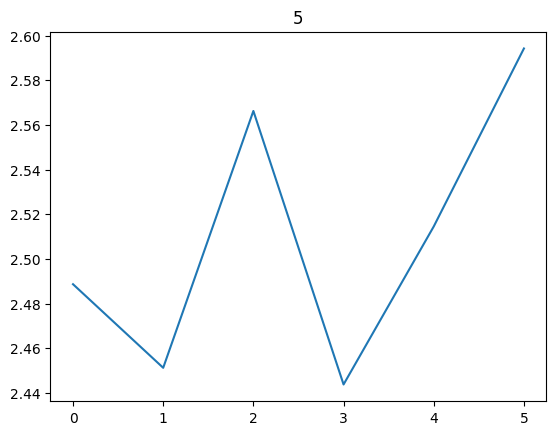

target act 0


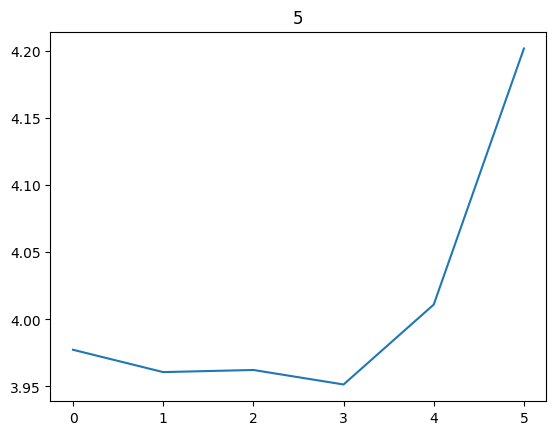

target act 4


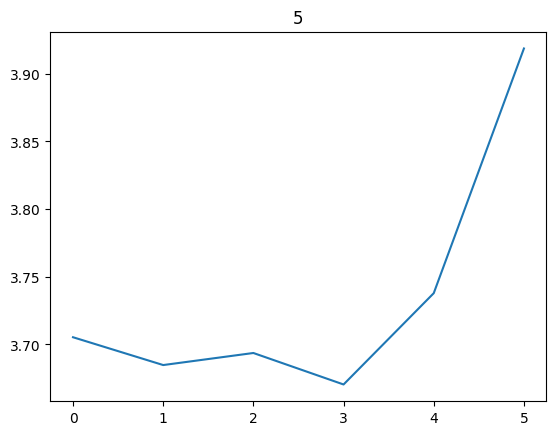

target act 5


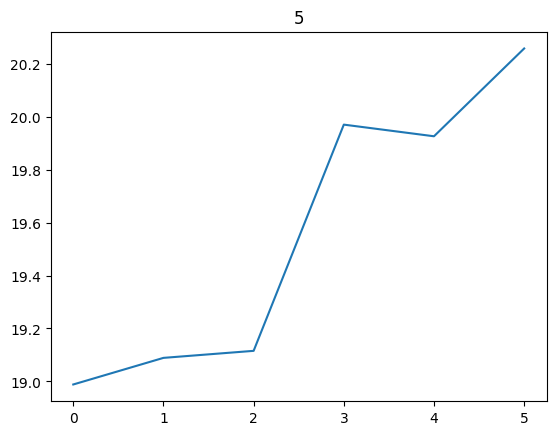

target act 5


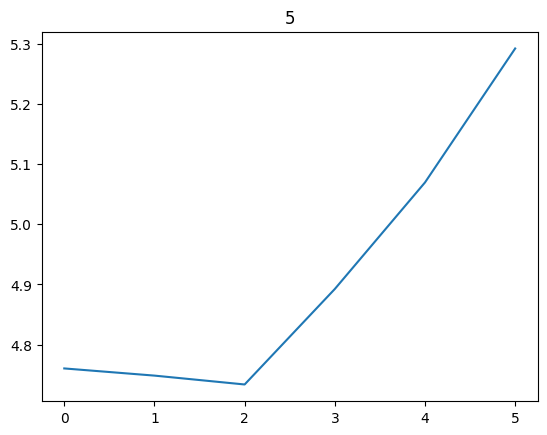

target act 5


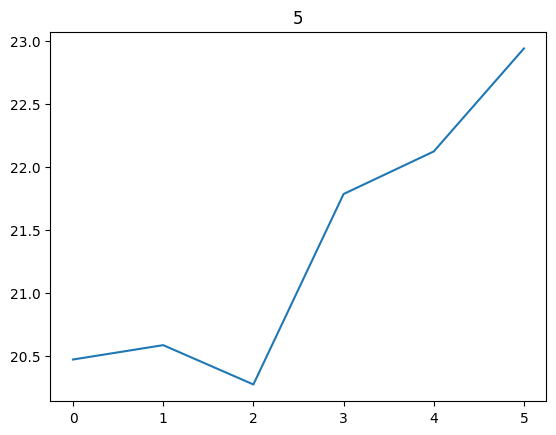

target act 2


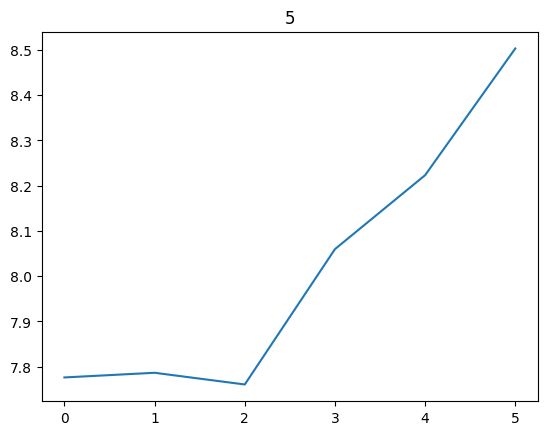

target act 5


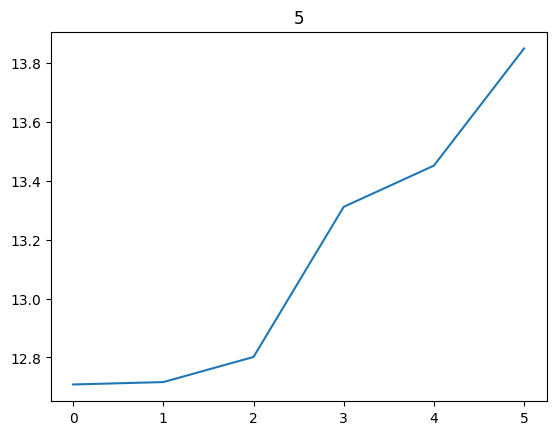

target act 0


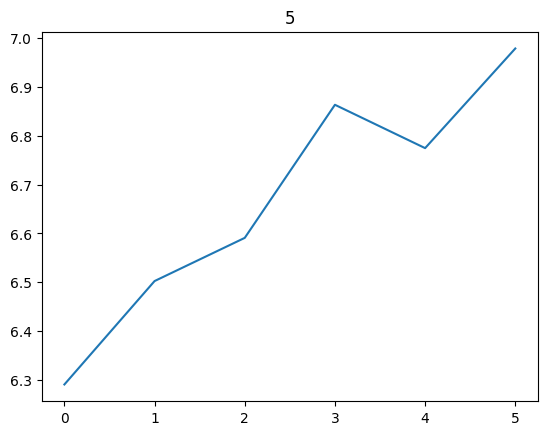

target act 3


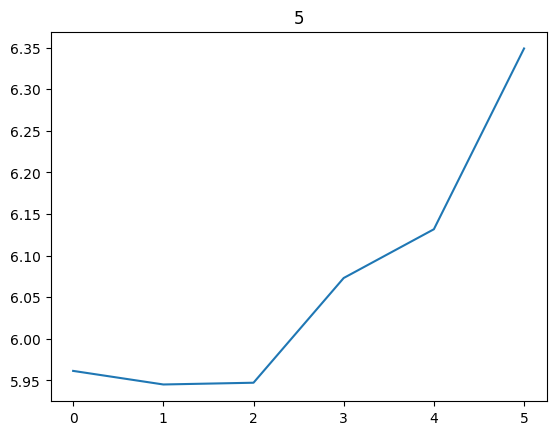

target act 2


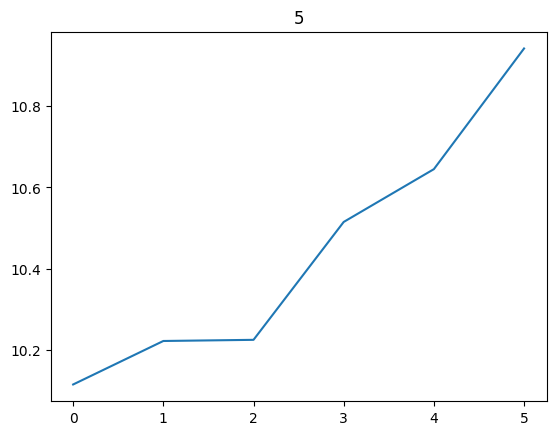

target act 1


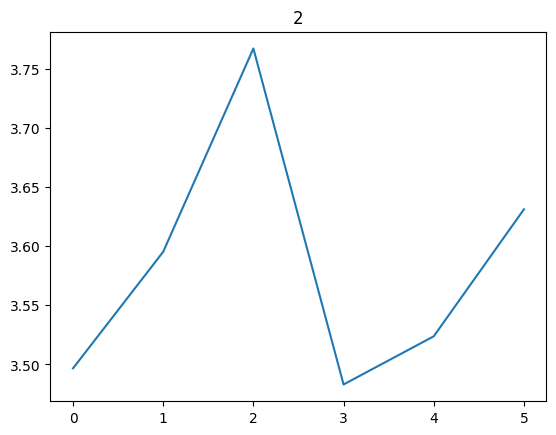

target act 5


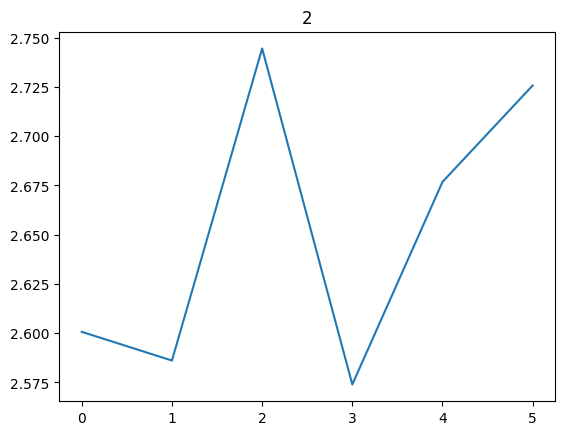

target act 2


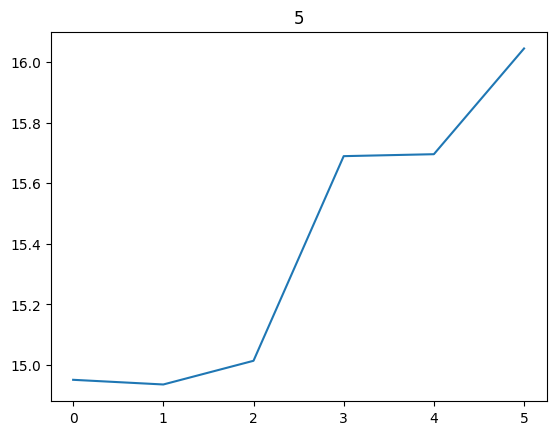

target act 5


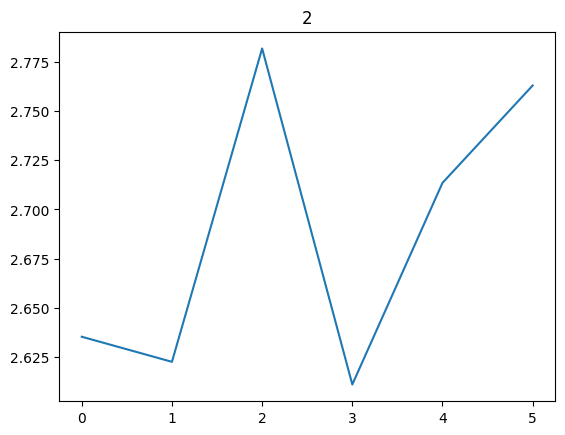

target act 3


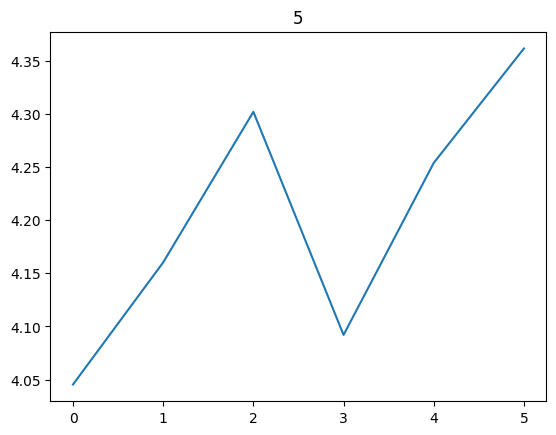

target act 5


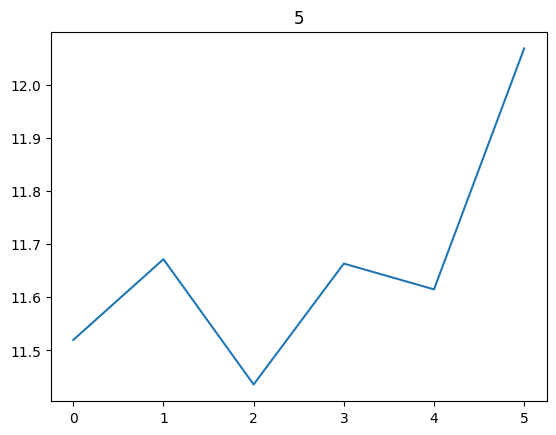

target act 5


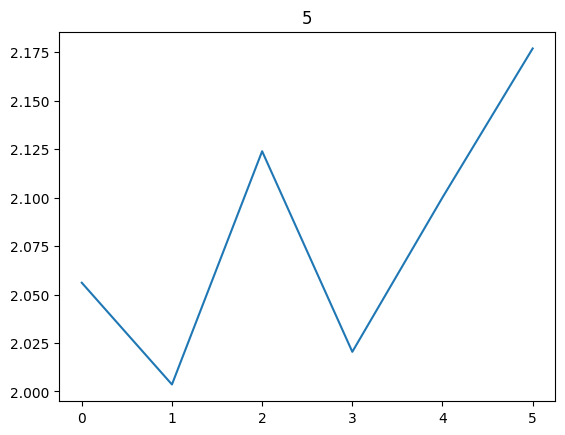

target act 0


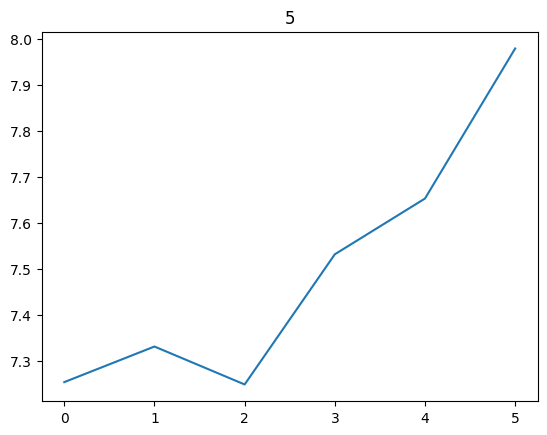

target act 3


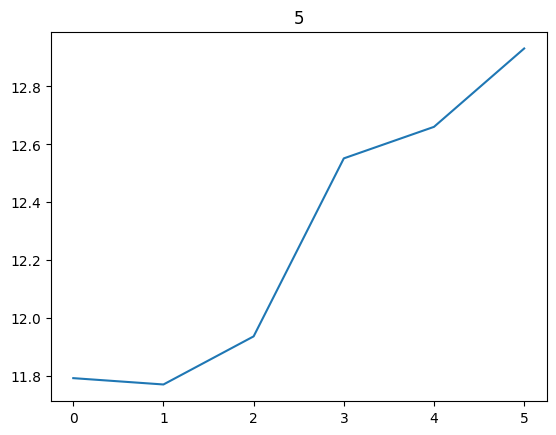

target act 5


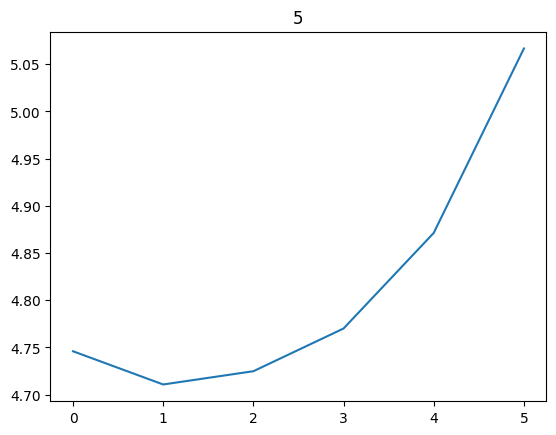

target act 2


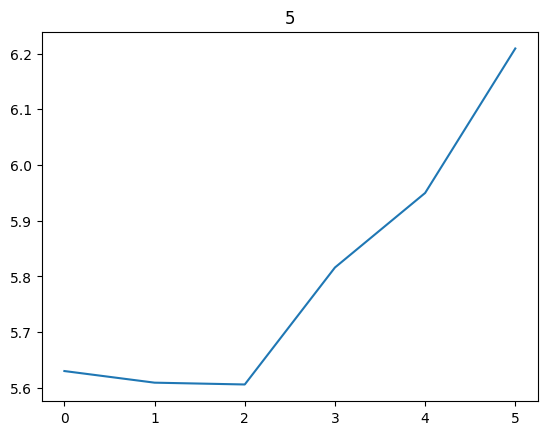

target act 0


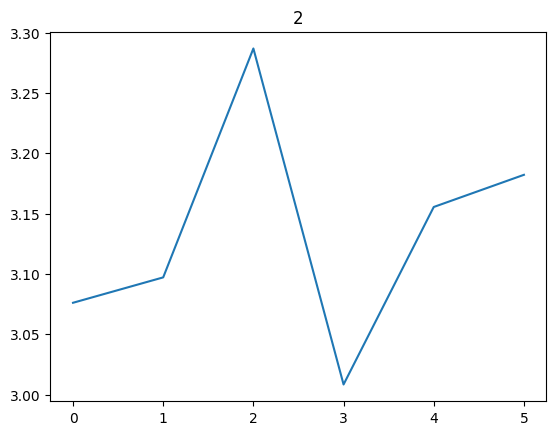

target act 5


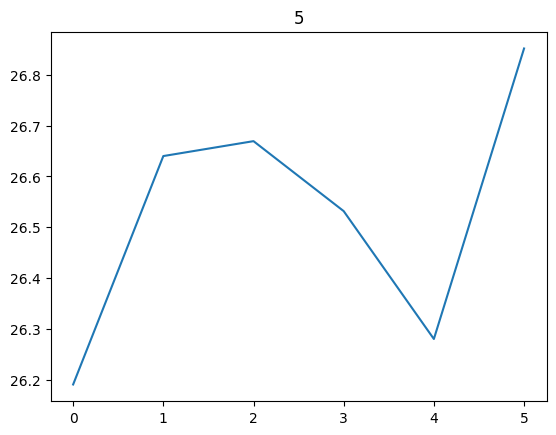

target act 2


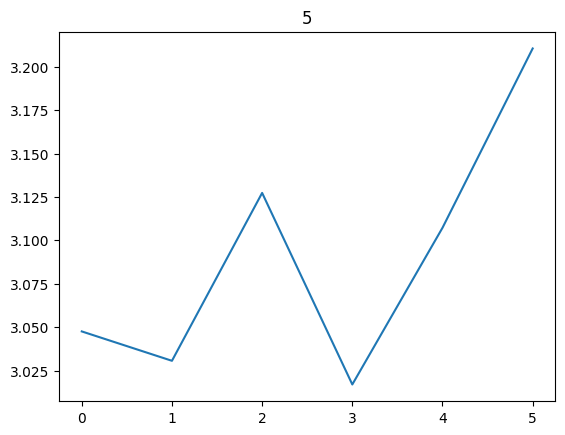

target act 4


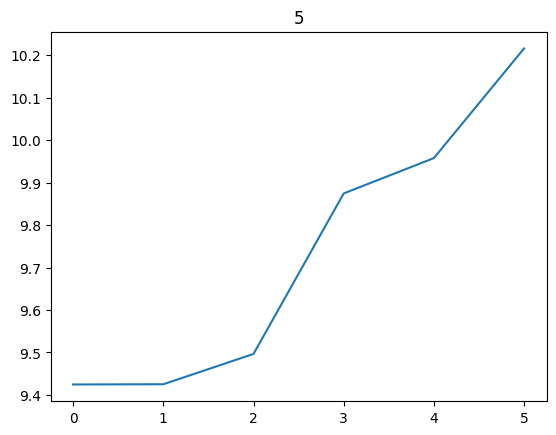

target act 2


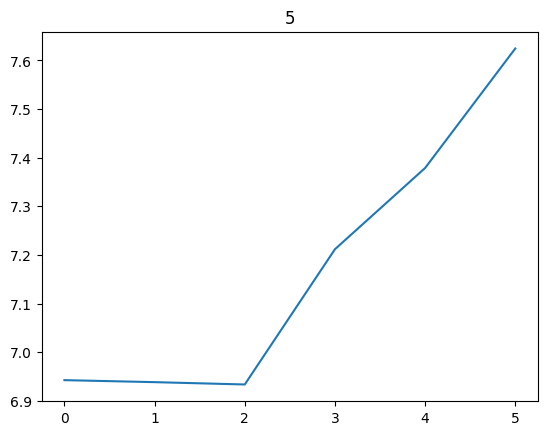

target act 2


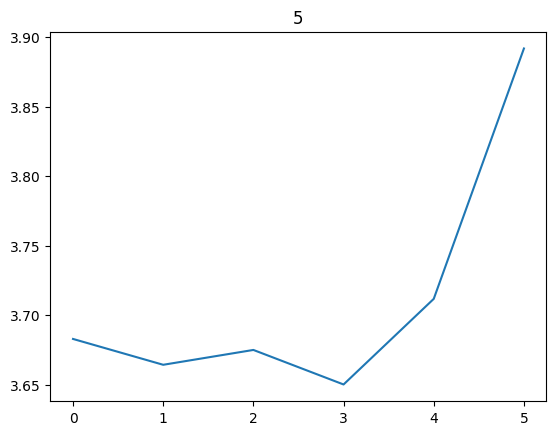

target act 5


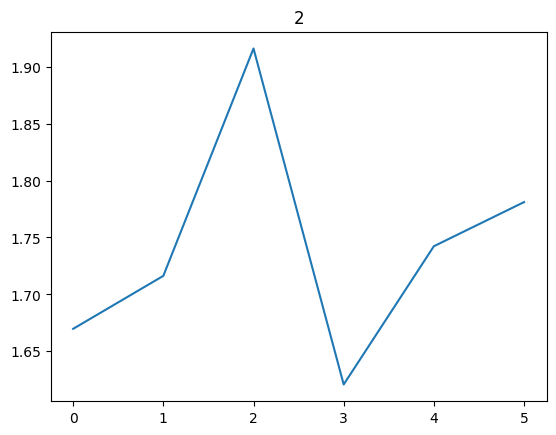

target act 3


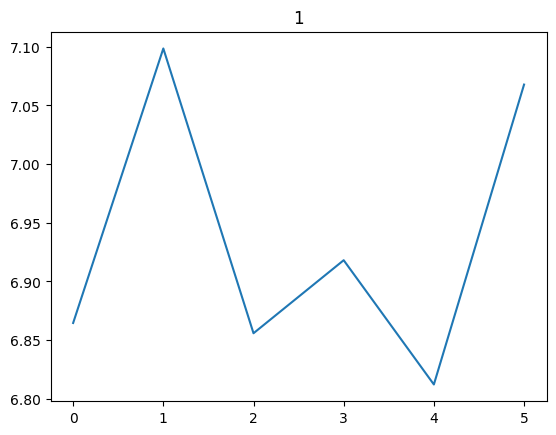

target act 2


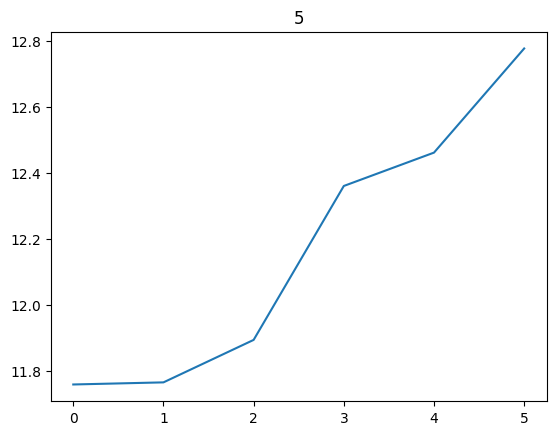

target act 2


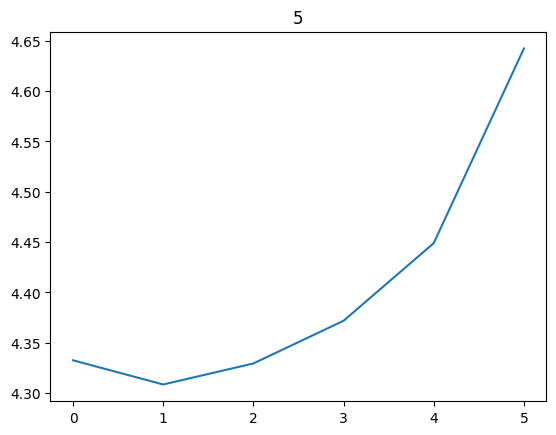

target act 4


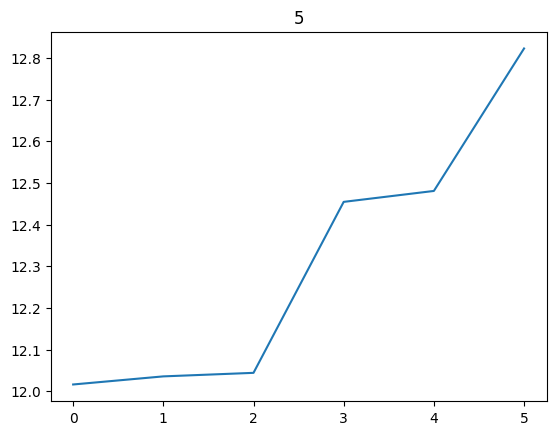

target act 5


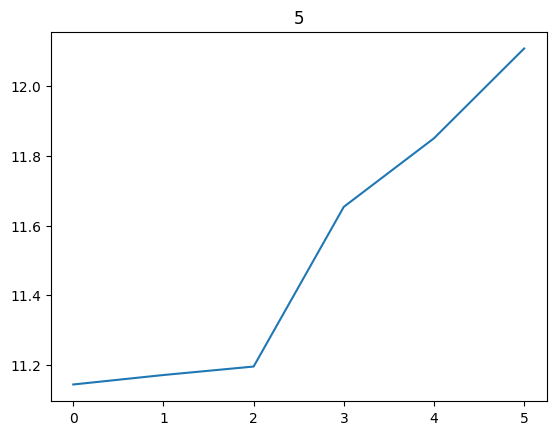

target act 1


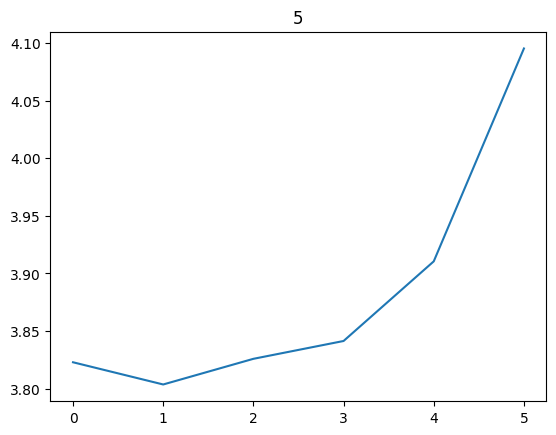

target act 5


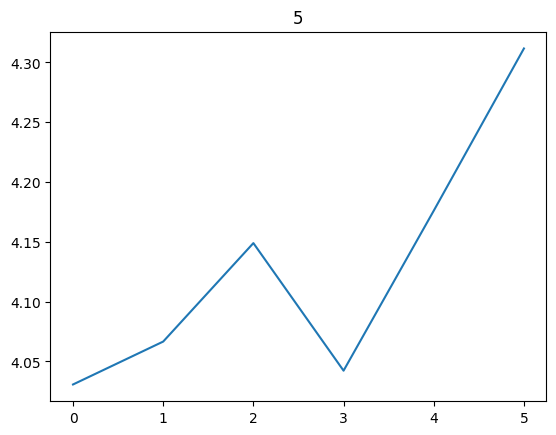

target act 3


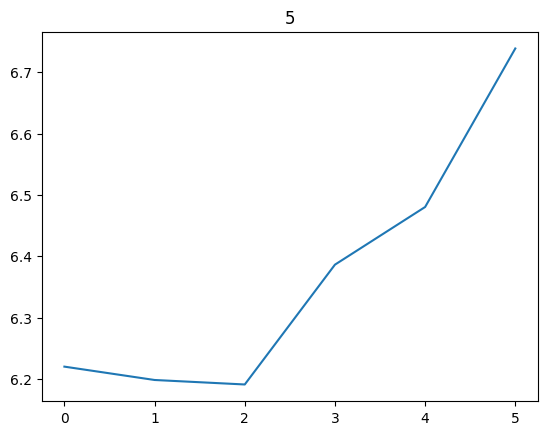

target act 1


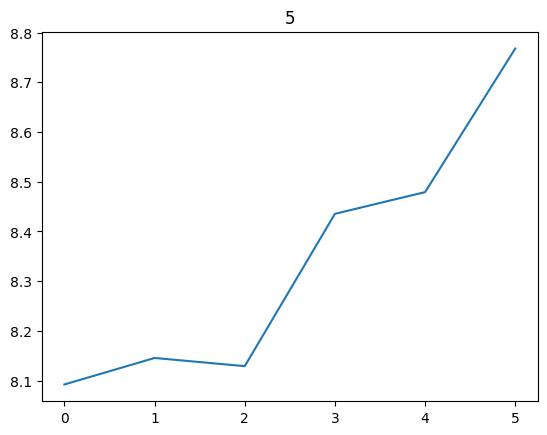

target act 2


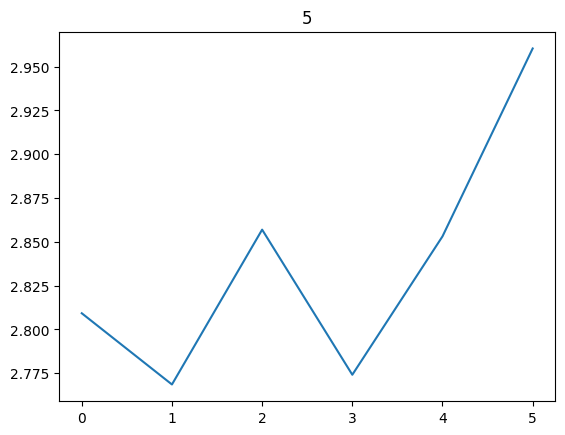

target act 2


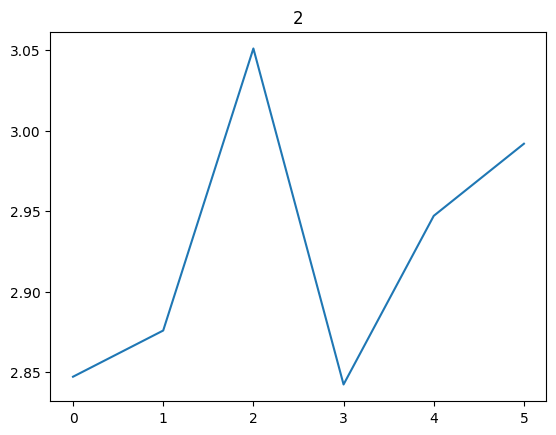

target act 3


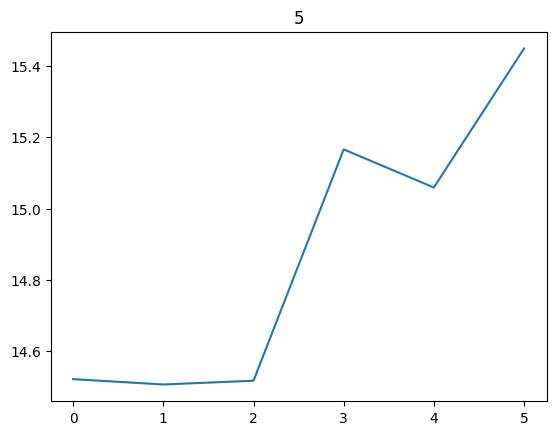

target act 4


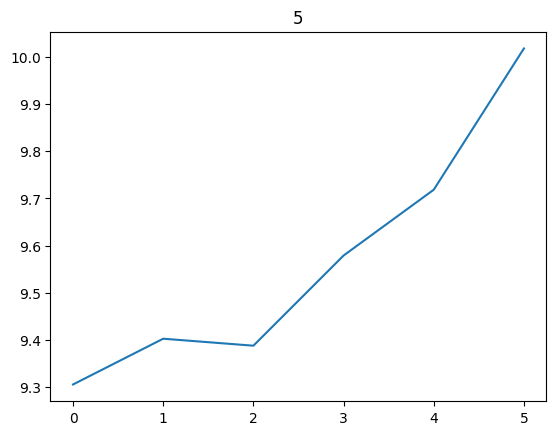

target act 0


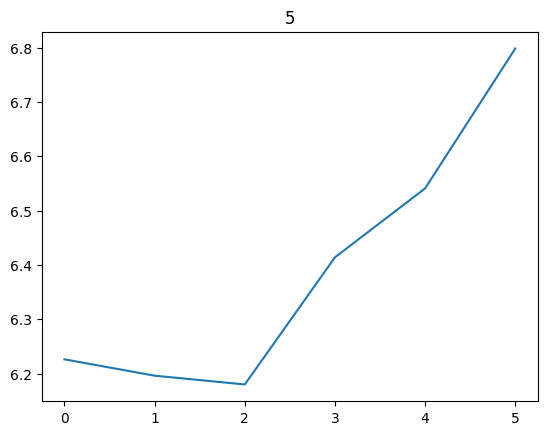

target act 5


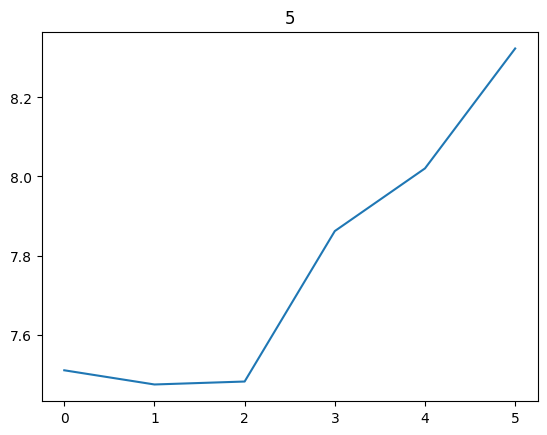

target act 5


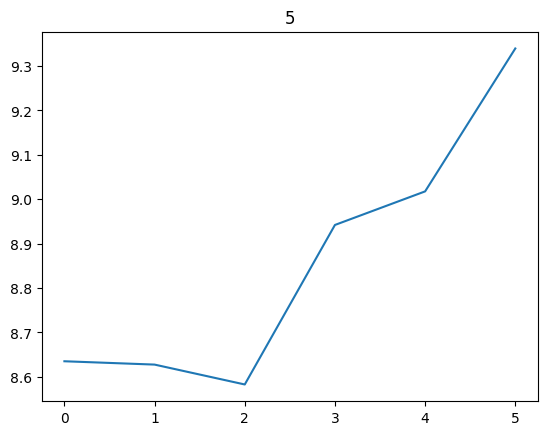

target act 0


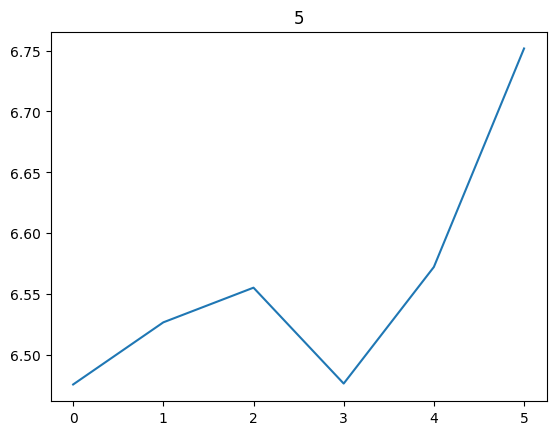

target act 4


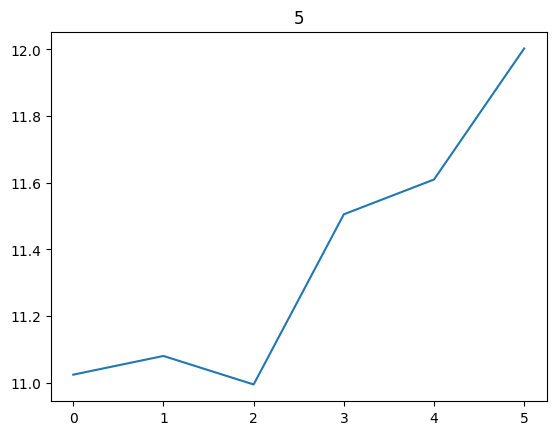

target act 2


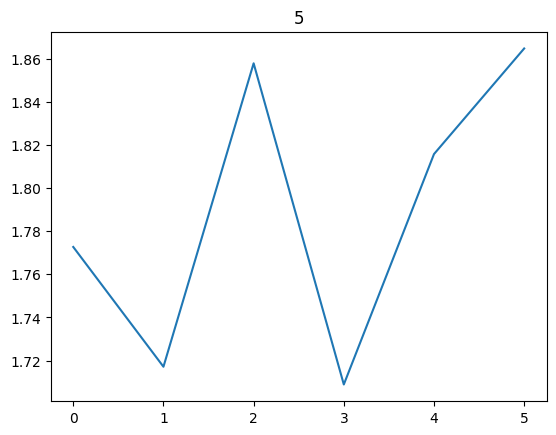

target act 4


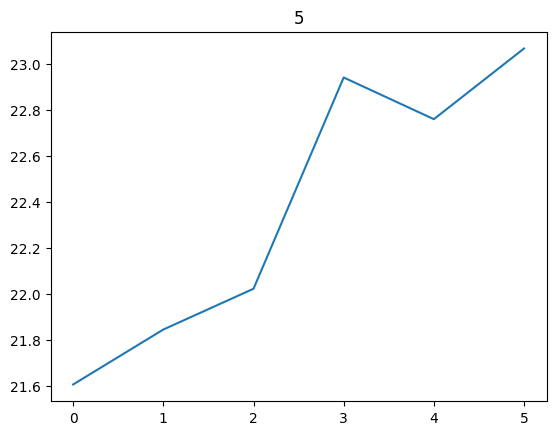

target act 3


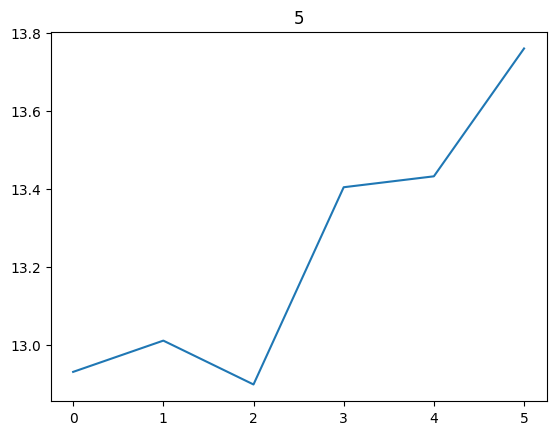

target act 2


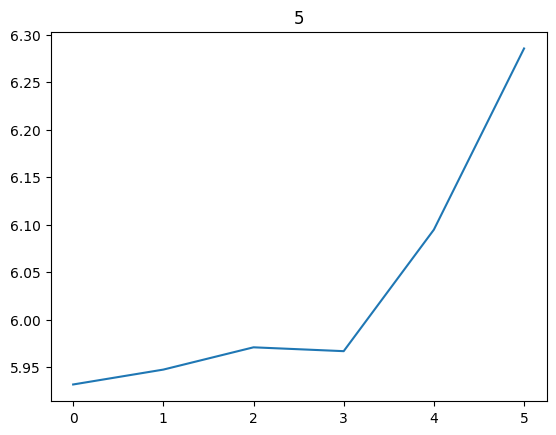

target act 4


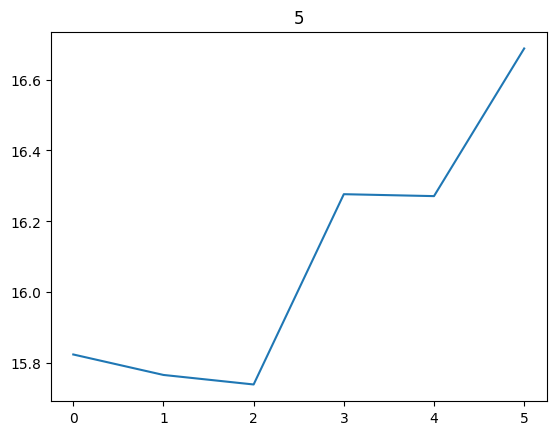

target act 5


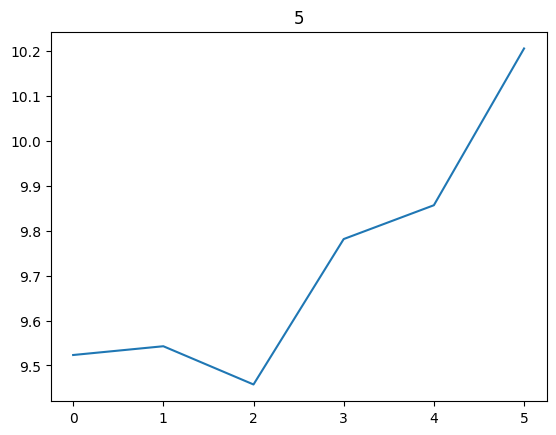

target act 5


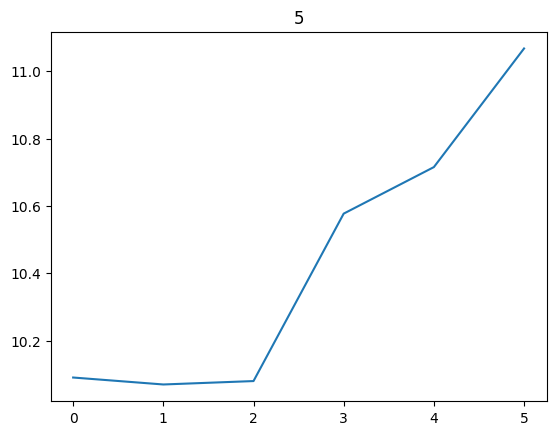

target act 5


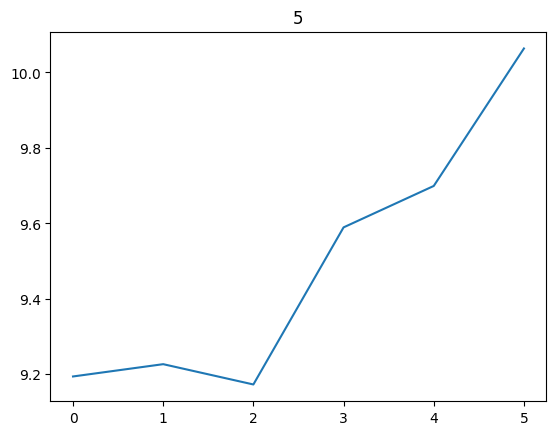

target act 3


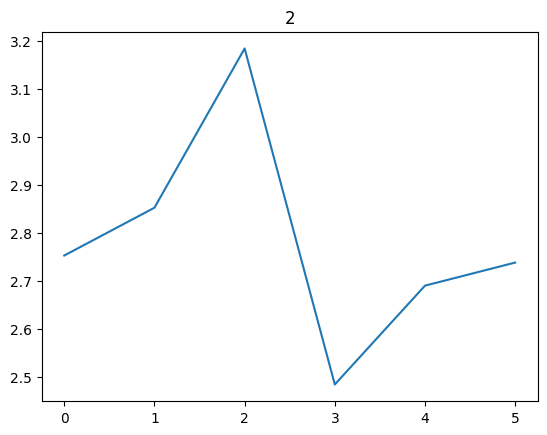

target act 4


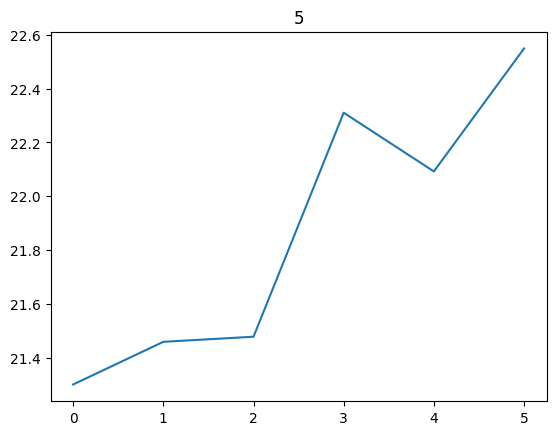

target act 4


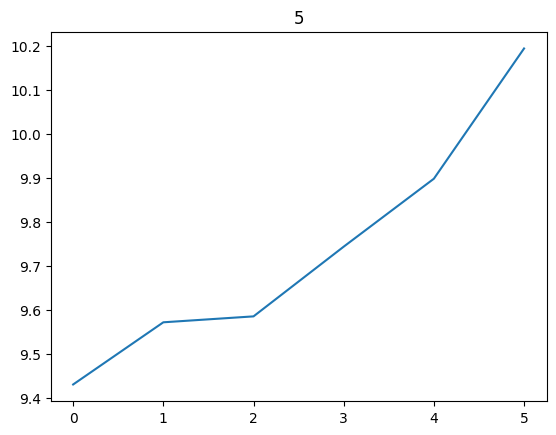

target act 5


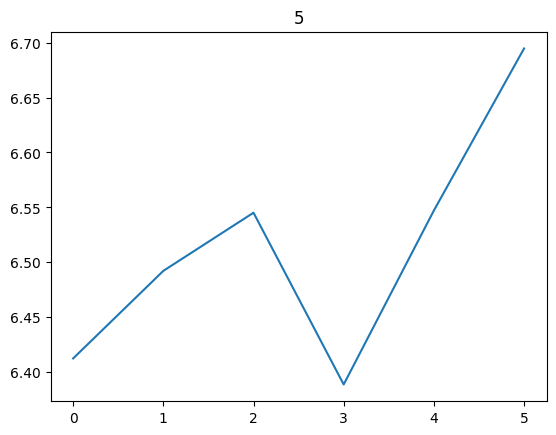

target act 4


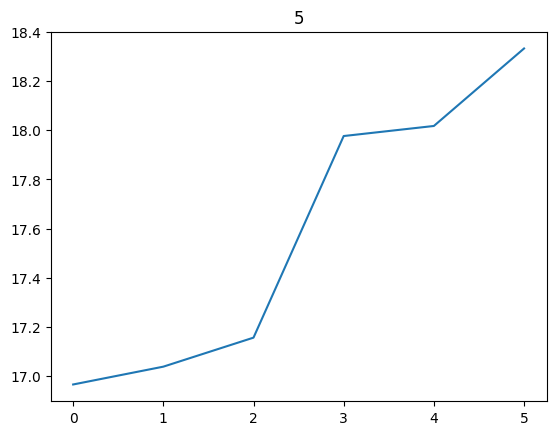

target act 2


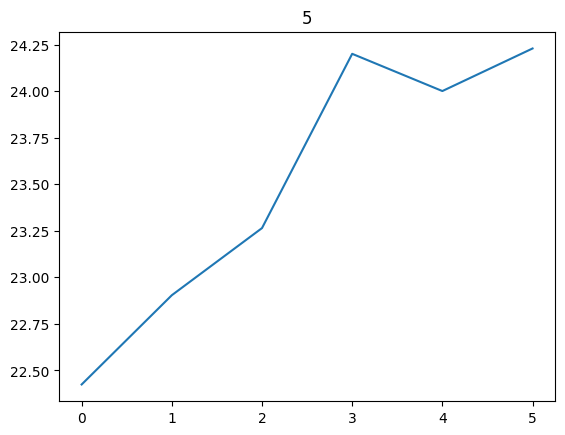

target act 5


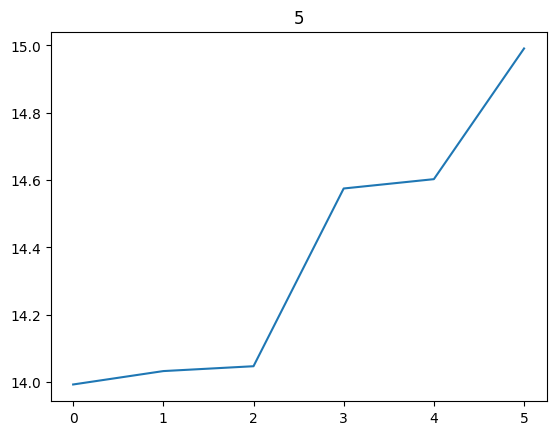

target act 1


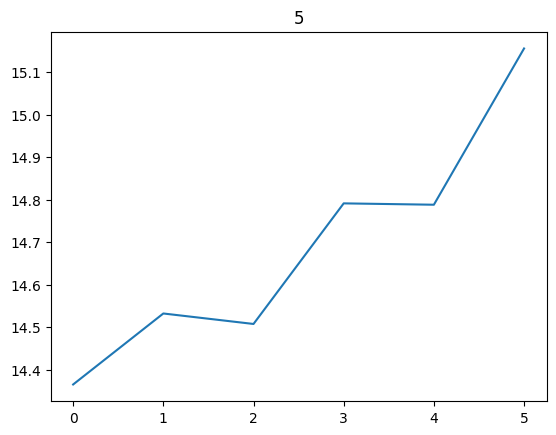

target act 2


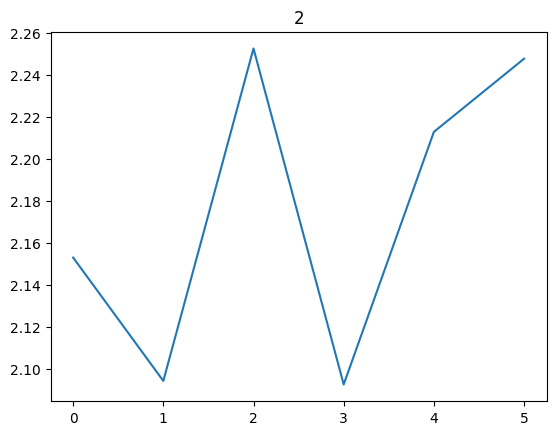

target act 4


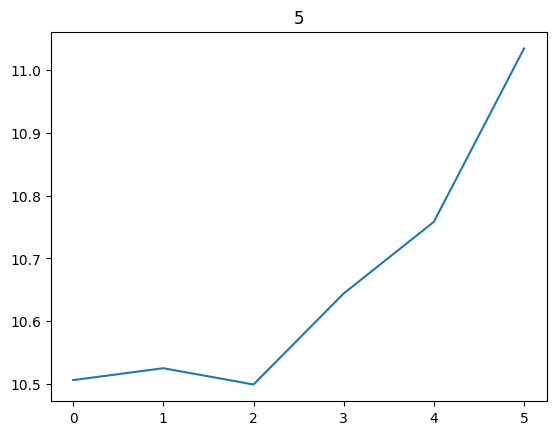

target act 1


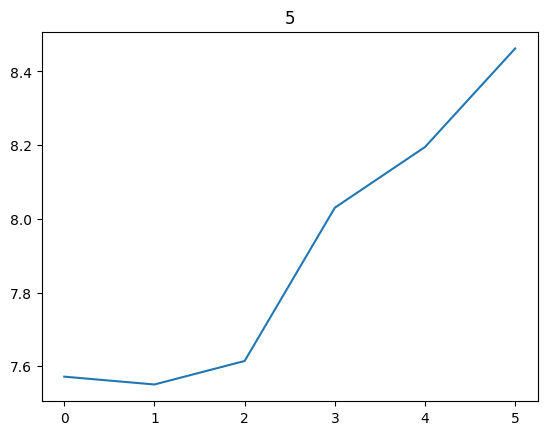

target act 5


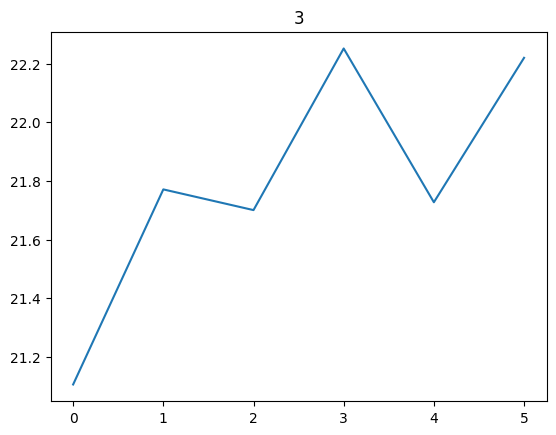

target act 4


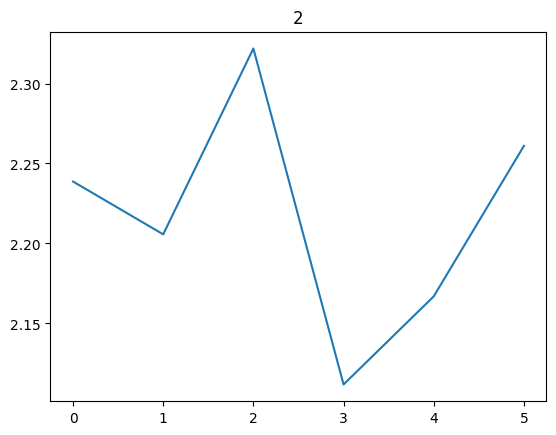

target act 5


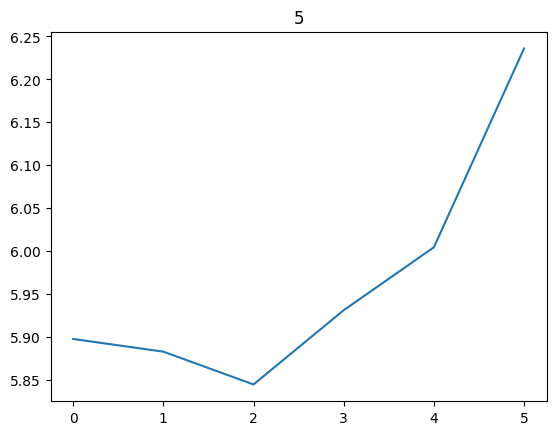

target act 3


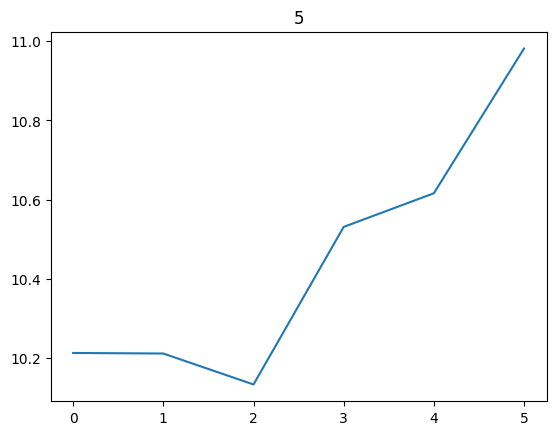

target act 4


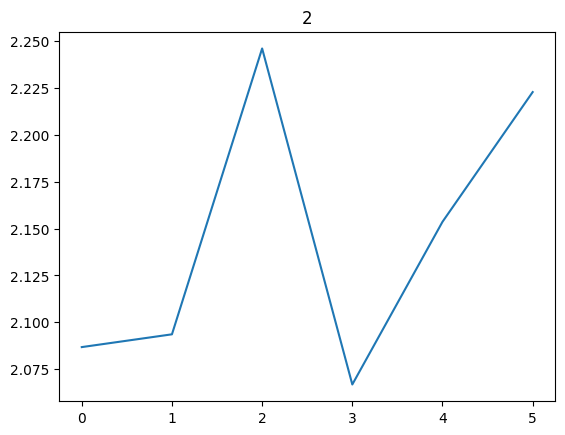

target act 2


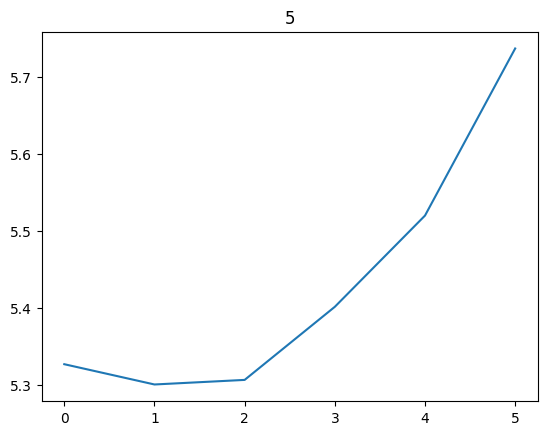

target act 3


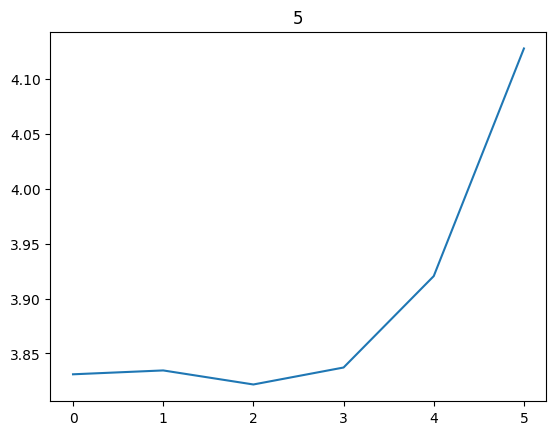

target act 1


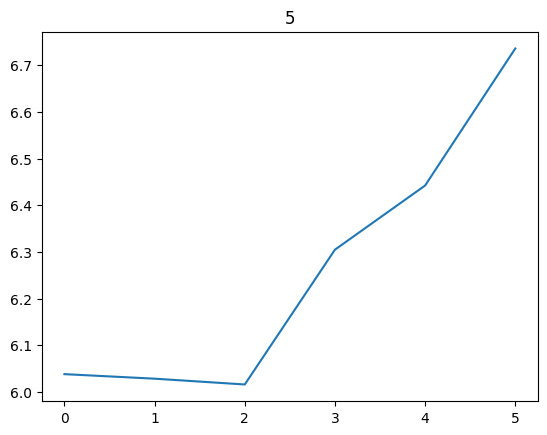

target act 2


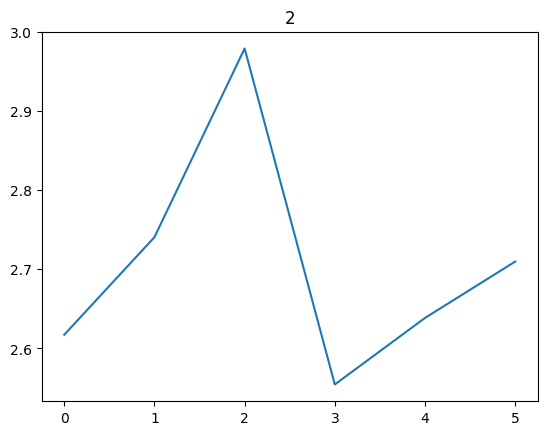

target act 3


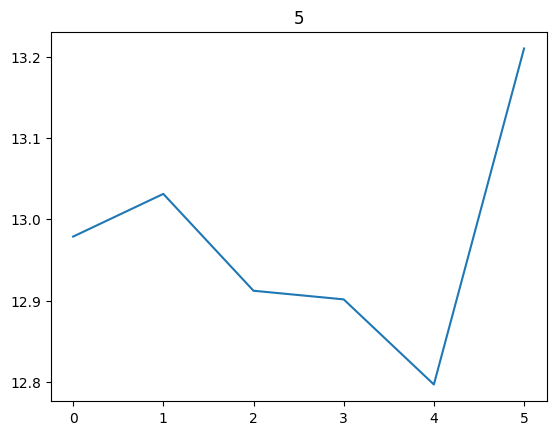

target act 1


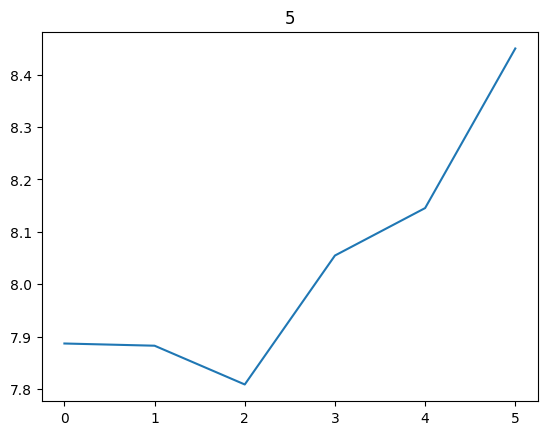

target act 0


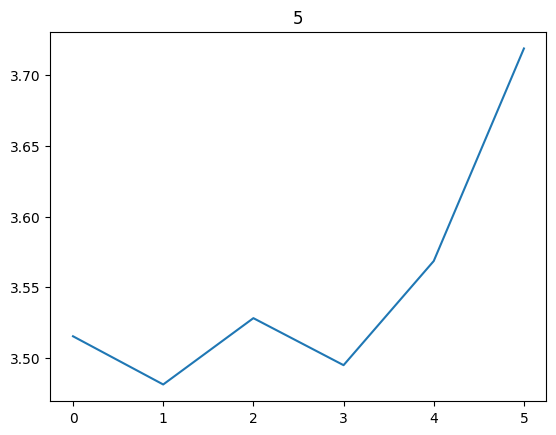

target act 5


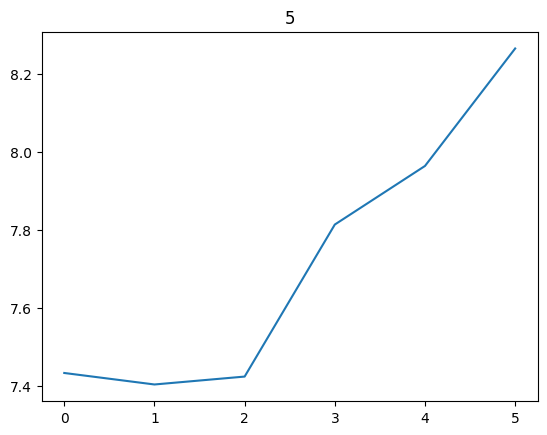

target act 3


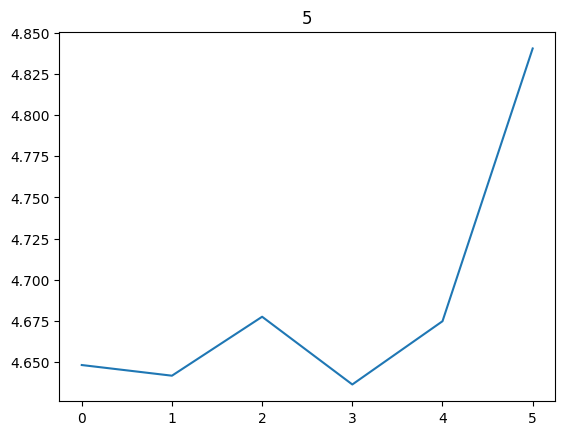

target act 5


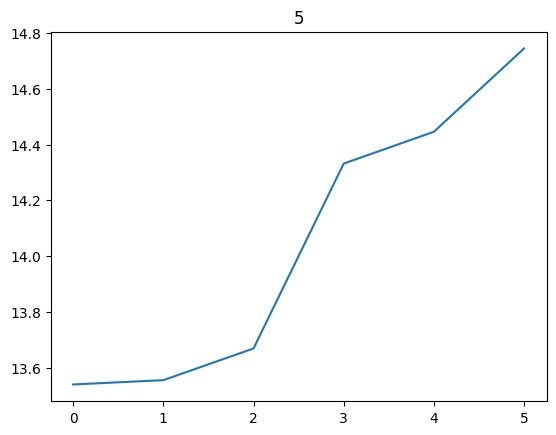

target act 4


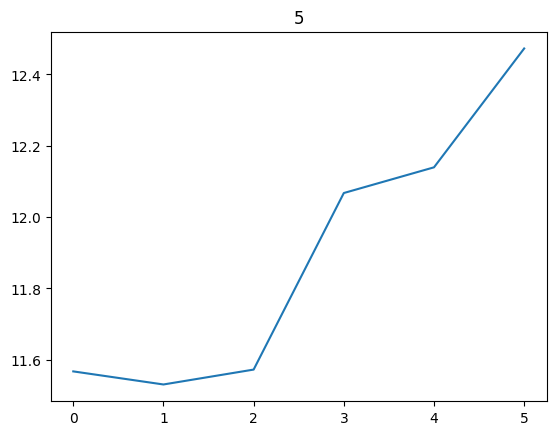

target act 5


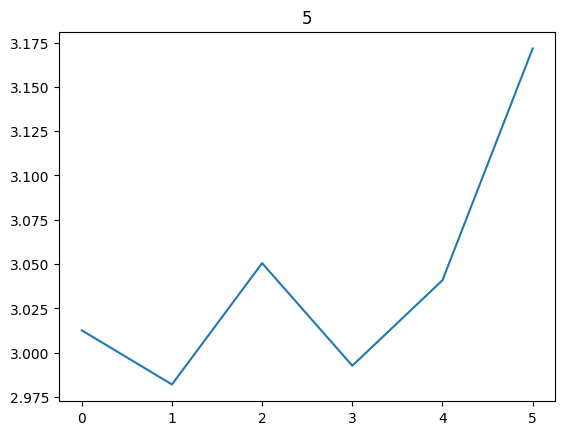

target act 0


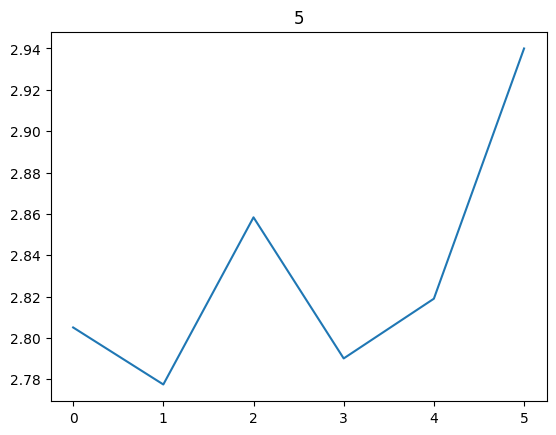

target act 4


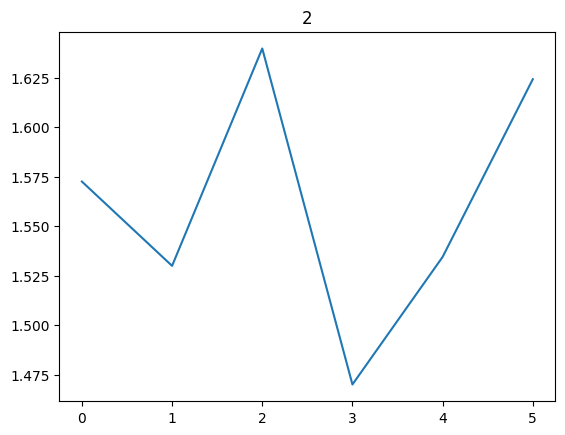

target act 4


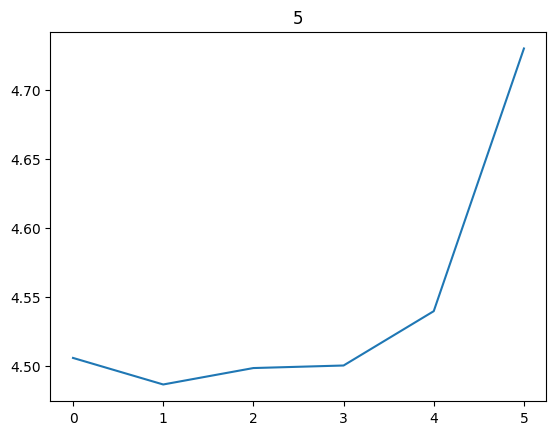

target act 2


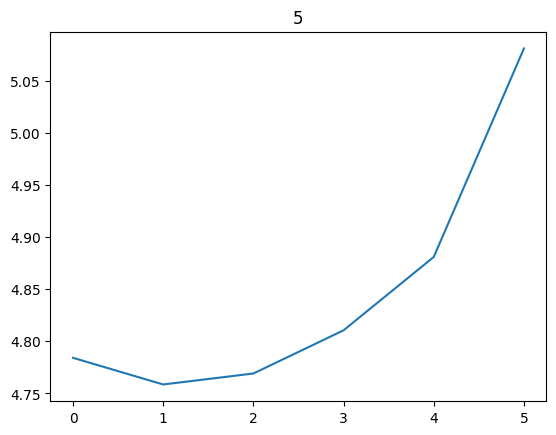

target act 3


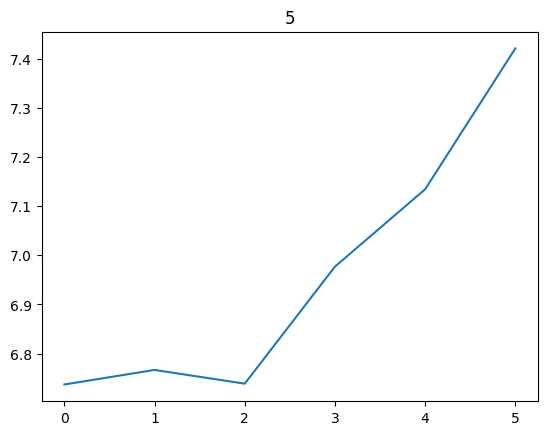

target act 0


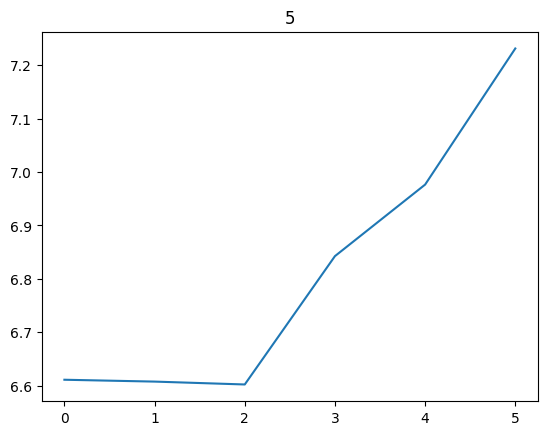

target act 0


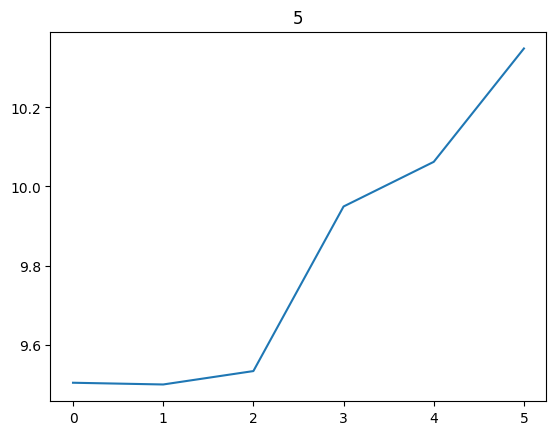

target act 1


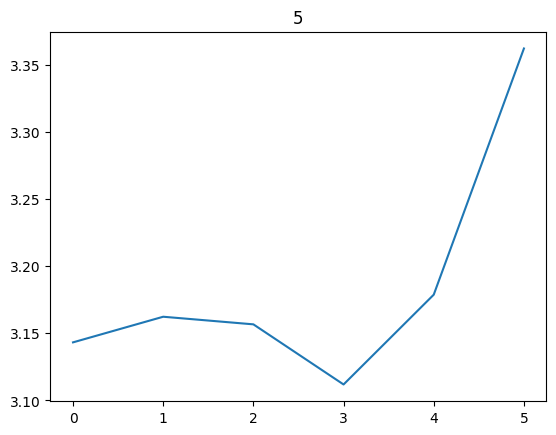

target act 1


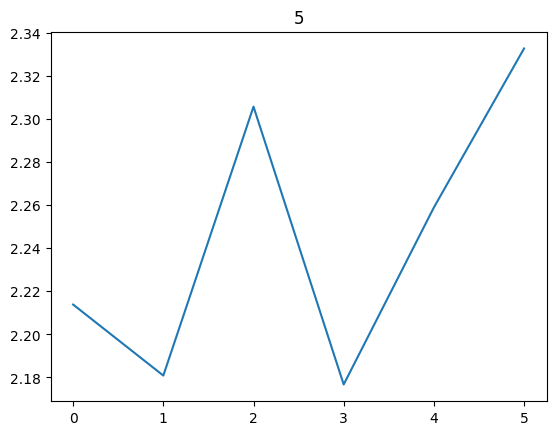

target act 5


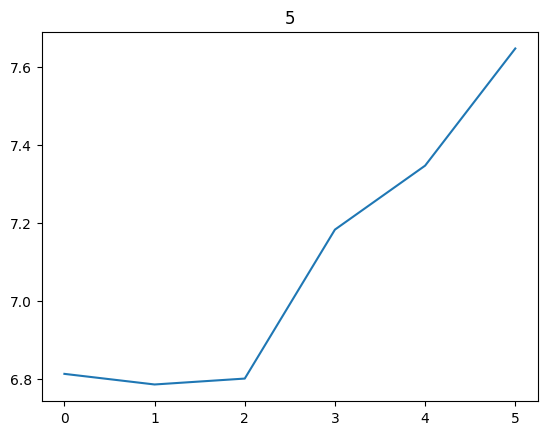

target act 3


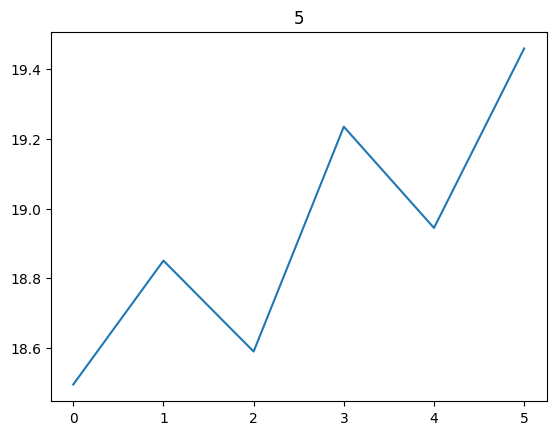

target act 4


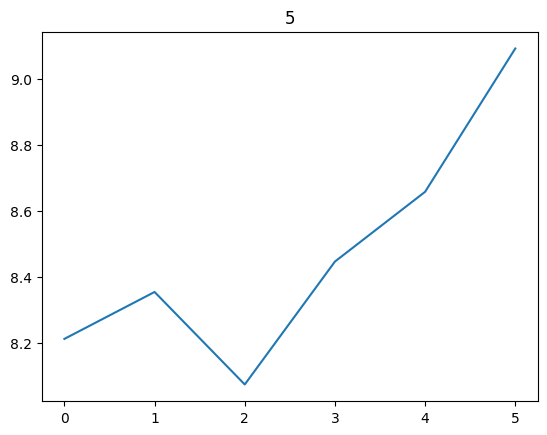

target act 4


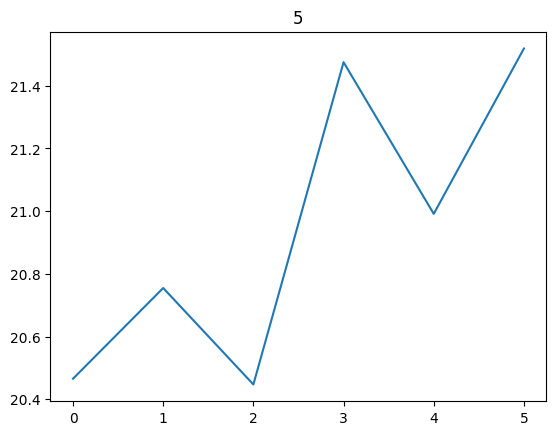

target act 4


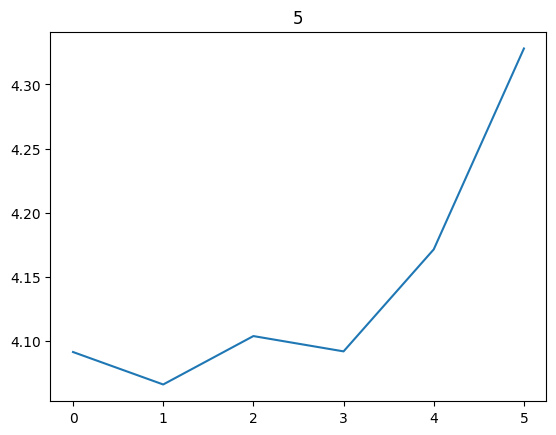

target act 0


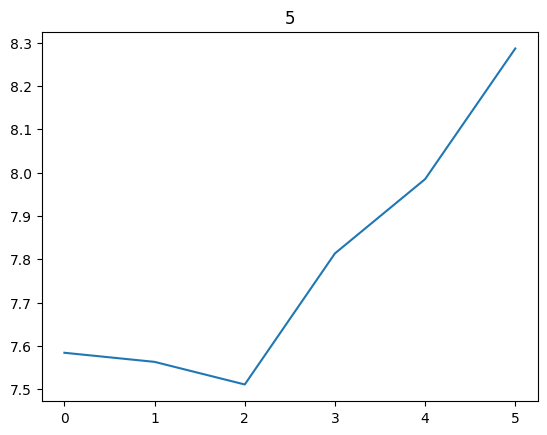

target act 0


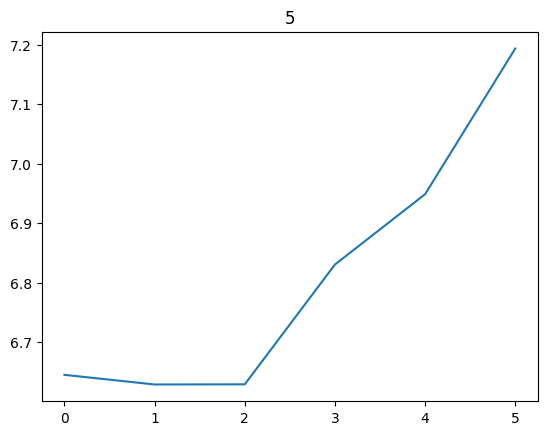

target act 1


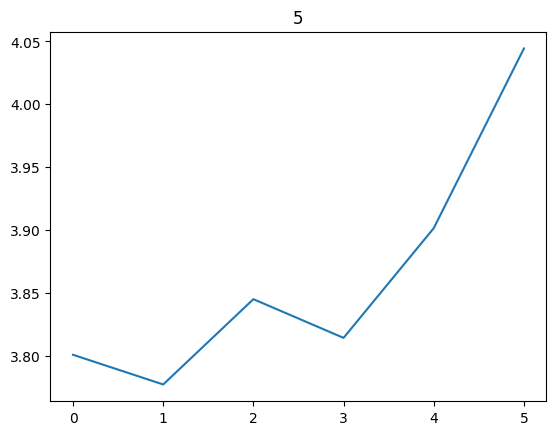

target act 2


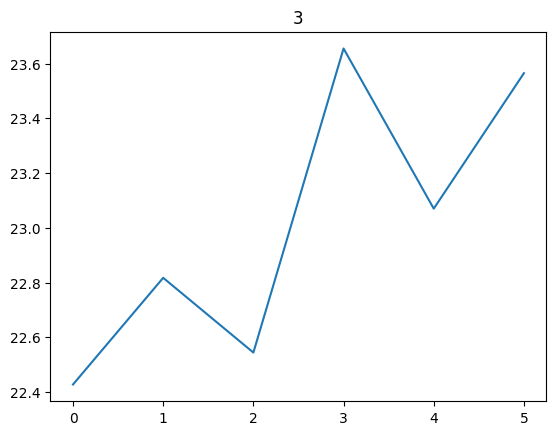

target act 4


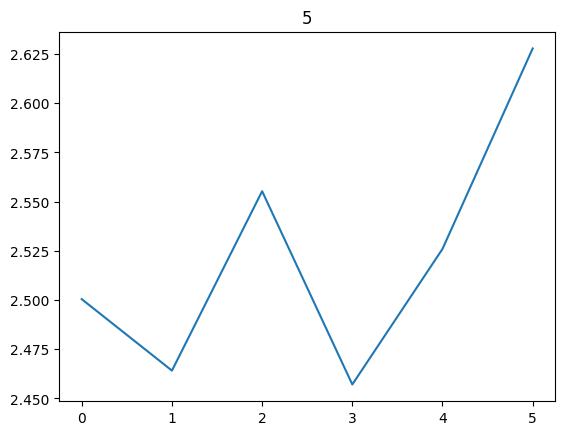

target act 1


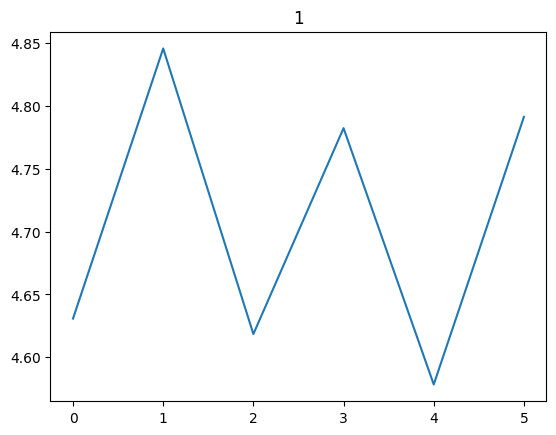

target act 3


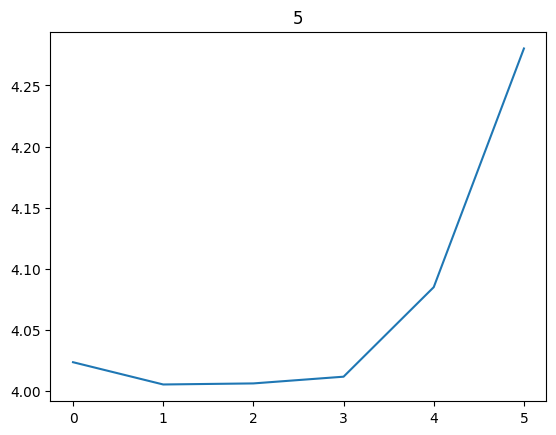

target act 5


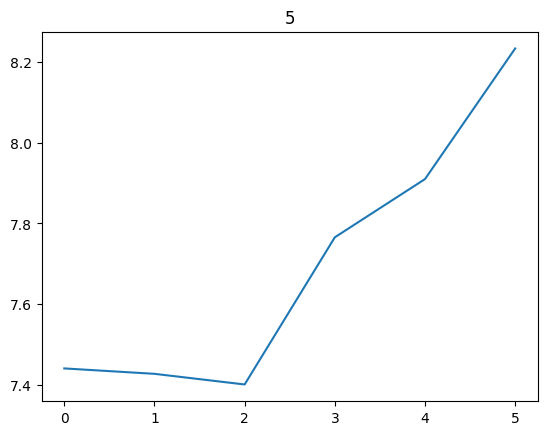

target act 5


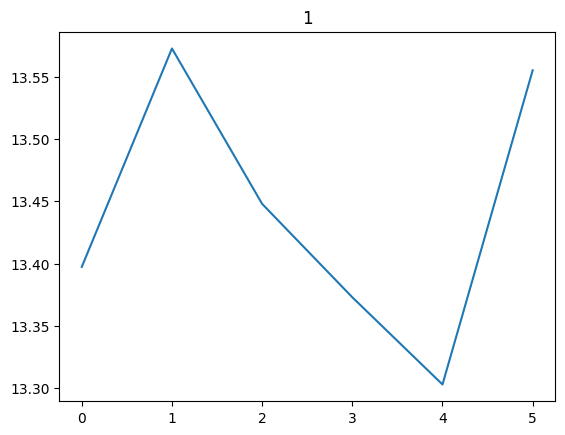

target act 1


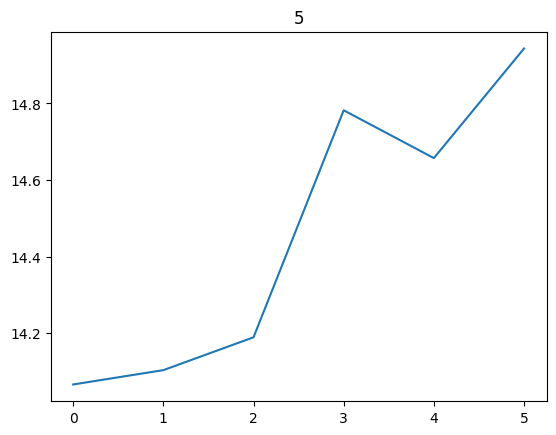

target act 4


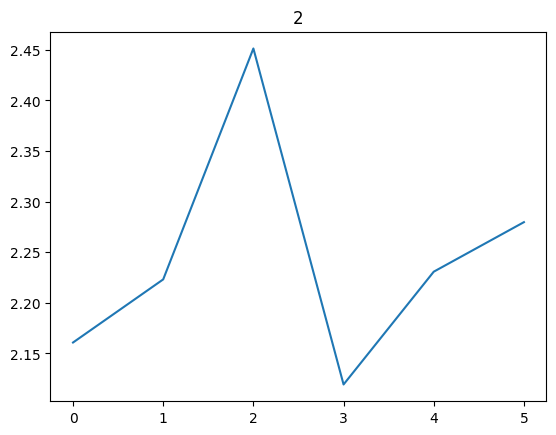

target act 5


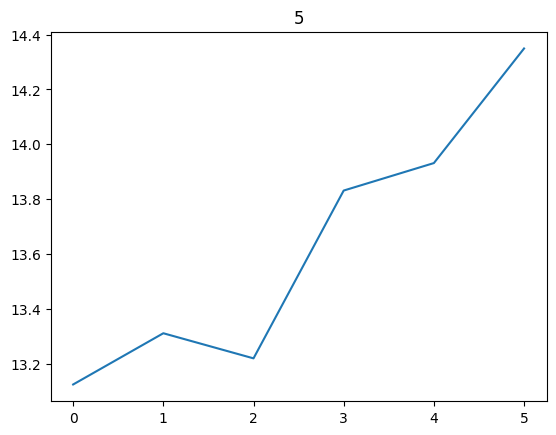

target act 1


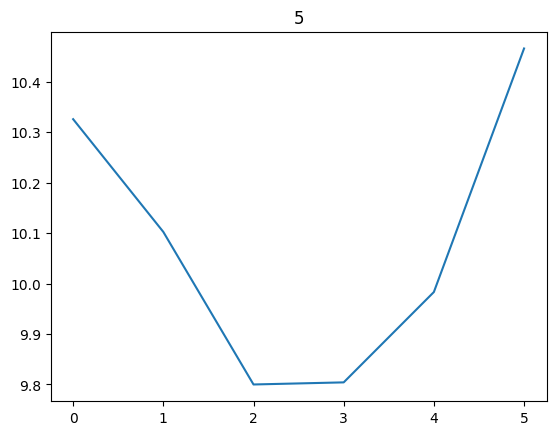

target act 5


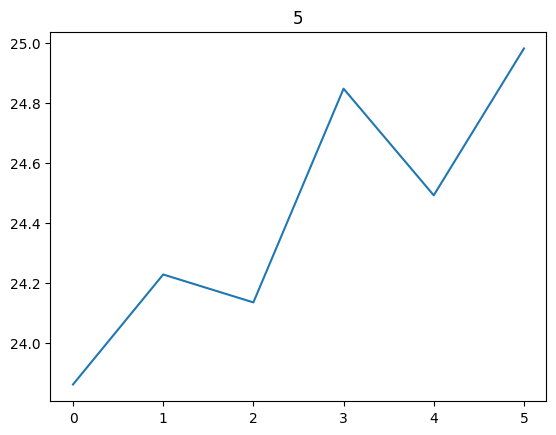

target act 5


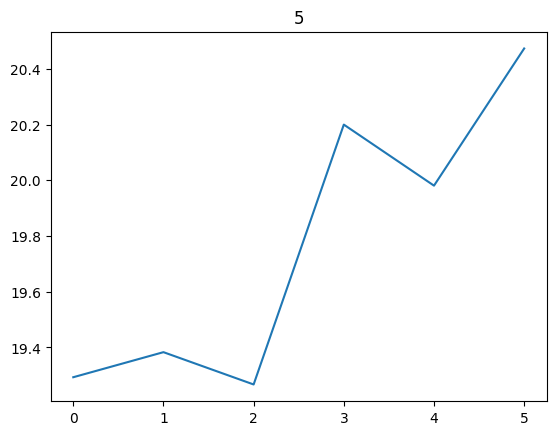

target act 4


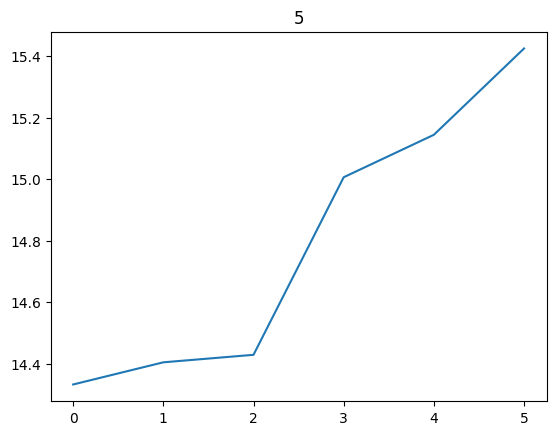

target act 4


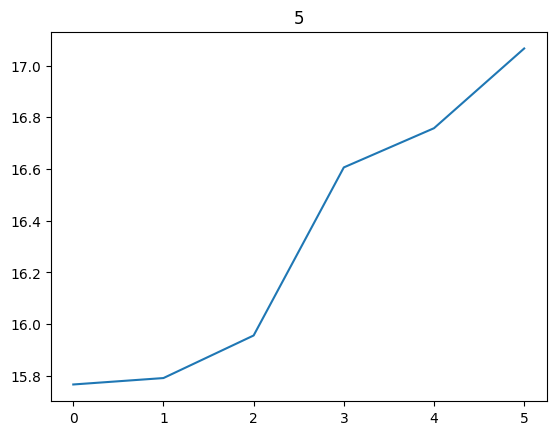

target act 5


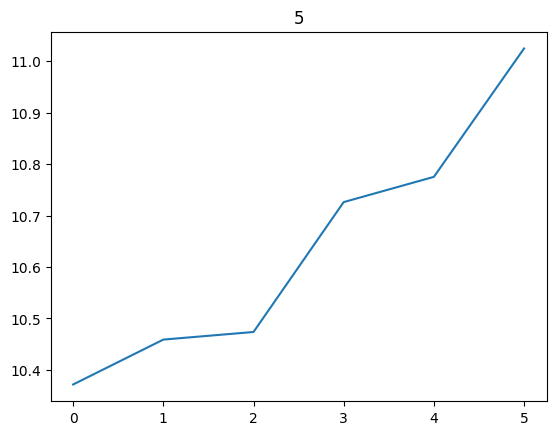

target act 5


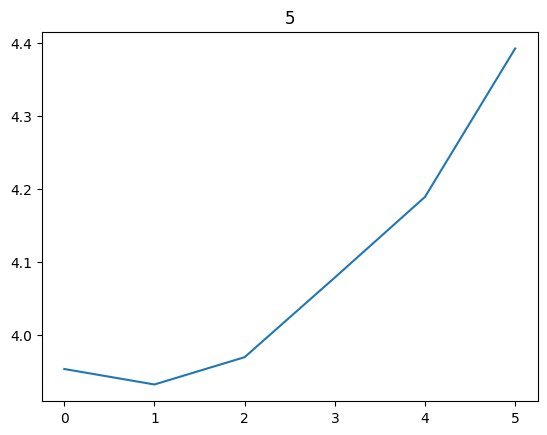

target act 5


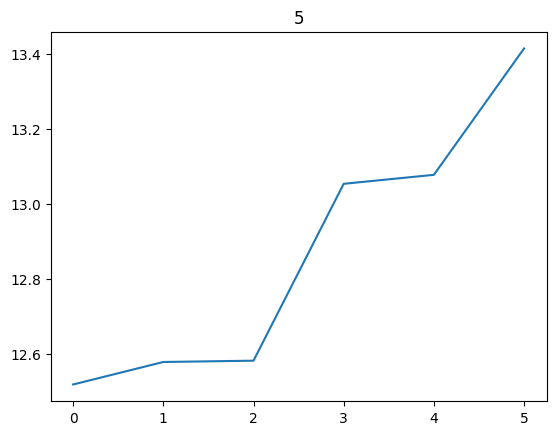

target act 3


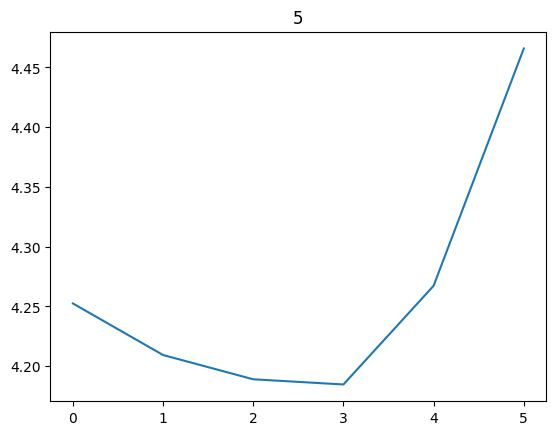

target act 4


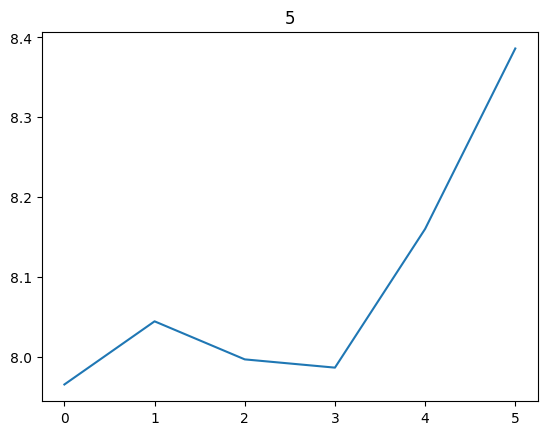

target act 1


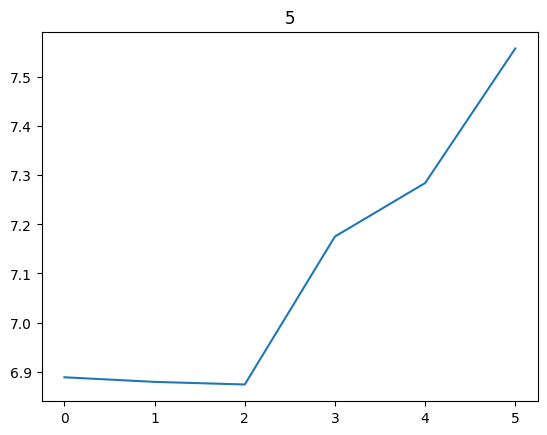

target act 4


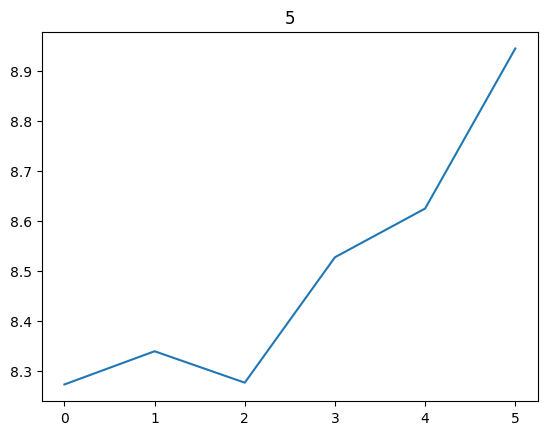

target act 5


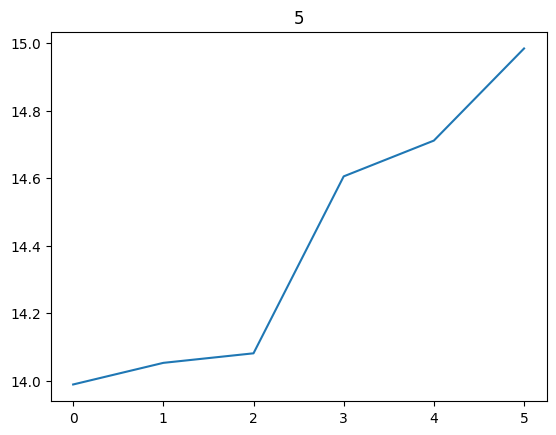

target act 5


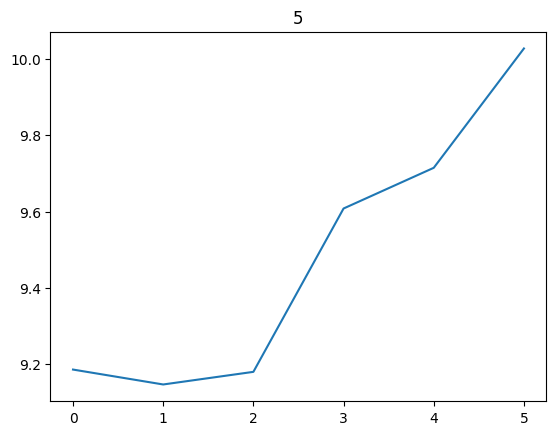

target act 4


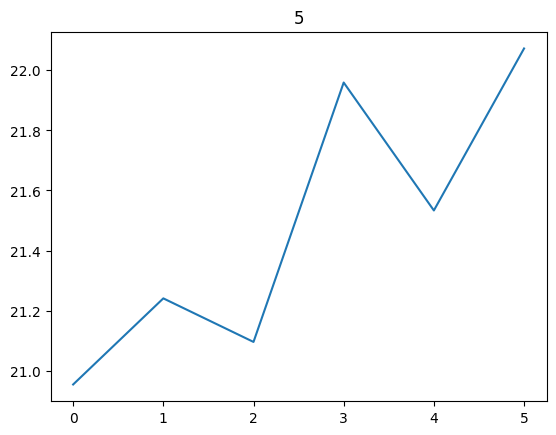

target act 3


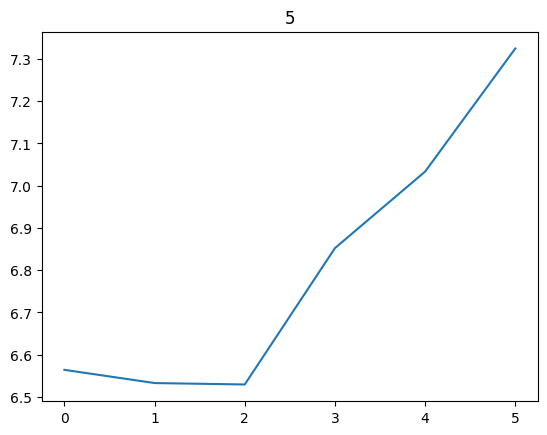

target act 5


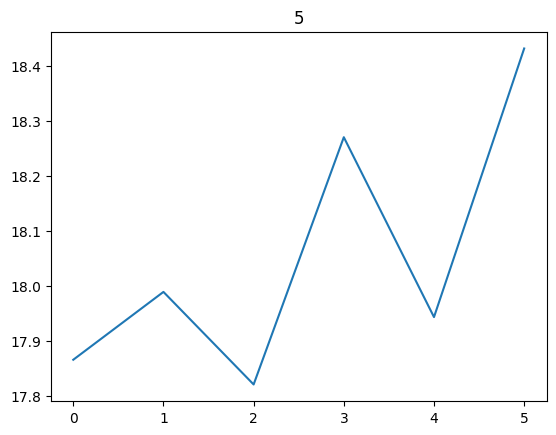

target act 3


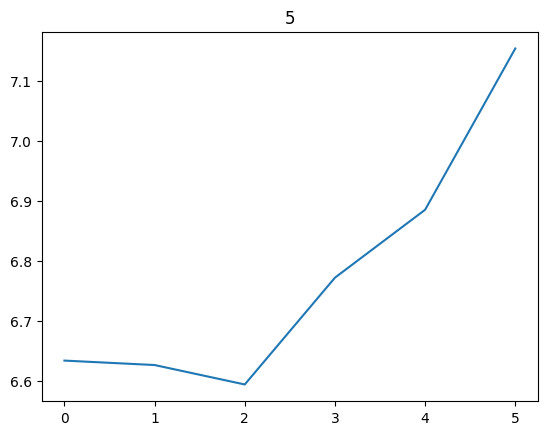

target act 5


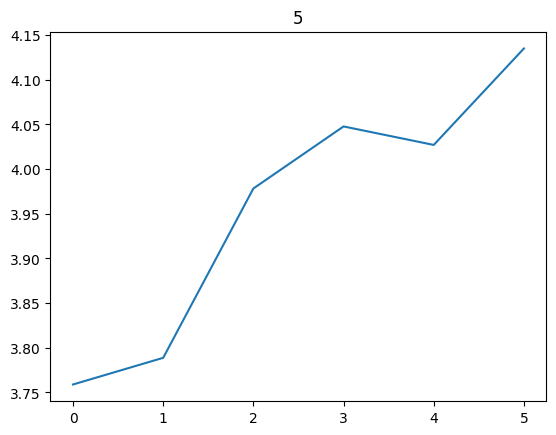

target act 1


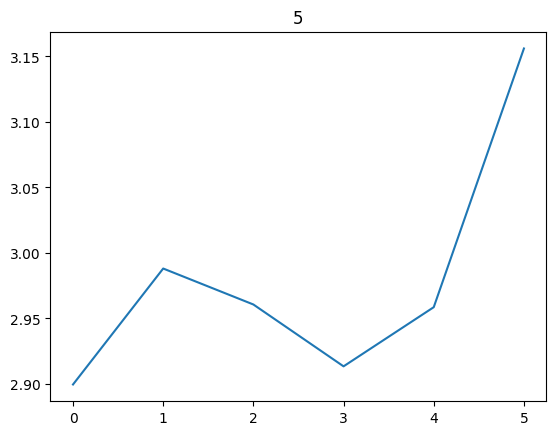

target act 0


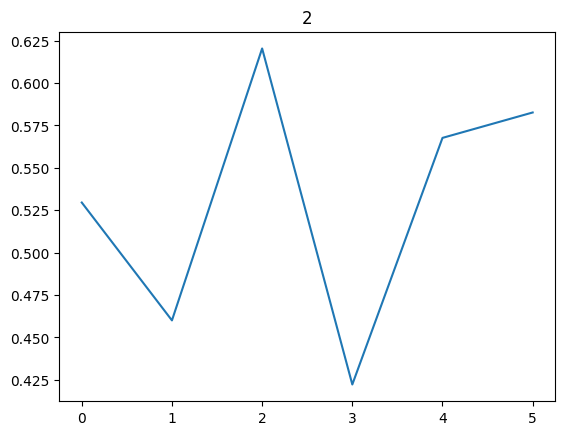

target act 2


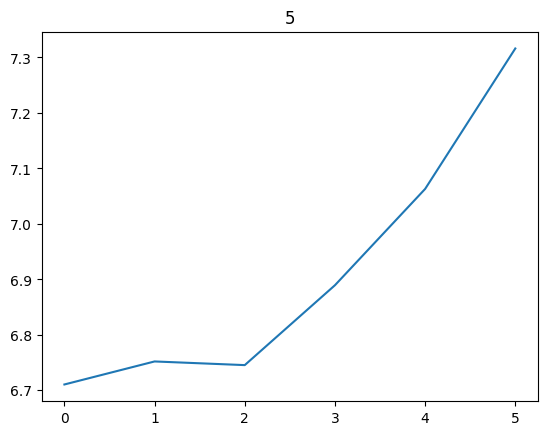

target act 2


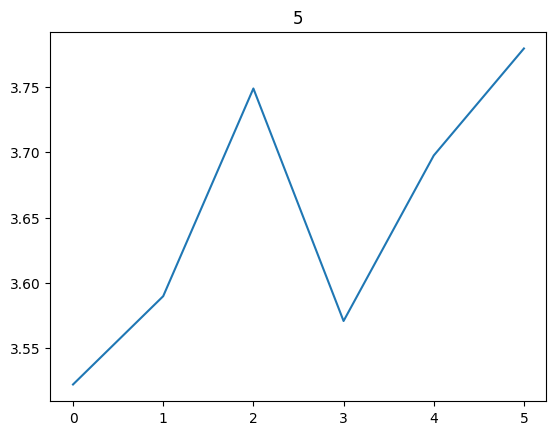

target act 2


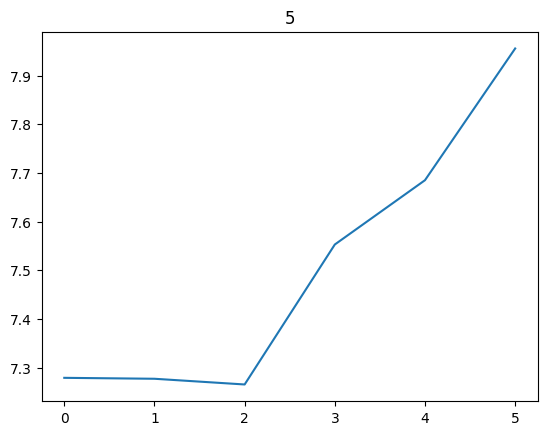

target act 4


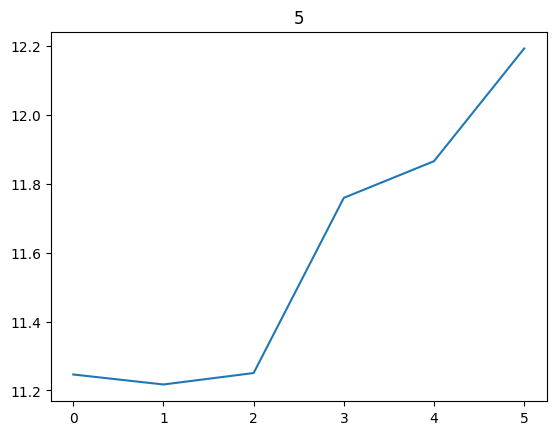

target act 5


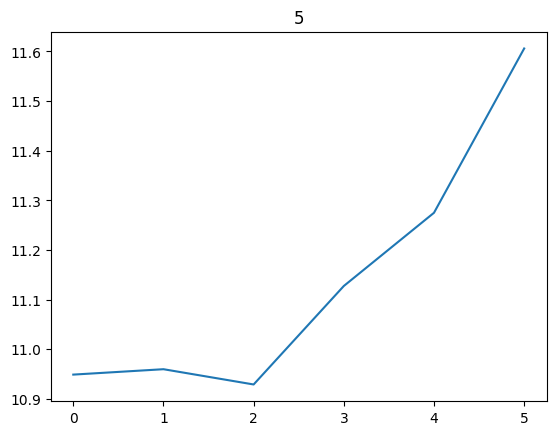

target act 5


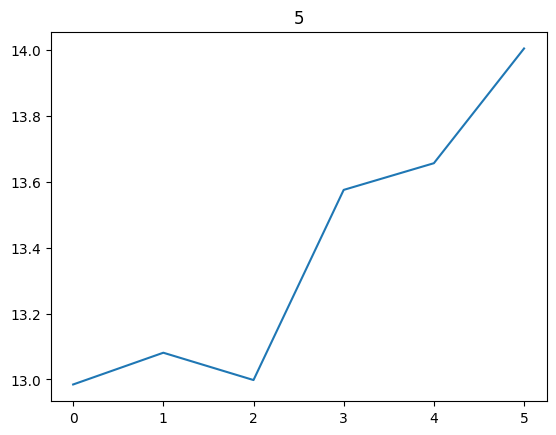

target act 1


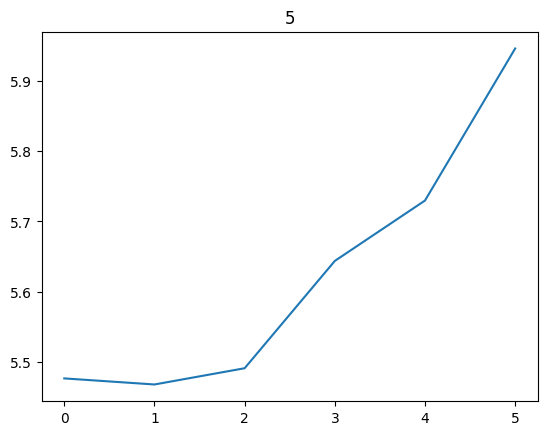

target act 0


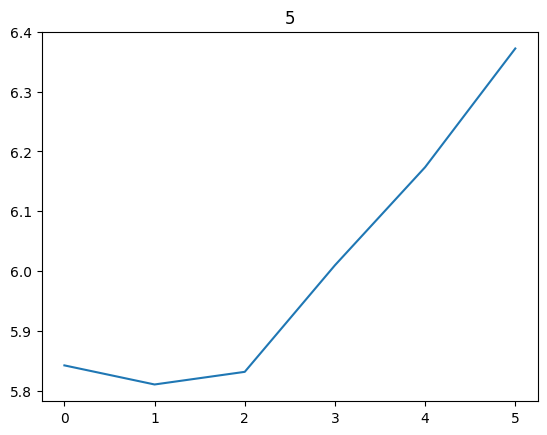

target act 4


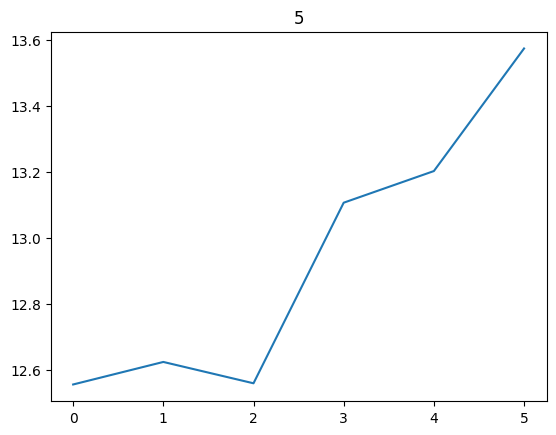

target act 0


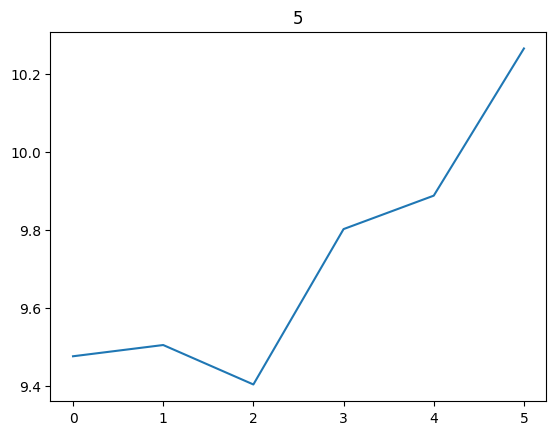

target act 5


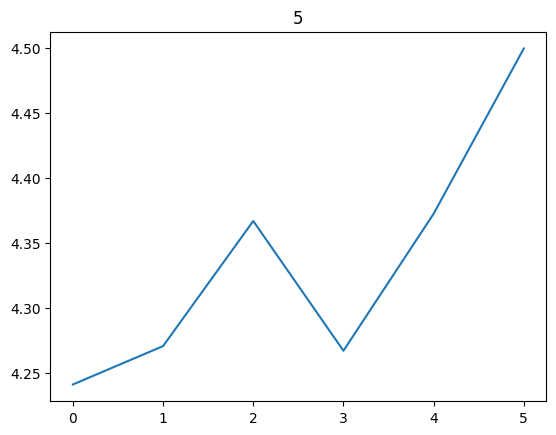

target act 0


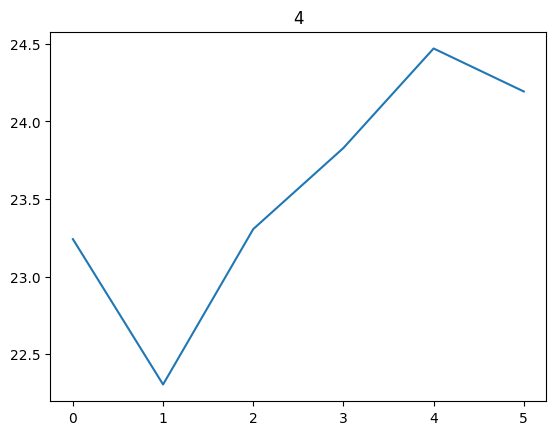

target act 1


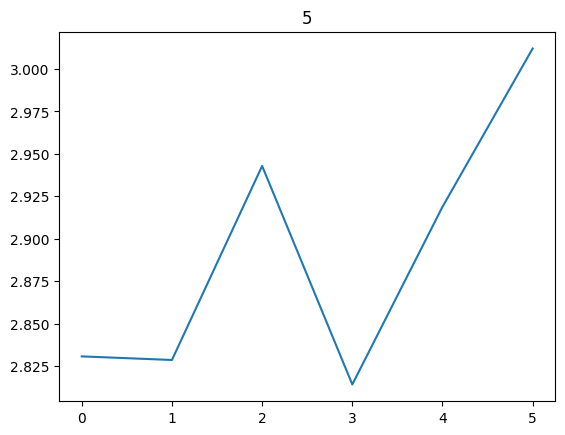

target act 3


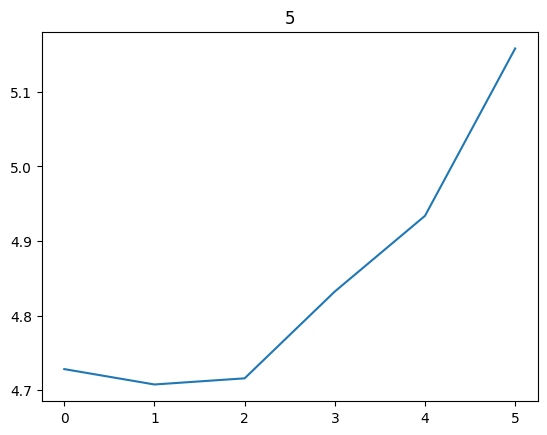

target act 4


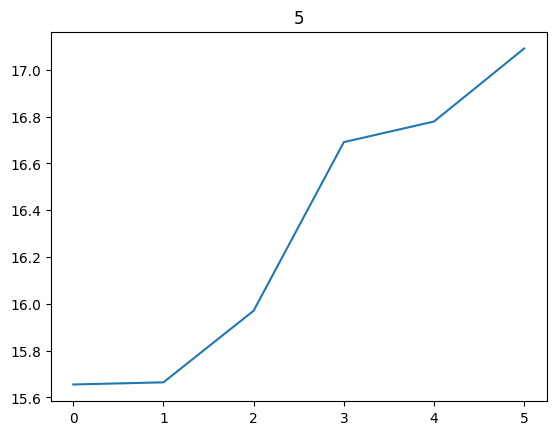

target act 3


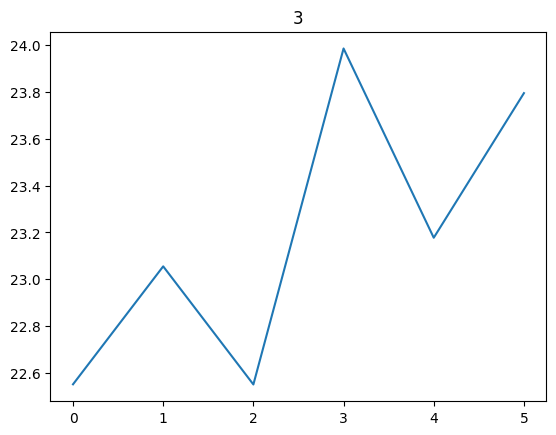

target act 4


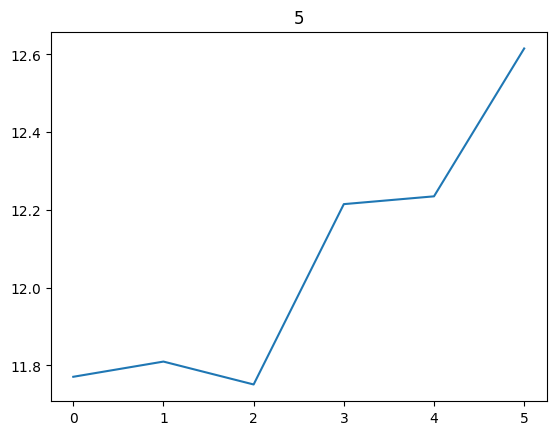

target act 3


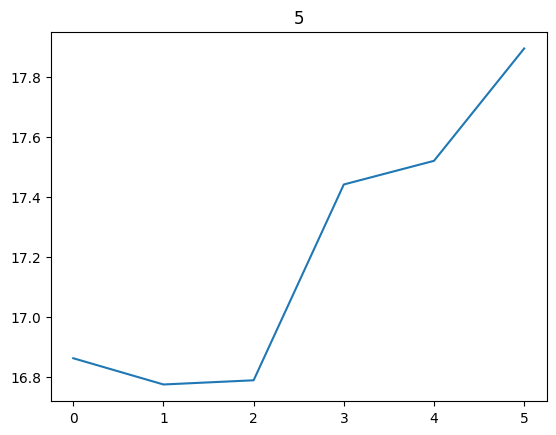

target act 2


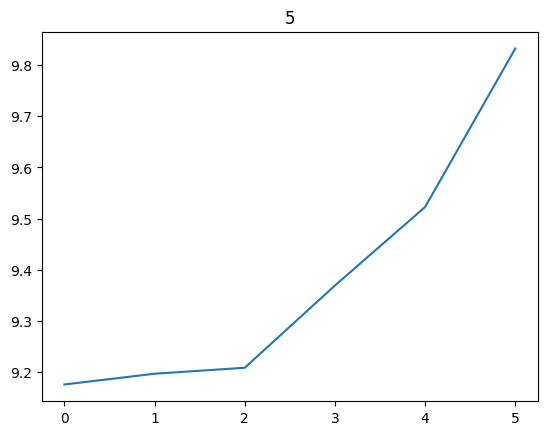

target act 4


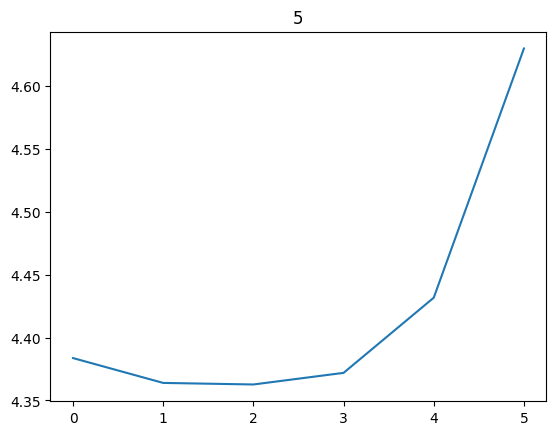

target act 5


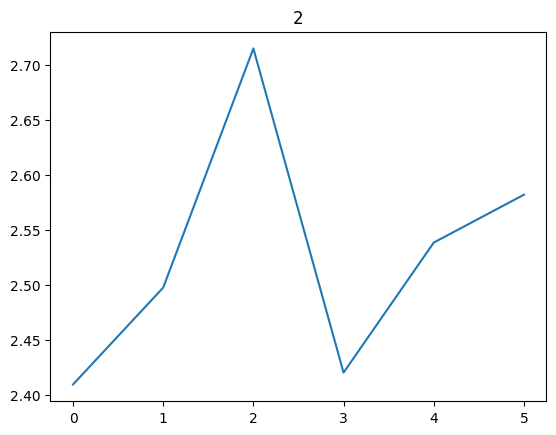

target act 4


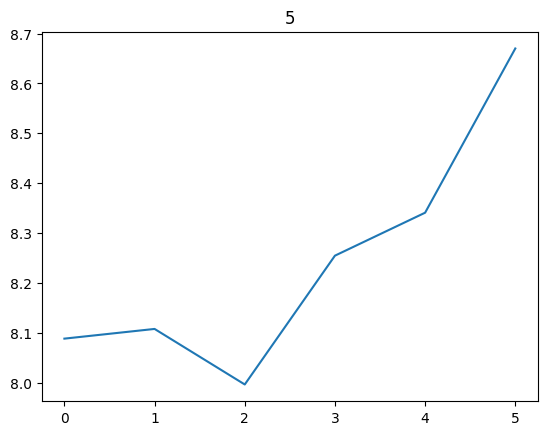

target act 4


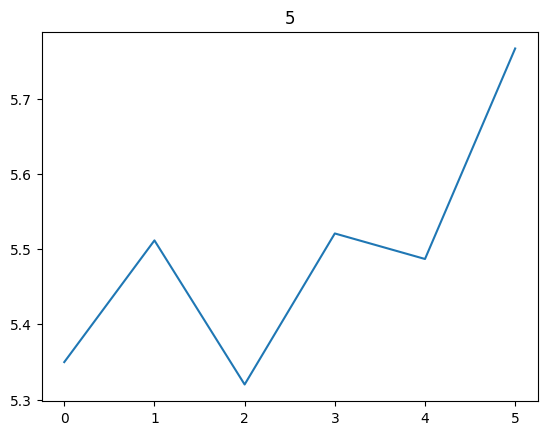

target act 3


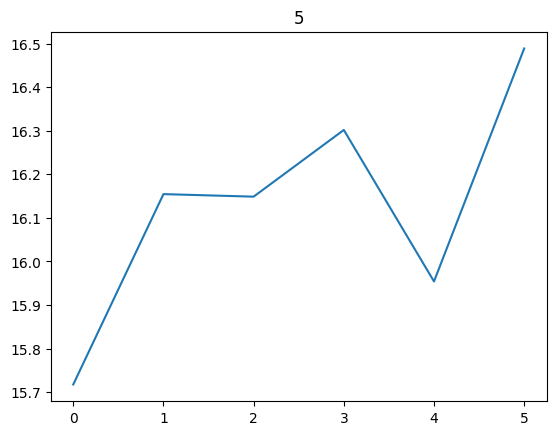

target act 4


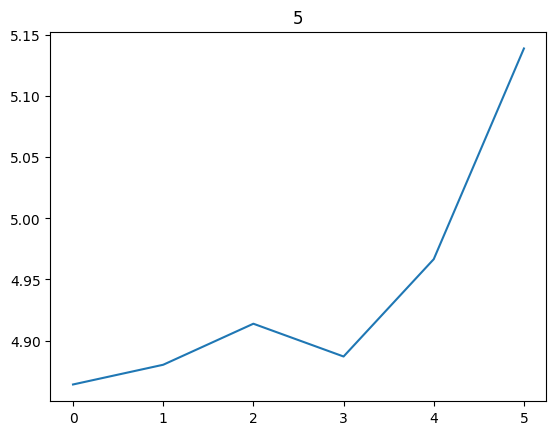

target act 4


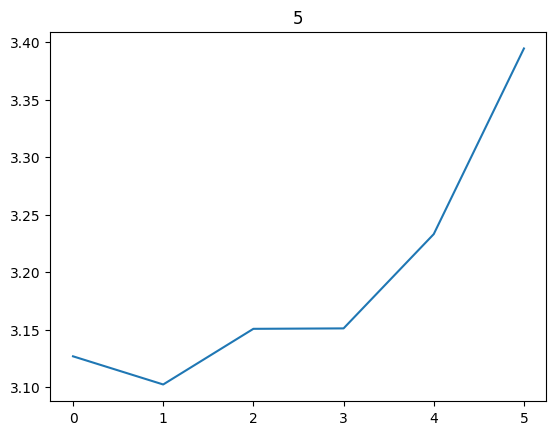

target act 1


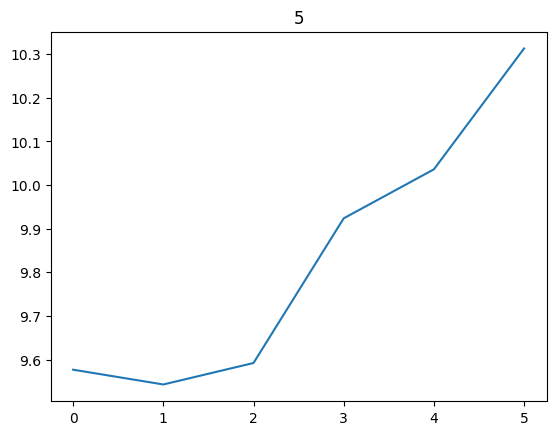

target act 3


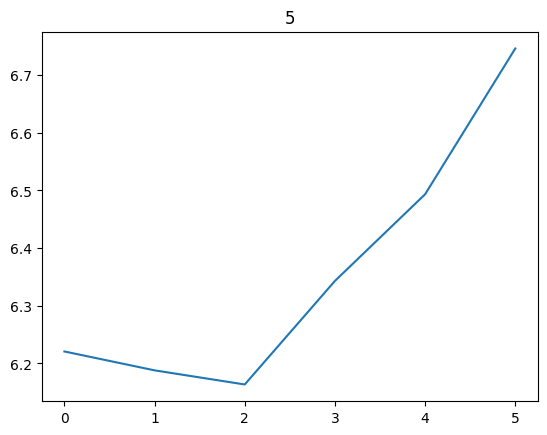

target act 0


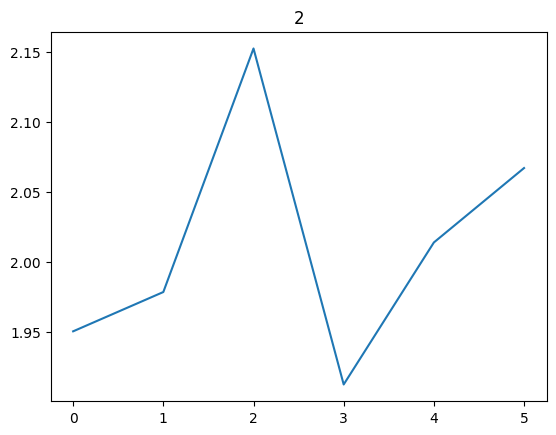

target act 1


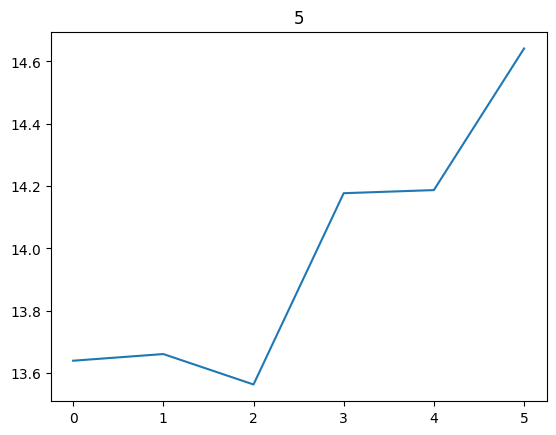

target act 3


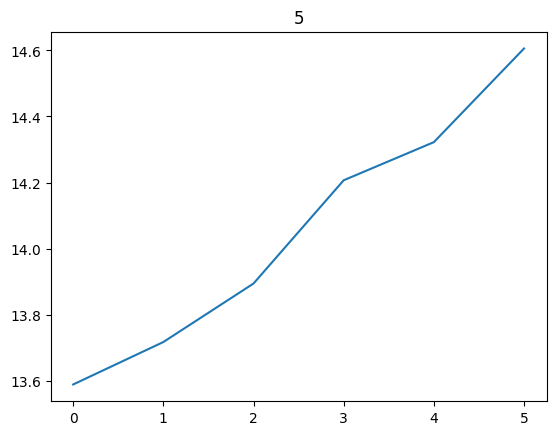

target act 3


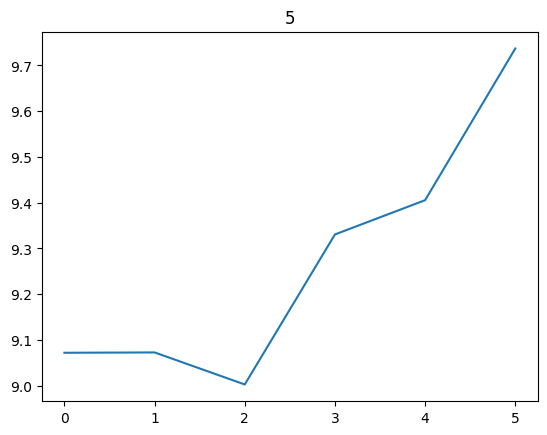

target act 4


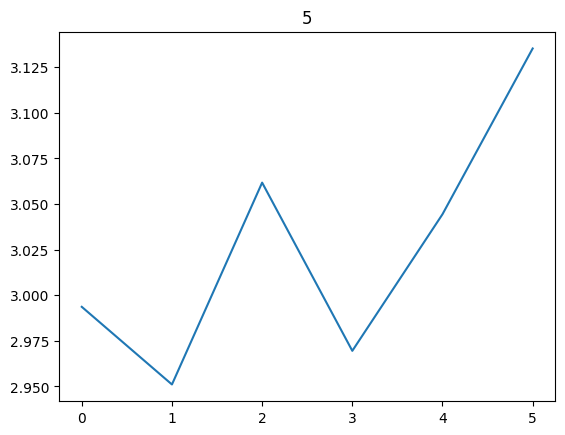

target act 1


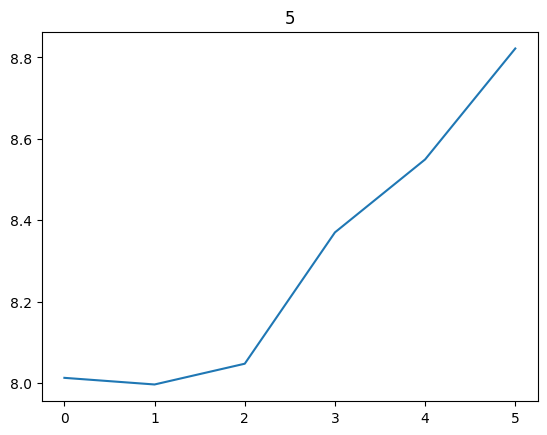

target act 3


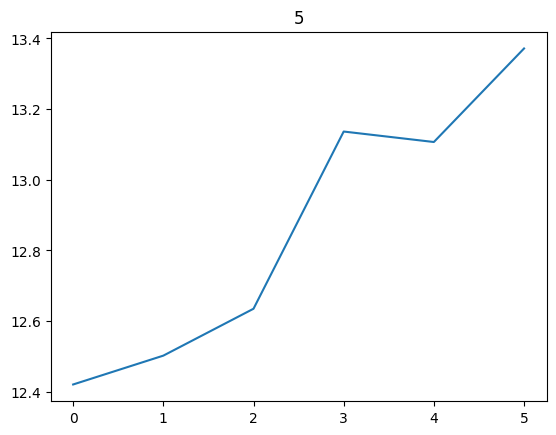

target act 0


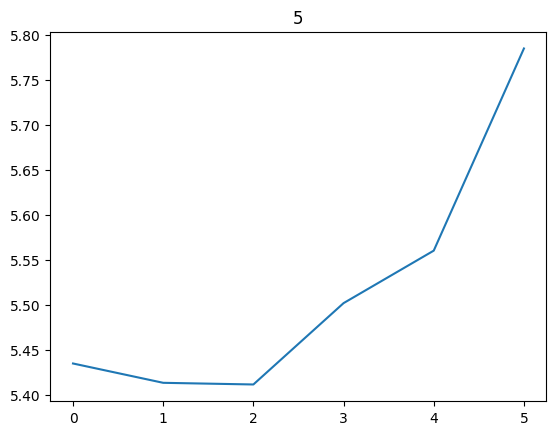

target act 5


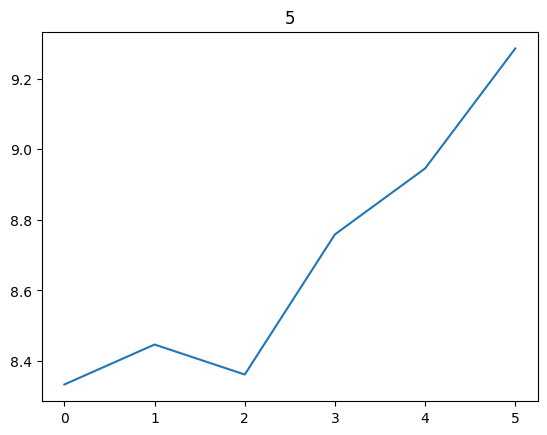

target act 1


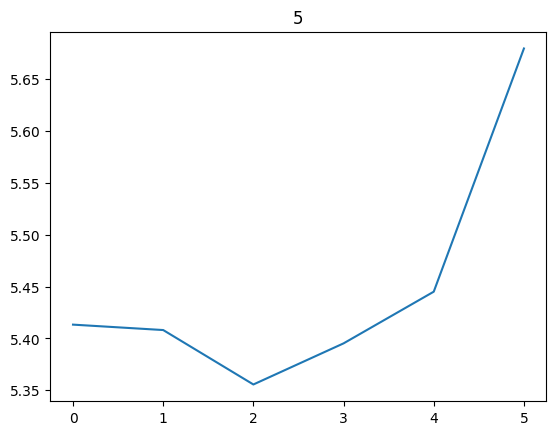

target act 0


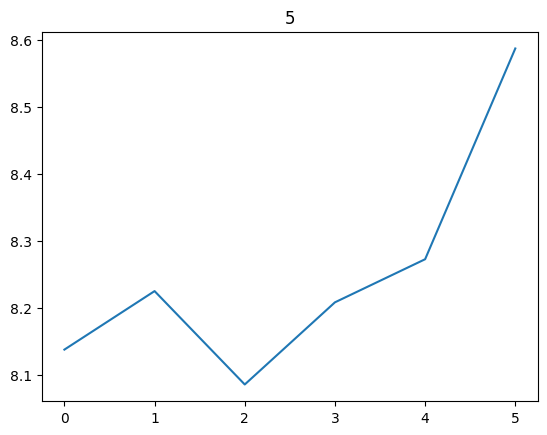

target act 5


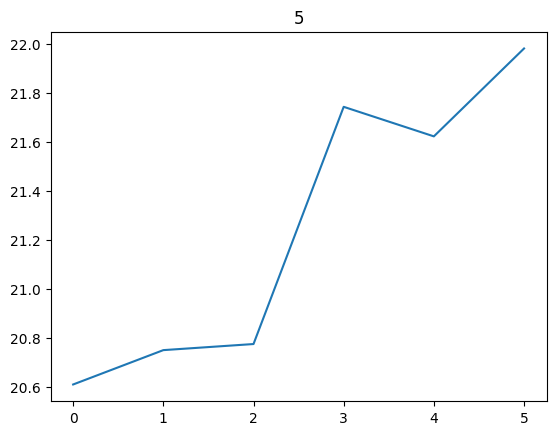

target act 3


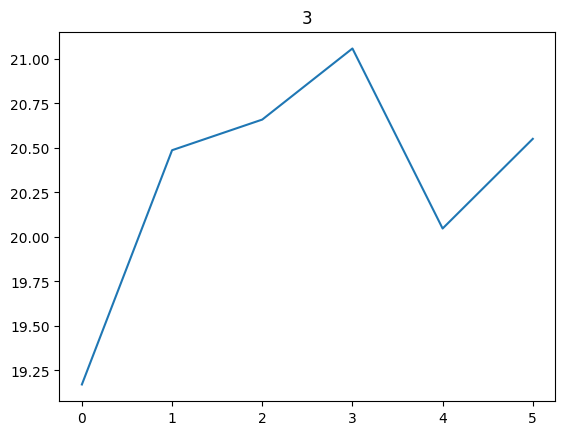

target act 5


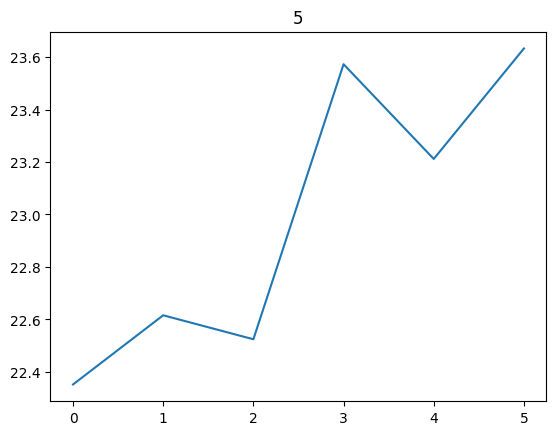

target act 5


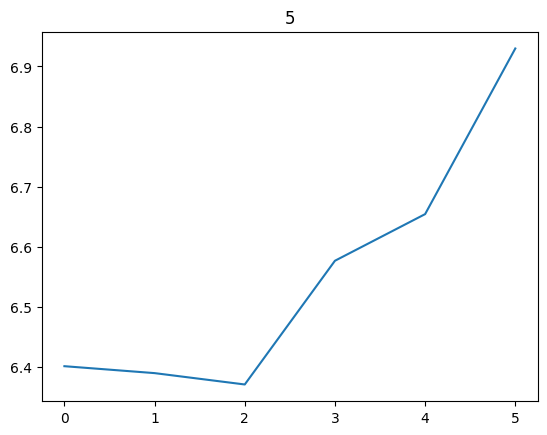

target act 0


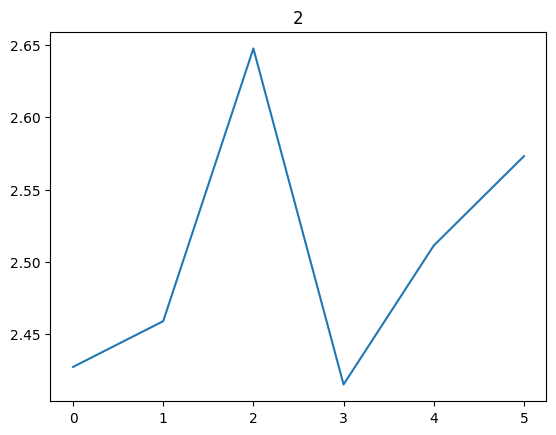

target act 0


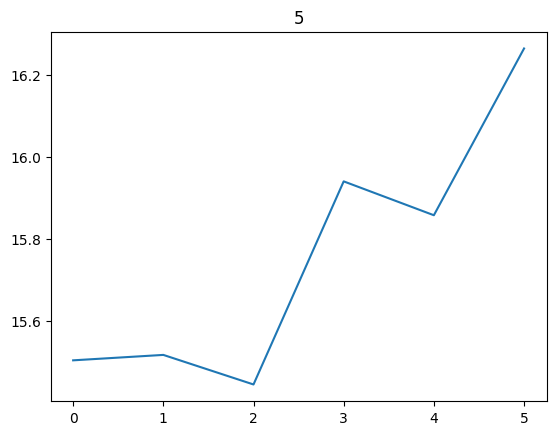

target act 1


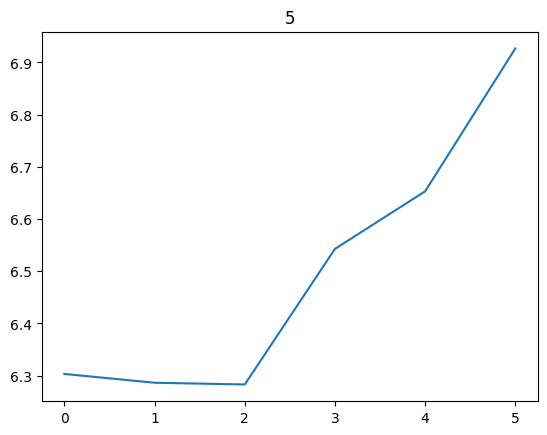

target act 1


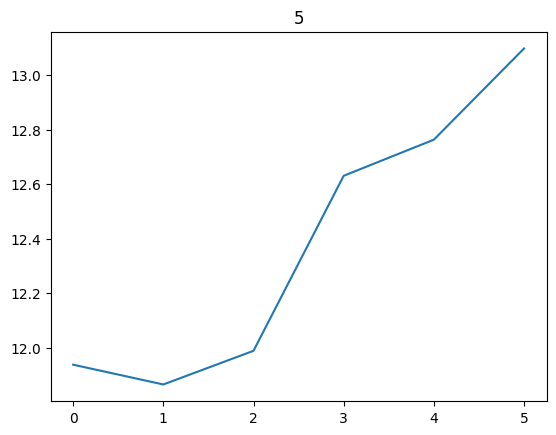

target act 4


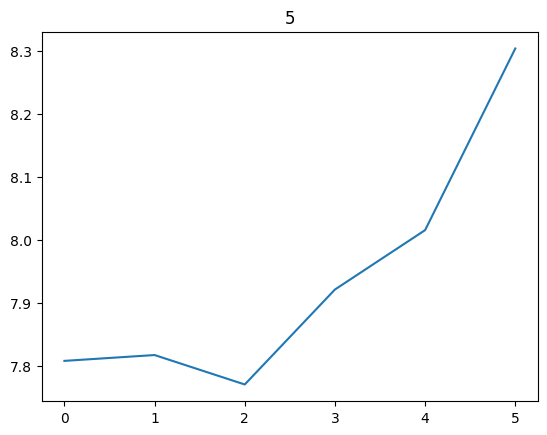

target act 1


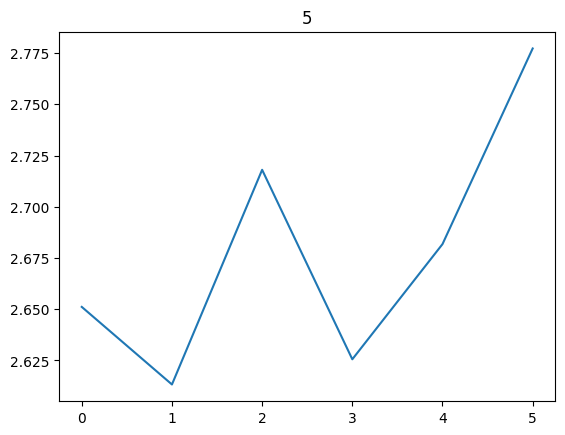

target act 5


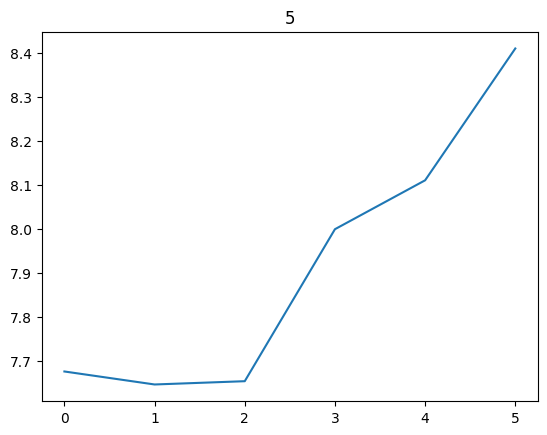

target act 4


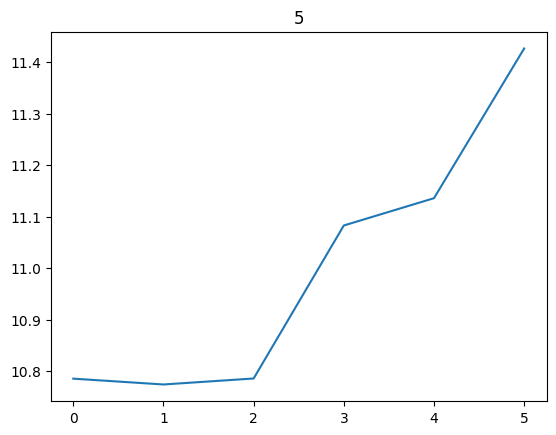

target act 0


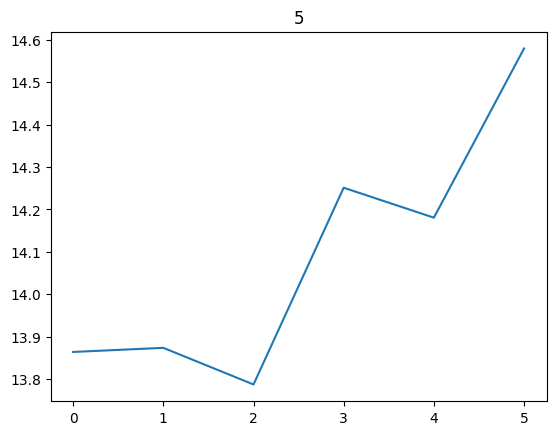

target act 4


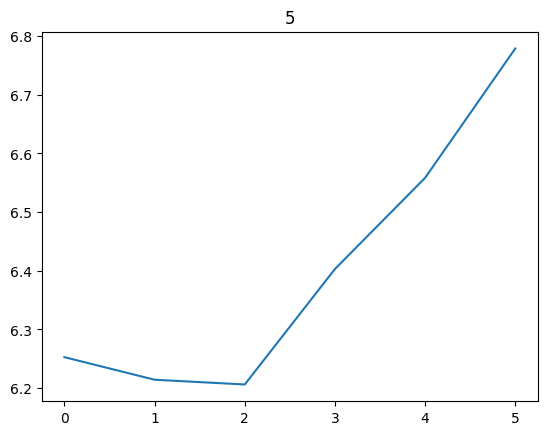

target act 0


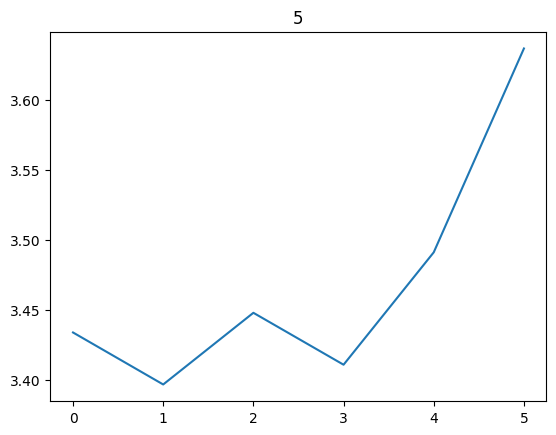

target act 4


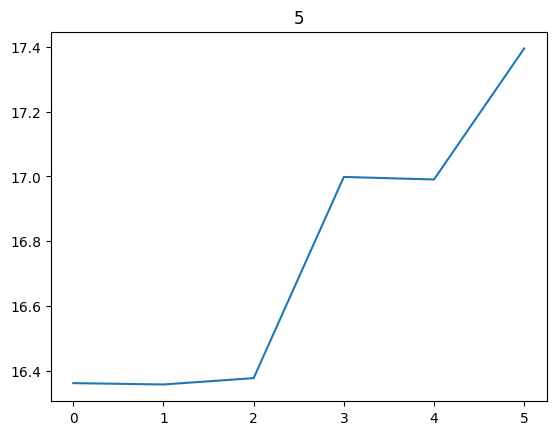

target act 4


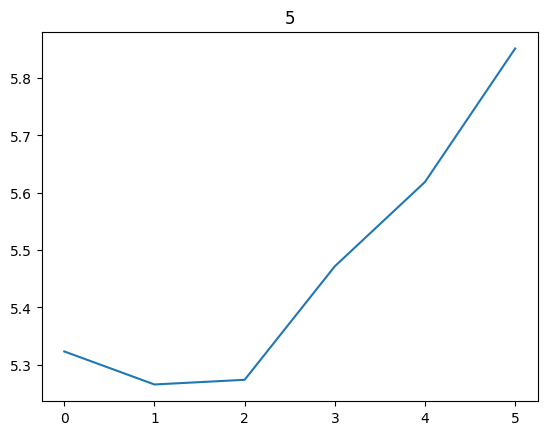

target act 3


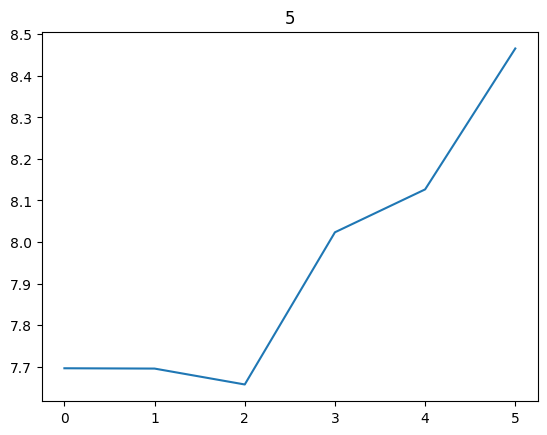

target act 1


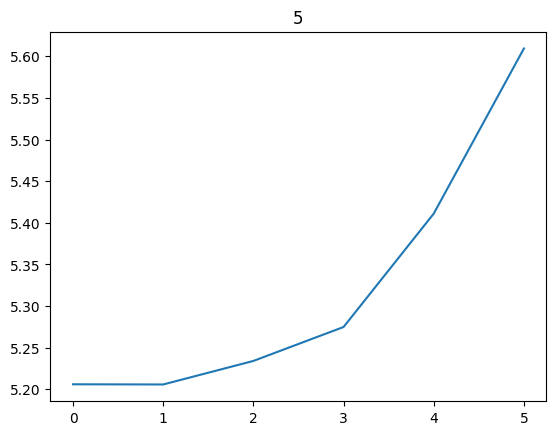

target act 4


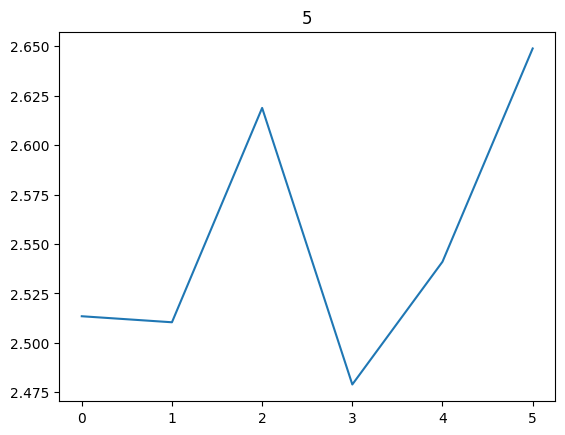

target act 0


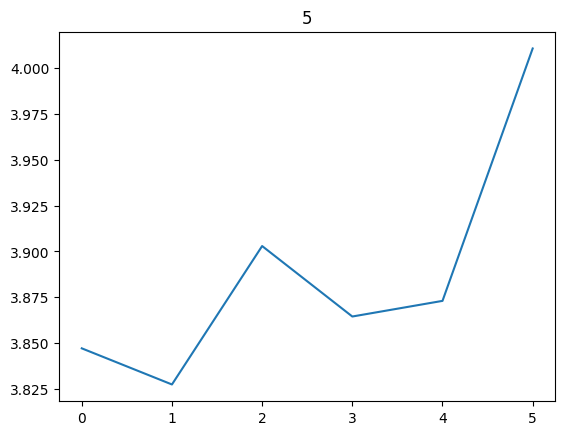

target act 5


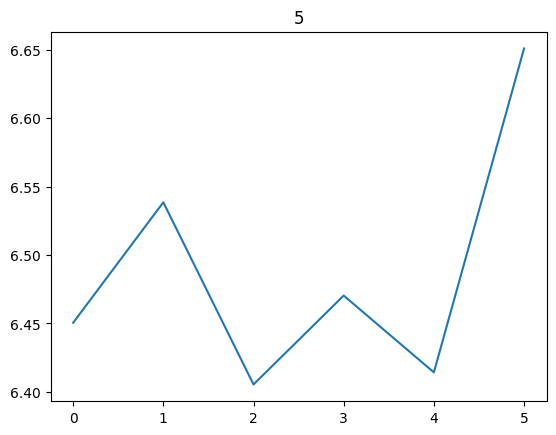

target act 2


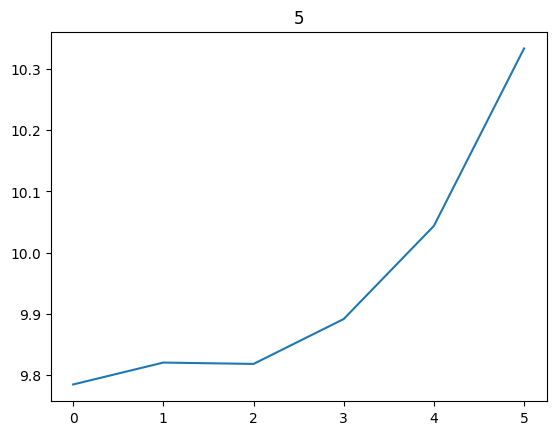

target act 5


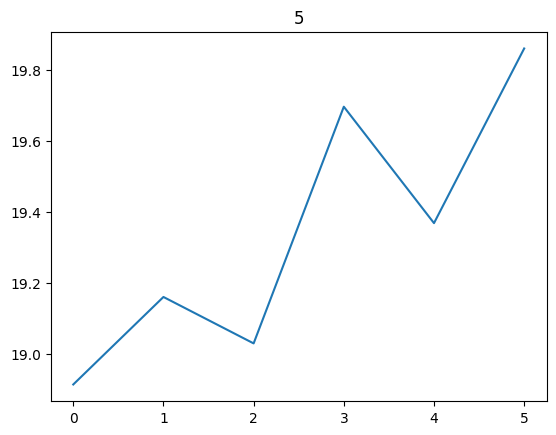

target act 4


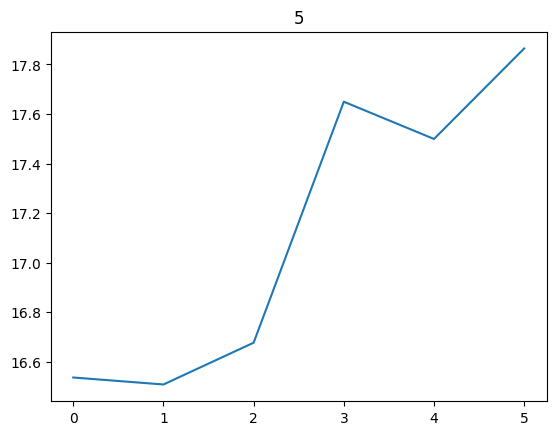

target act 5


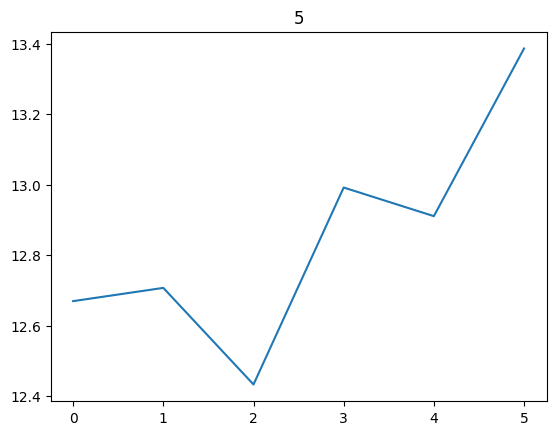

target act 5


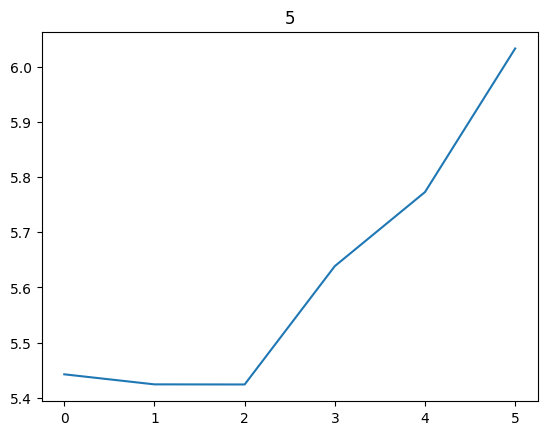

target act 4


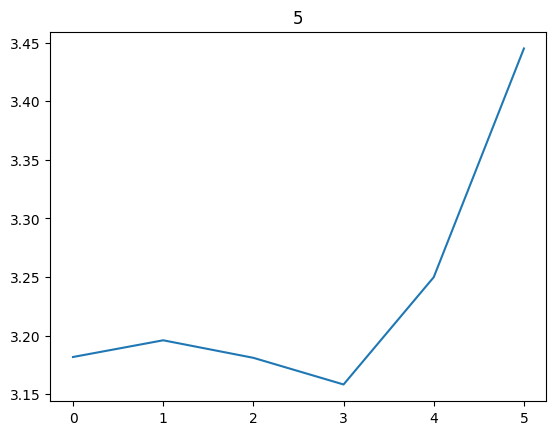

target act 5


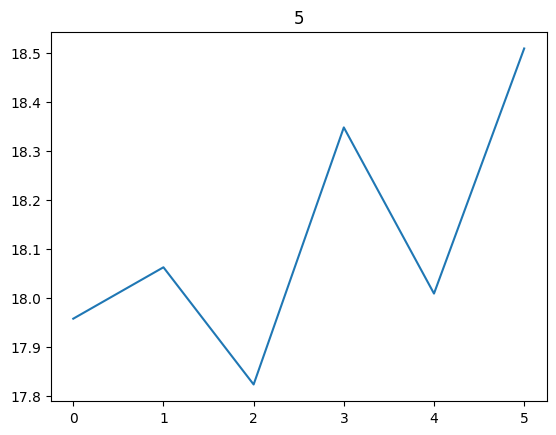

target act 3


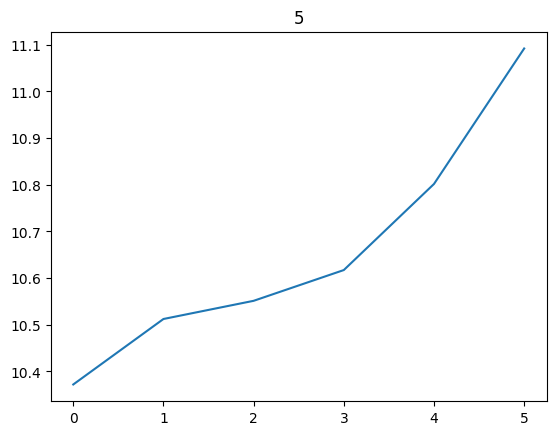

target act 3


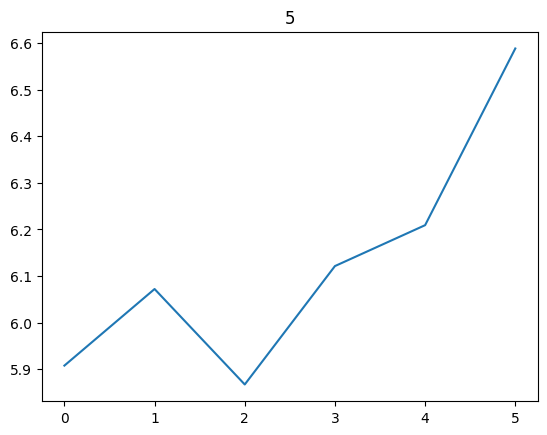

target act 4


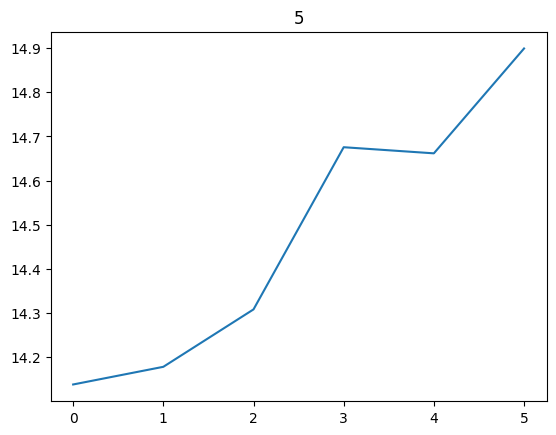

target act 5


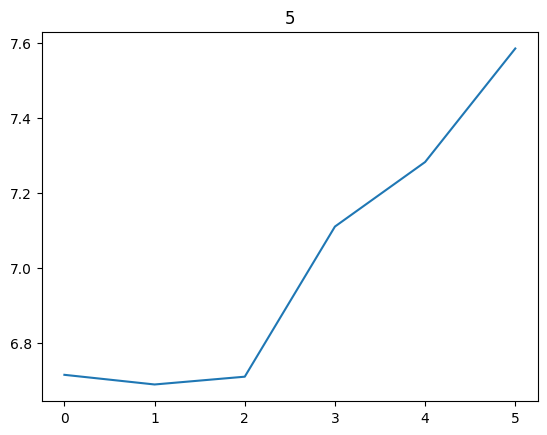

target act 4


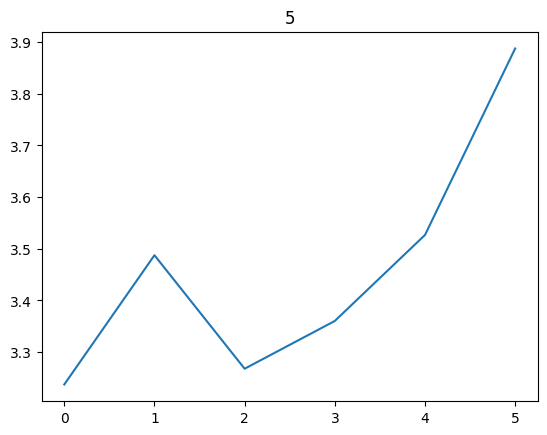

target act 5


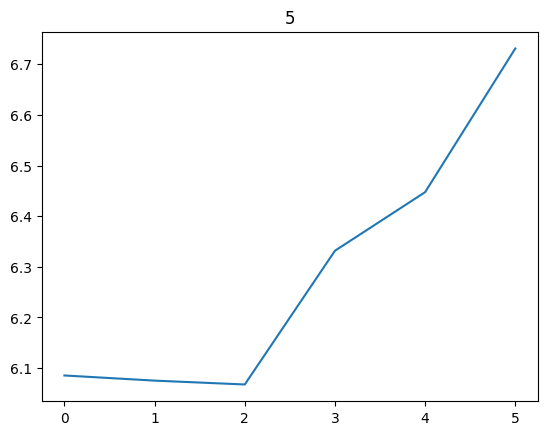

target act 0


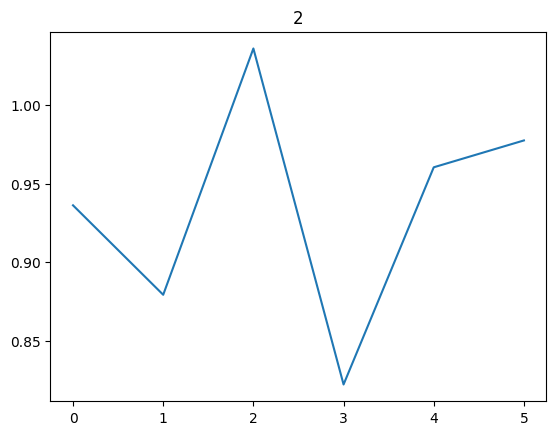

target act 1


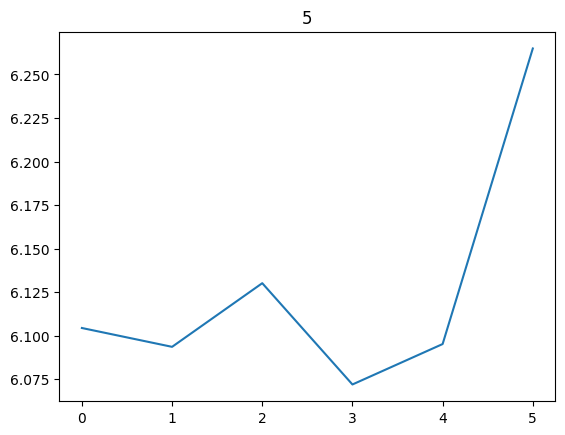

target act 5


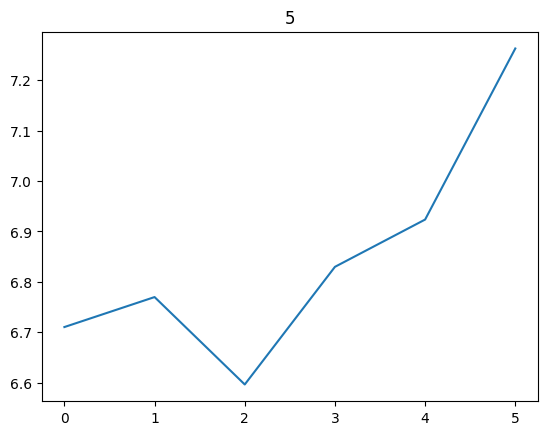

target act 5


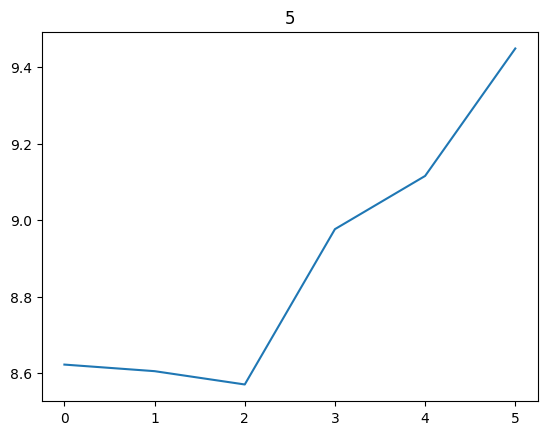

target act 5


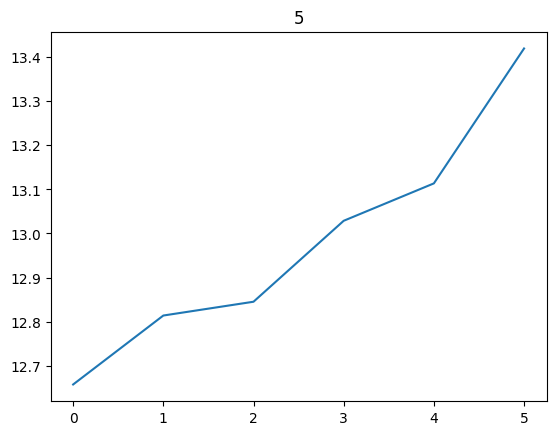

target act 1


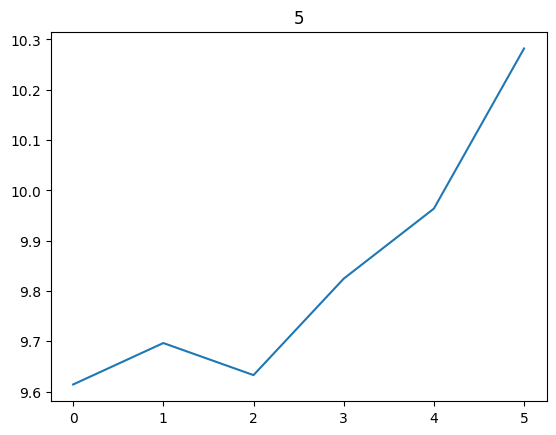

target act 3


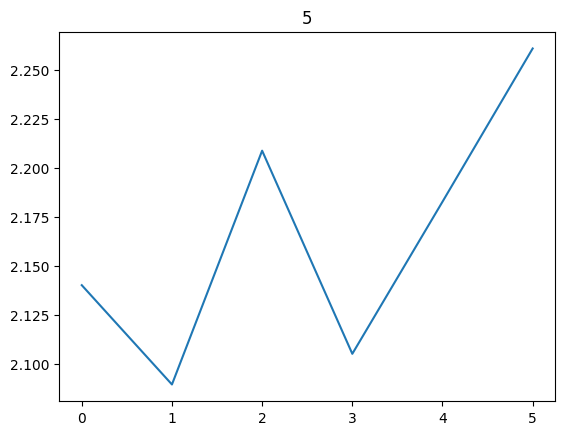

target act 4


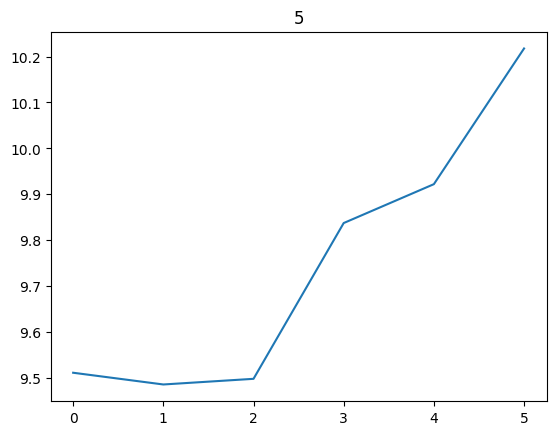

target act 5


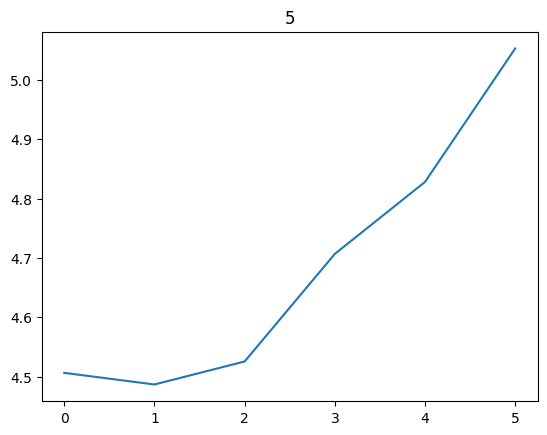

target act 2


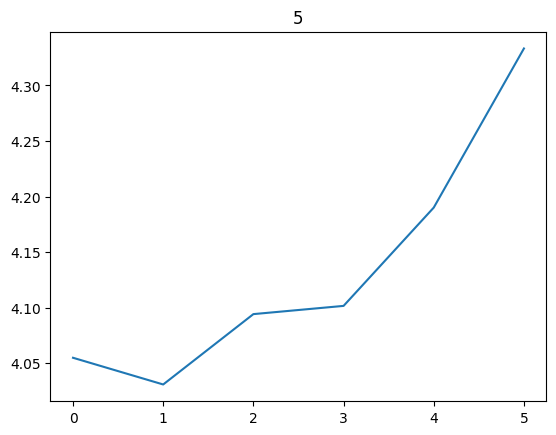

target act 1


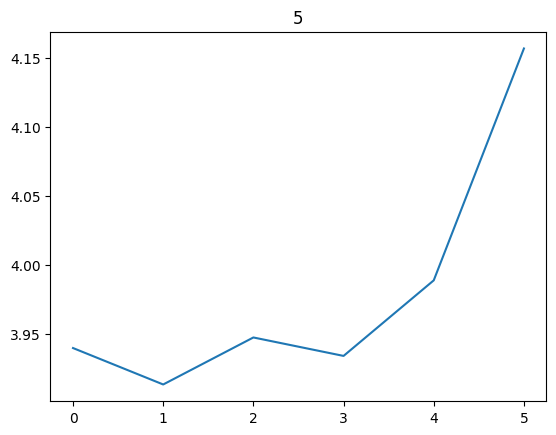

target act 3


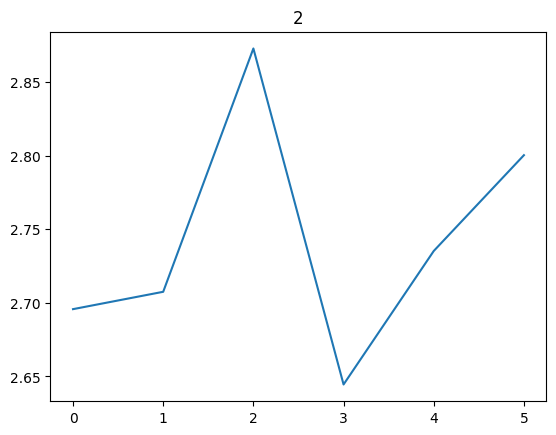

target act 3


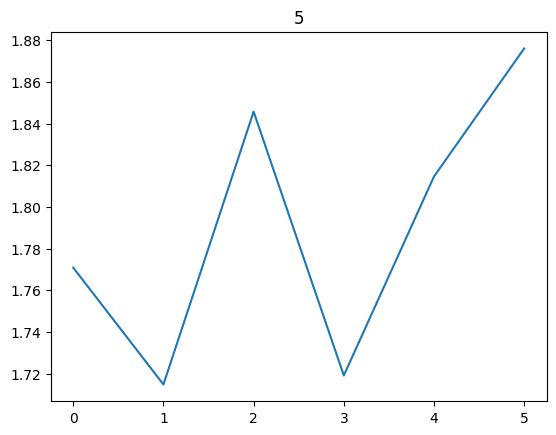

target act 5


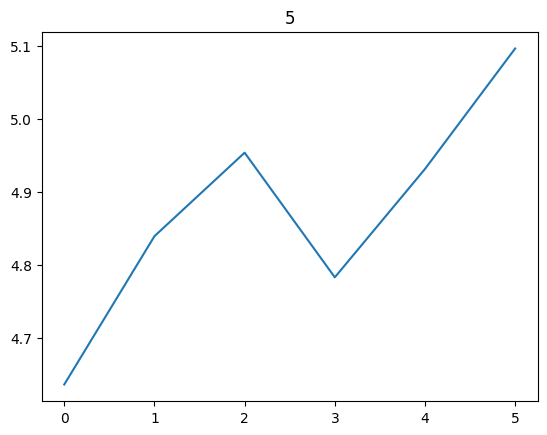

target act 2


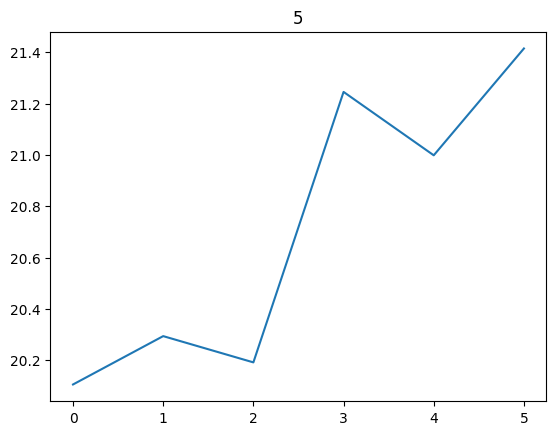

target act 5


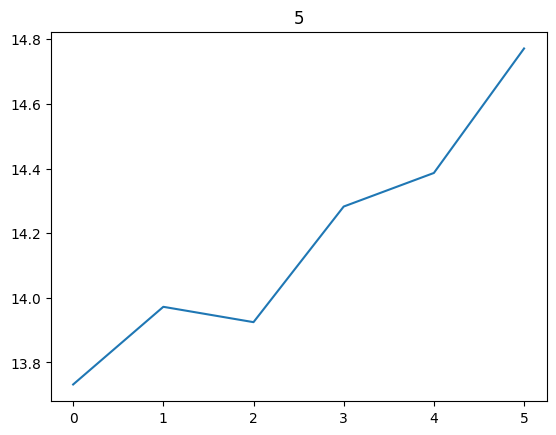

target act 5


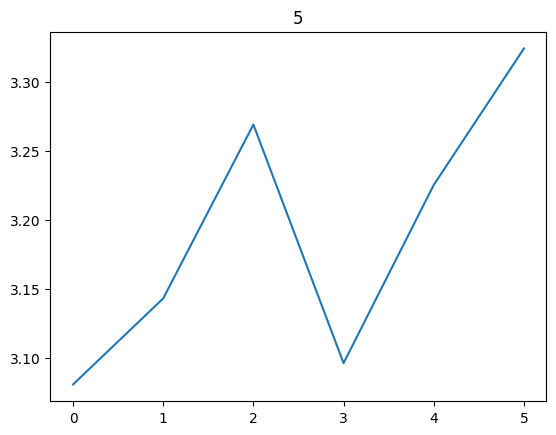

target act 2


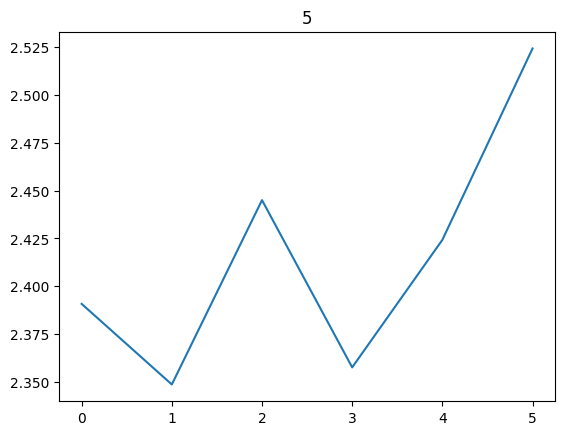

target act 5


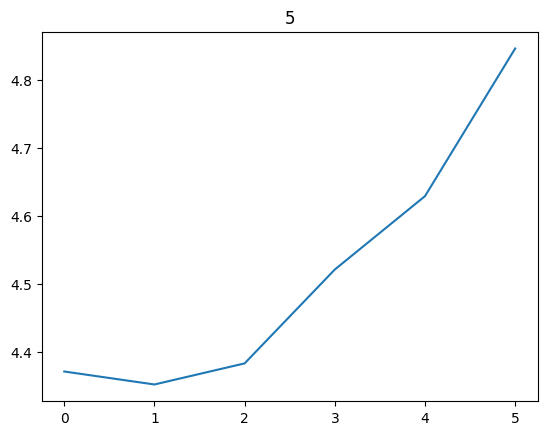

target act 5


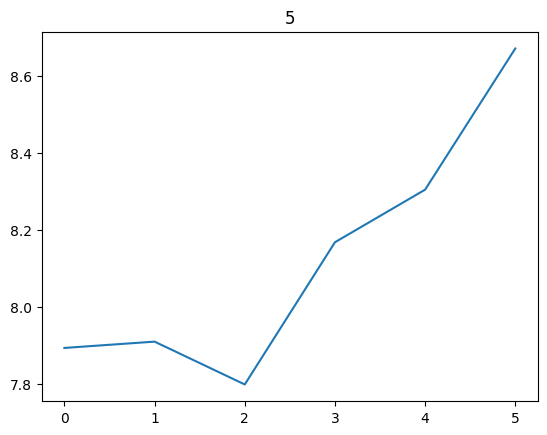

target act 5


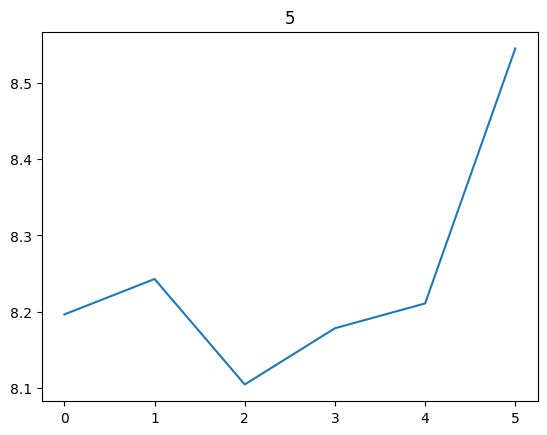

target act 5


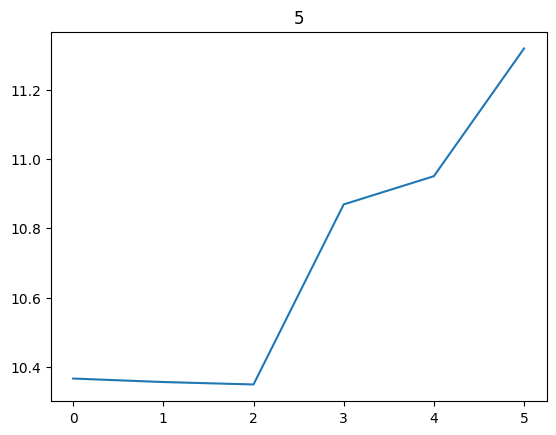

target act 2


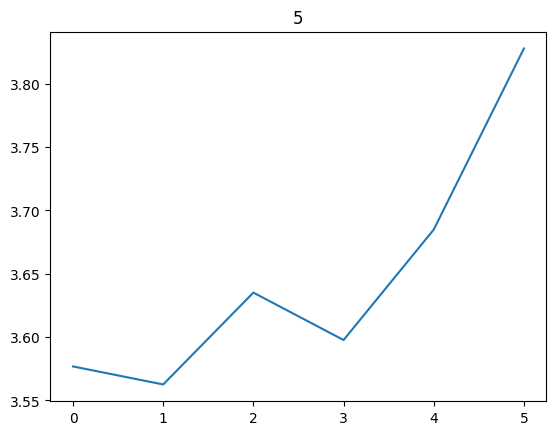

target act 5


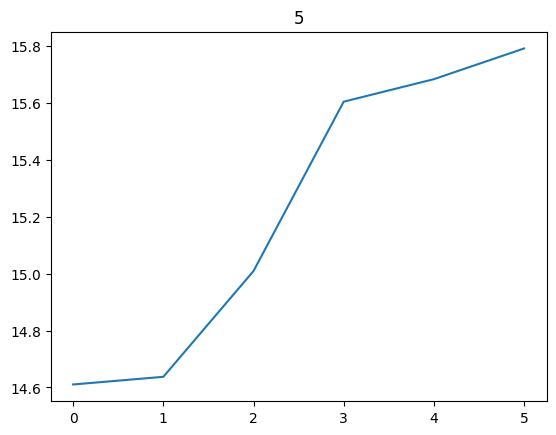

target act 1


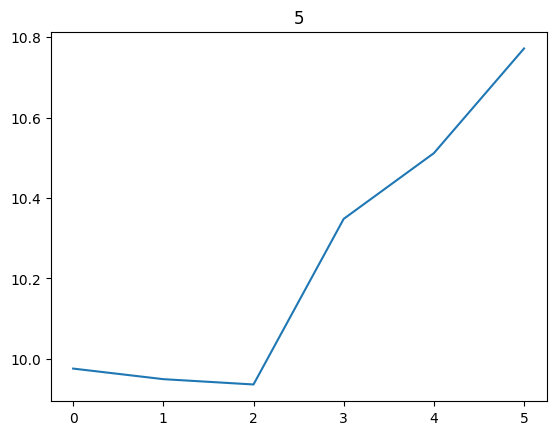

target act 4


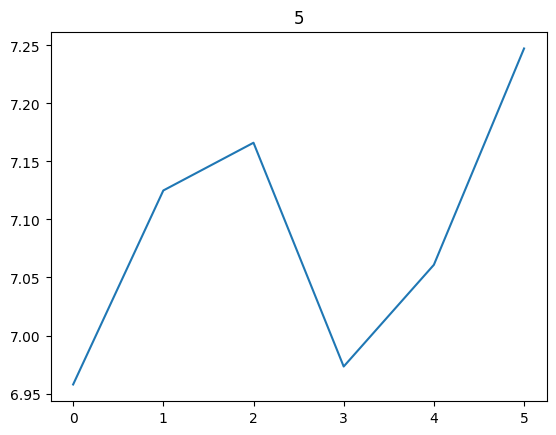

target act 0


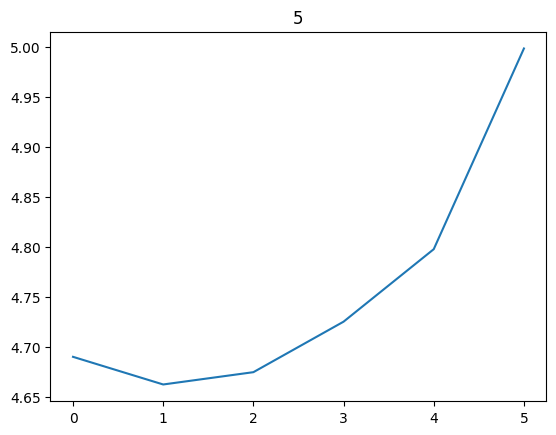

target act 1


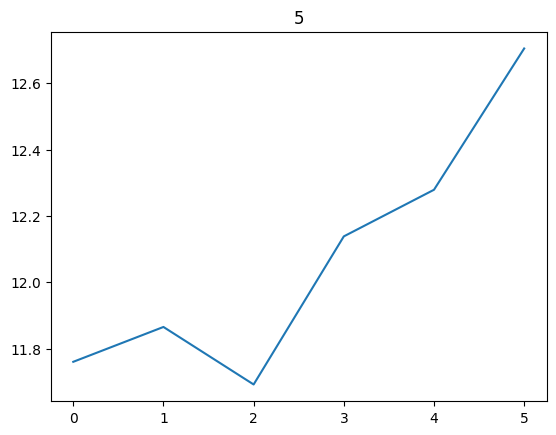

target act 3


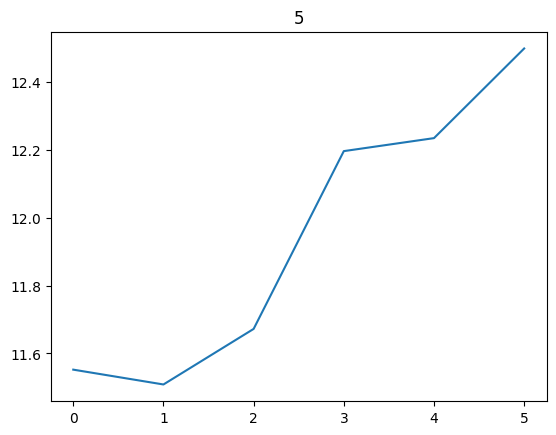

target act 5


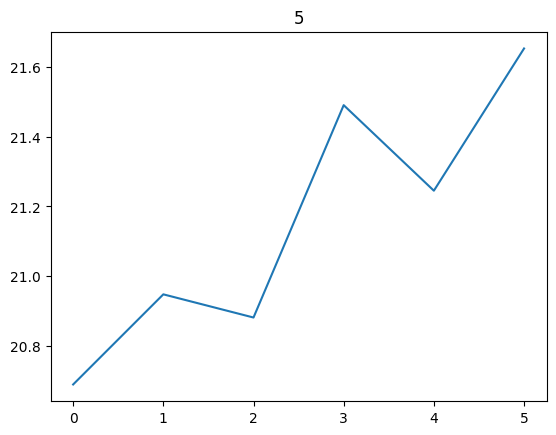

target act 2


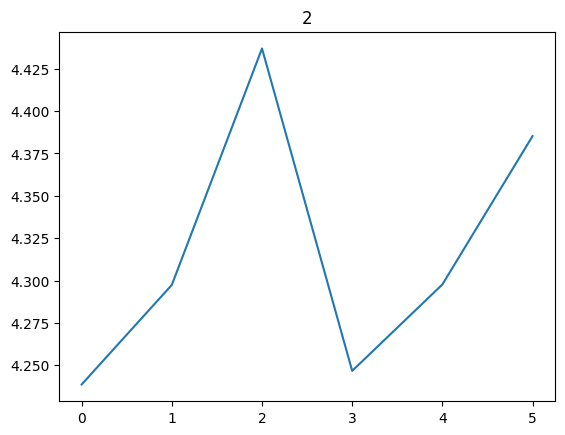

target act 4


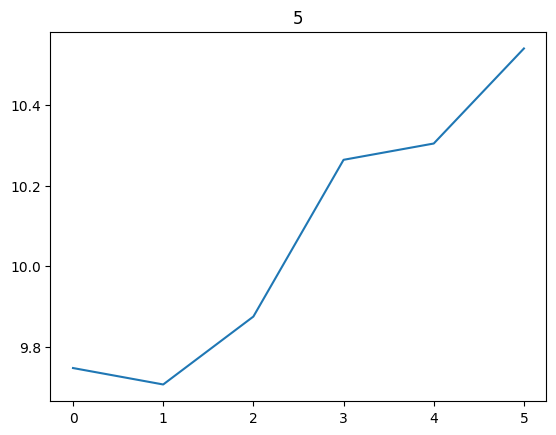

target act 2


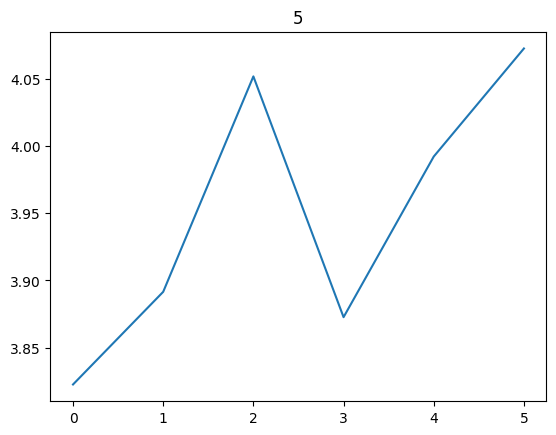

target act 5


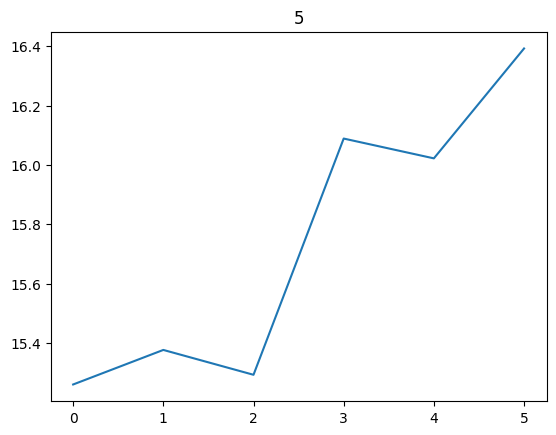

target act 4


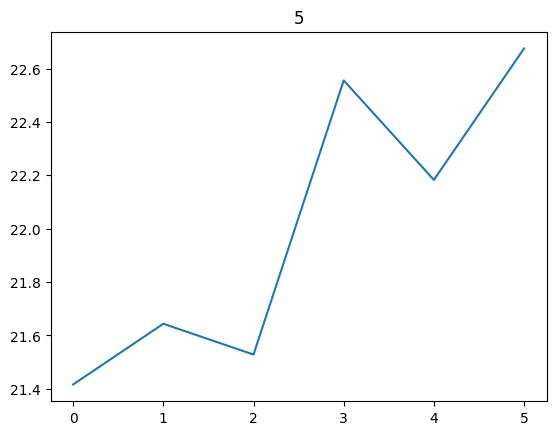

target act 5


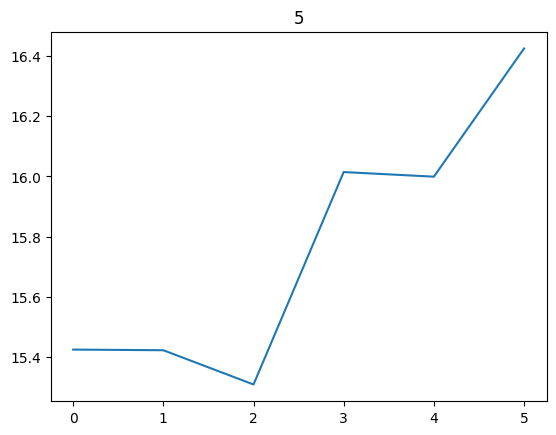

target act 4


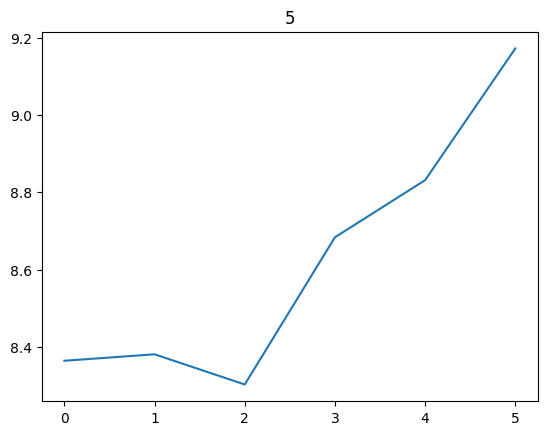

target act 1


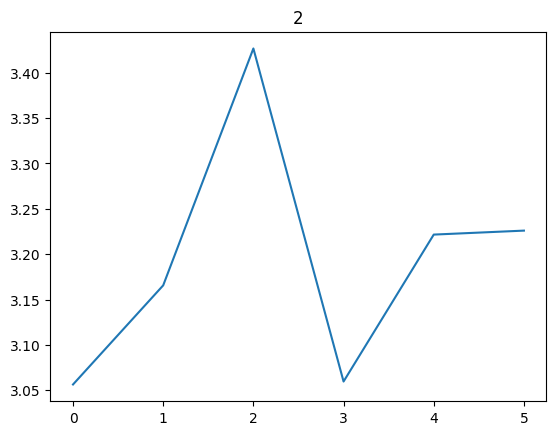

target act 1


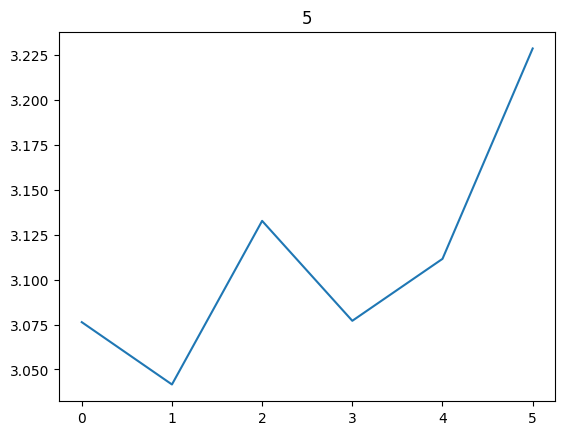

target act 1


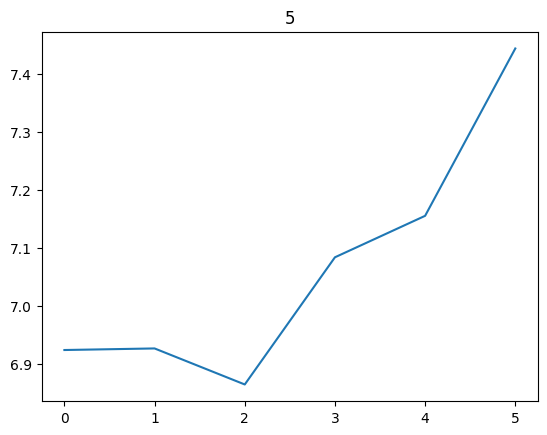

target act 2


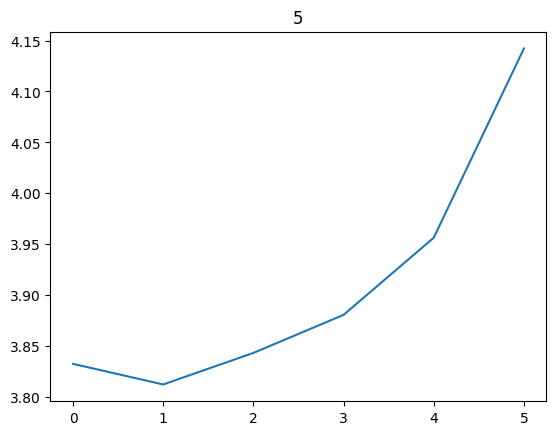

target act 5


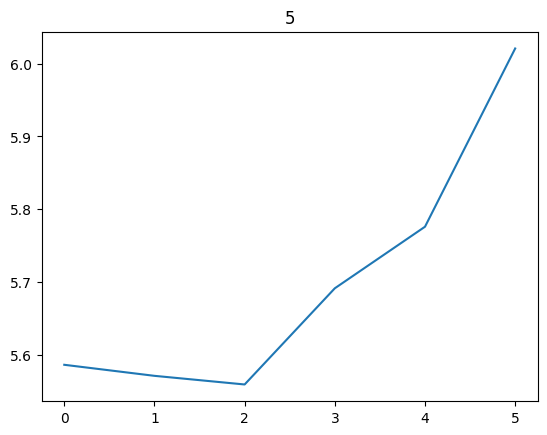

target act 5


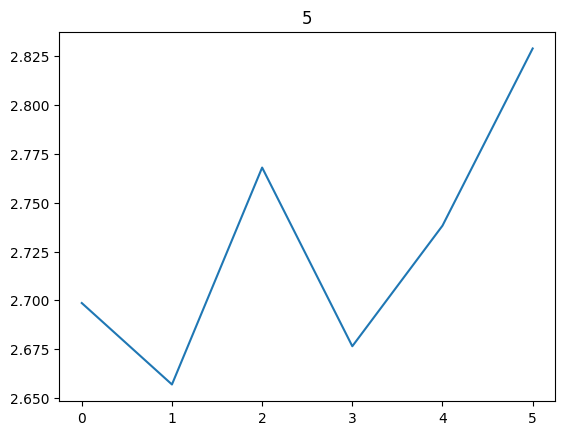

target act 2


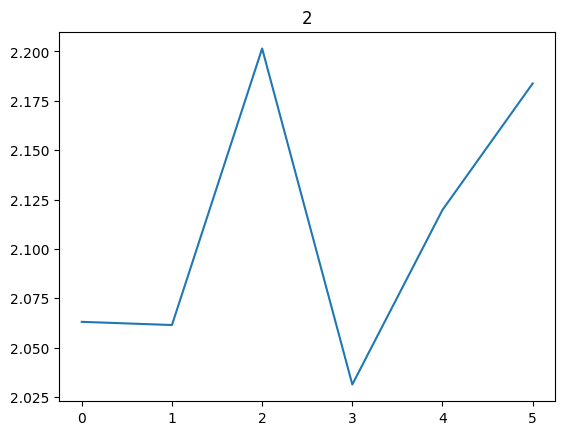

target act 4


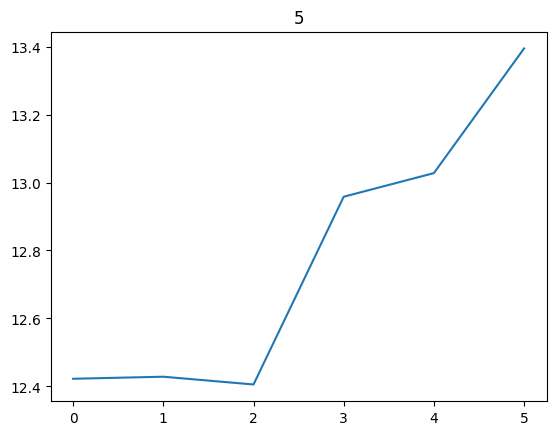

target act 3


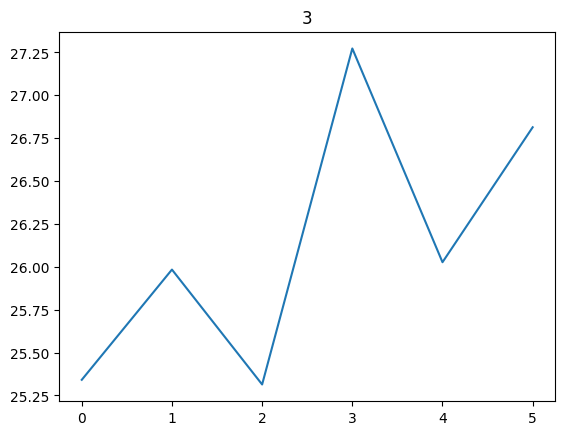

target act 2


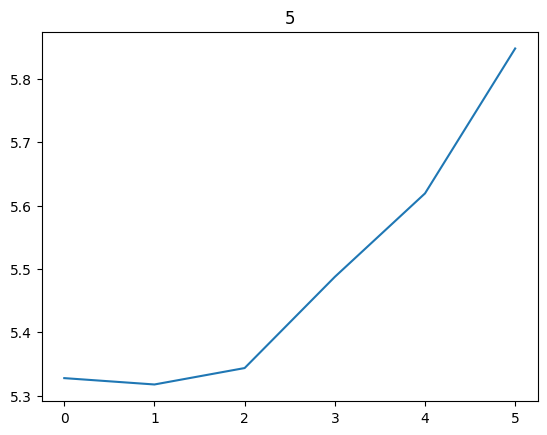

target act 3


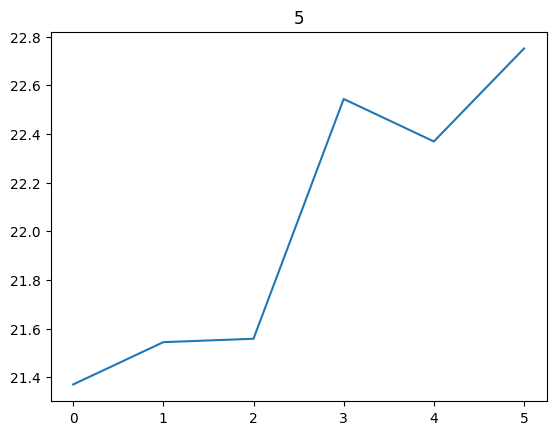

target act 0


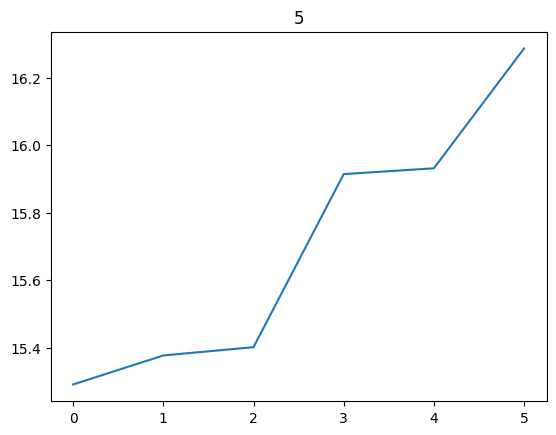

target act 4


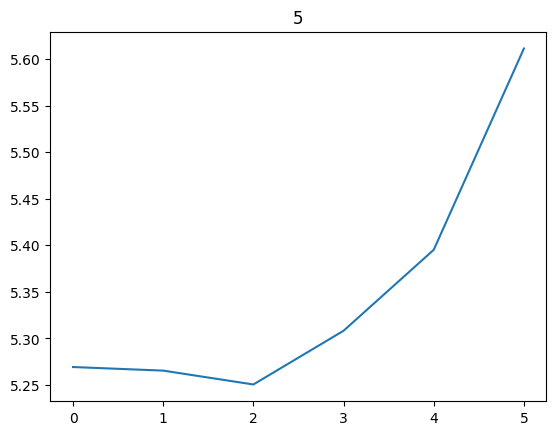

target act 3


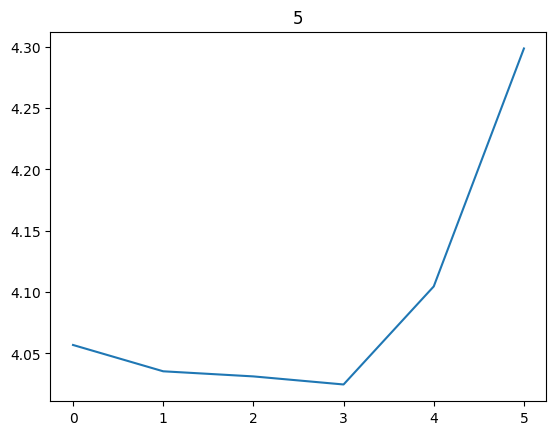

target act 4


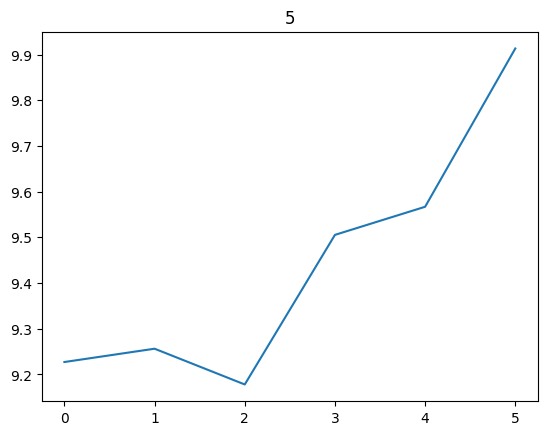

target act 4


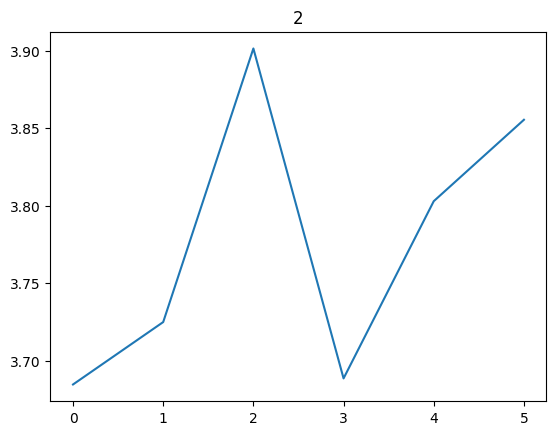

target act 2


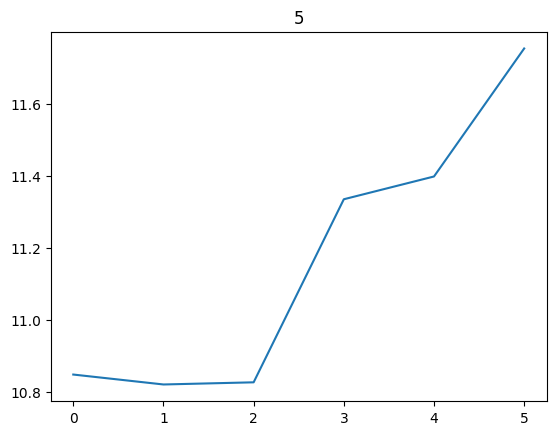

target act 4


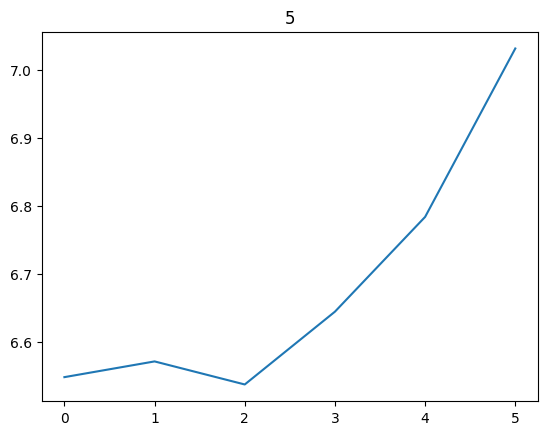

target act 5


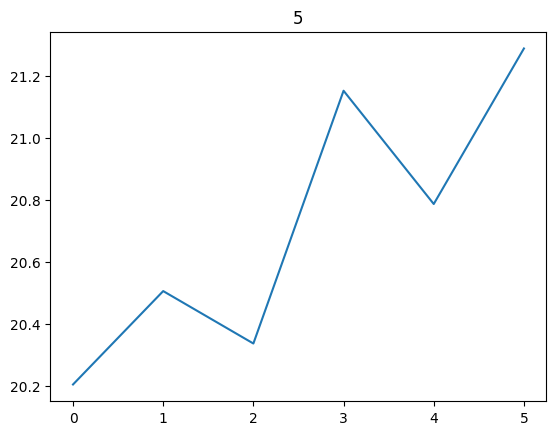

target act 4


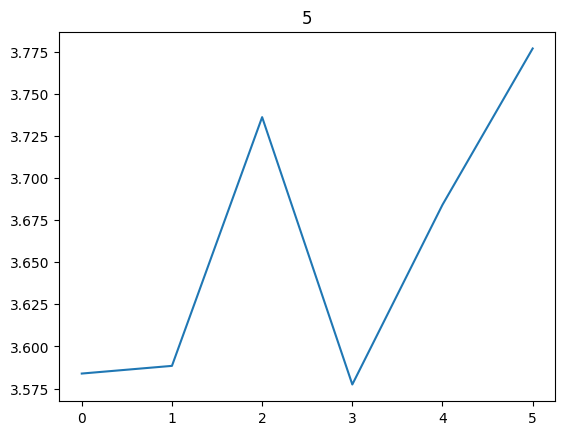

target act 3


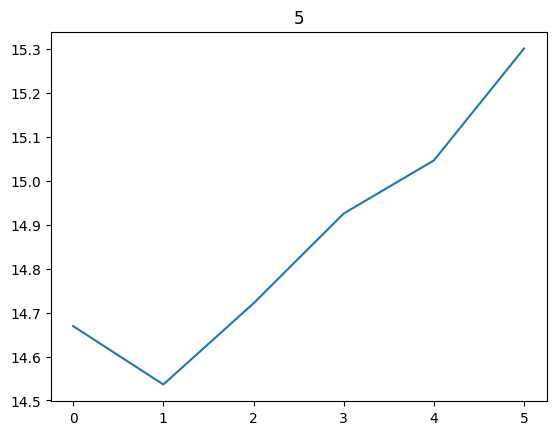

target act 5


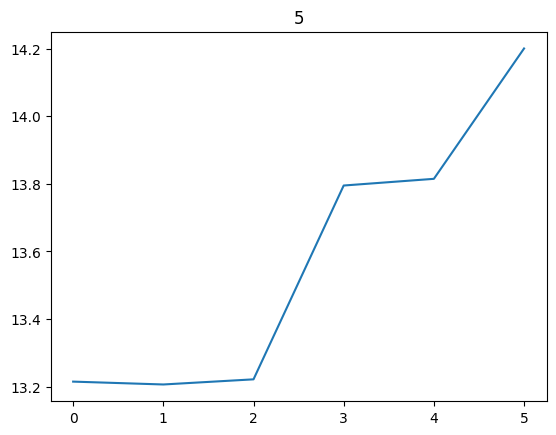

target act 1


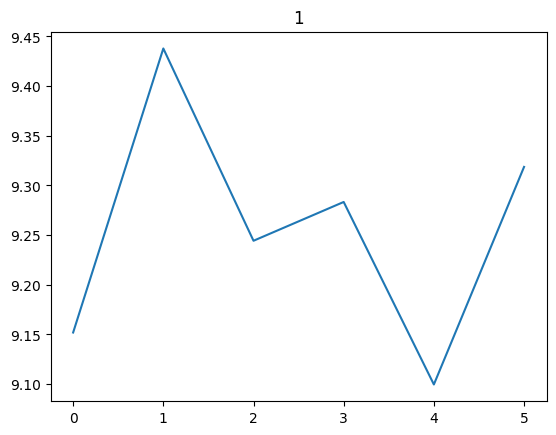

target act 4


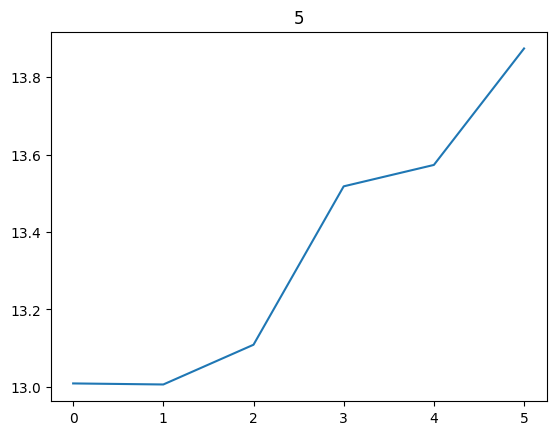

target act 5


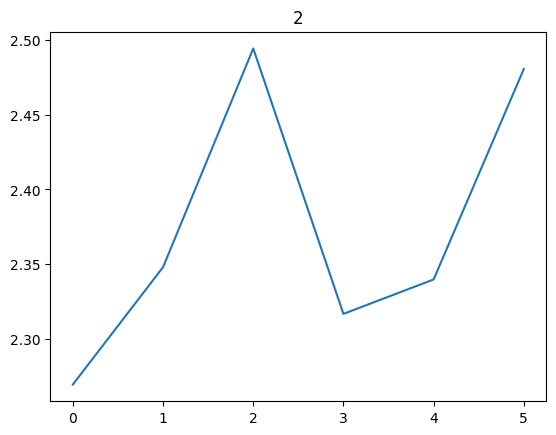

target act 5


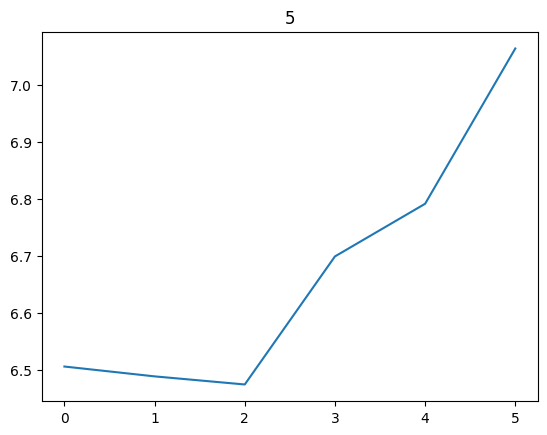

target act 3


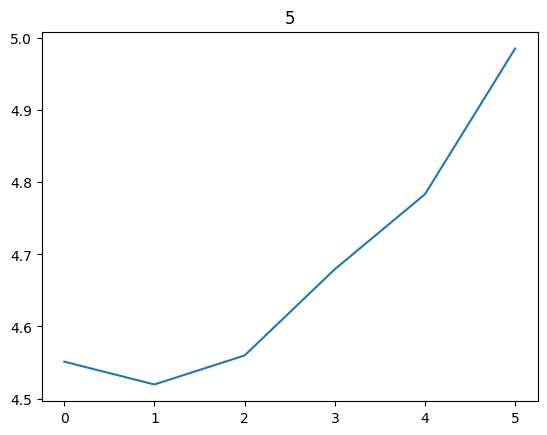

target act 3


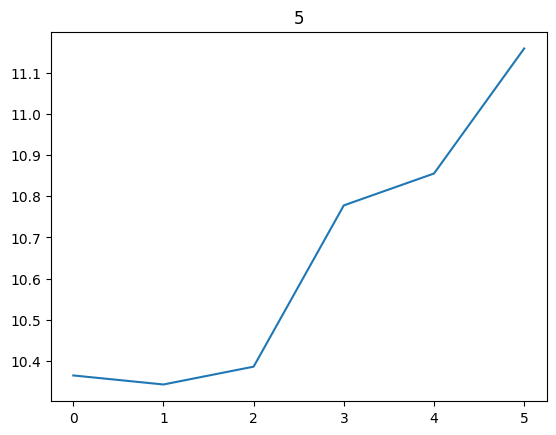

target act 4


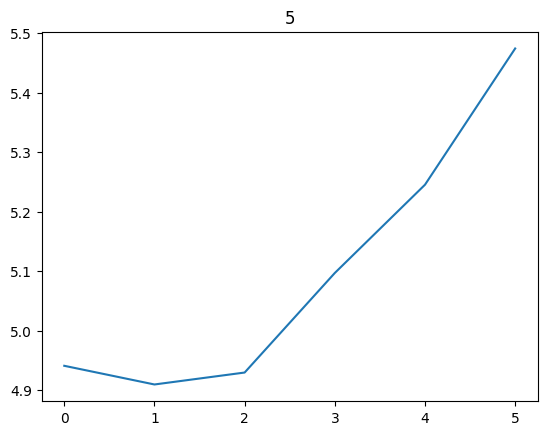

target act 3


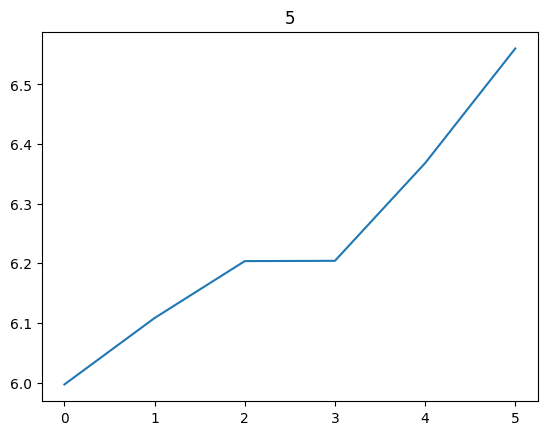

target act 1


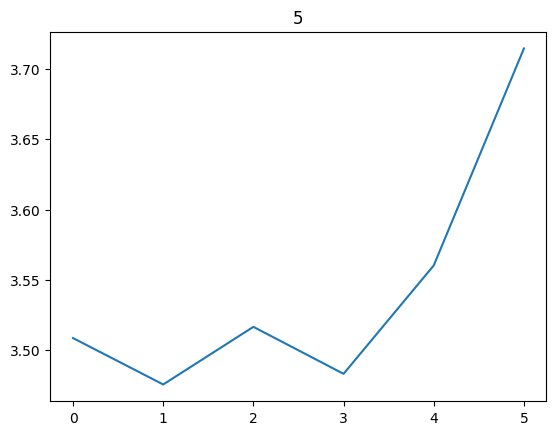

target act 5


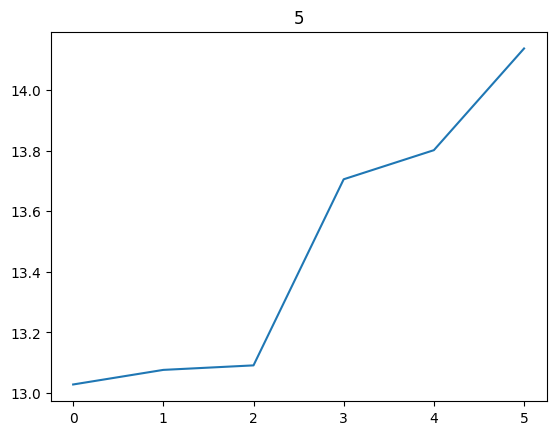

target act 5


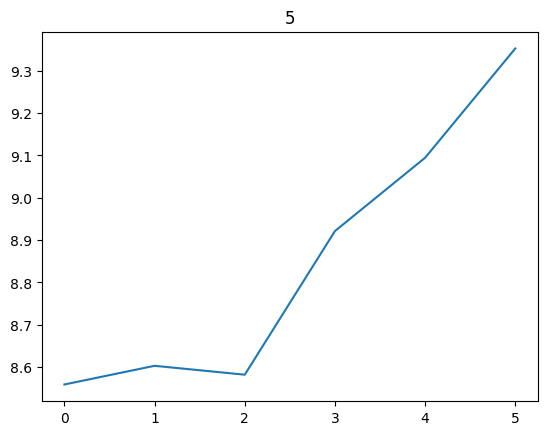

target act 5


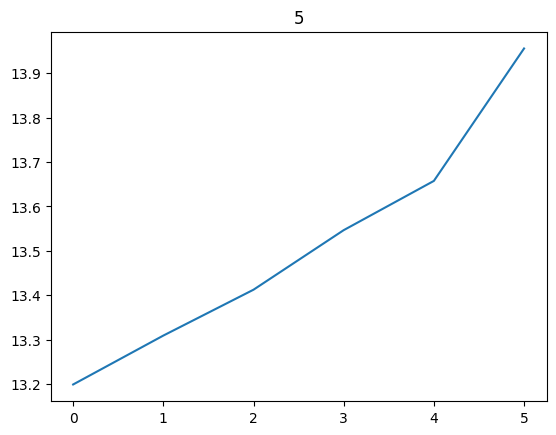

target act 0


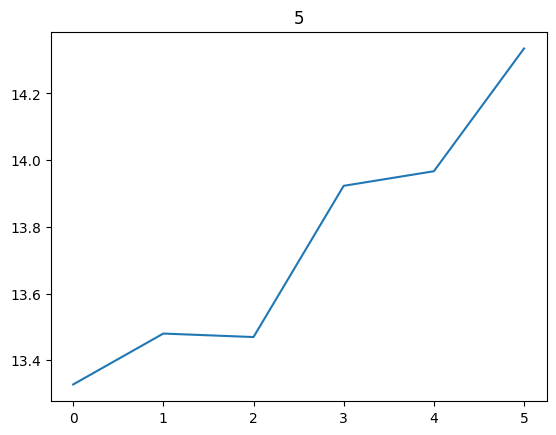

target act 2


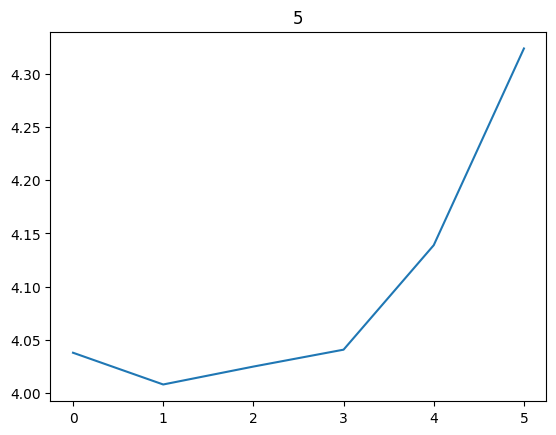

target act 4


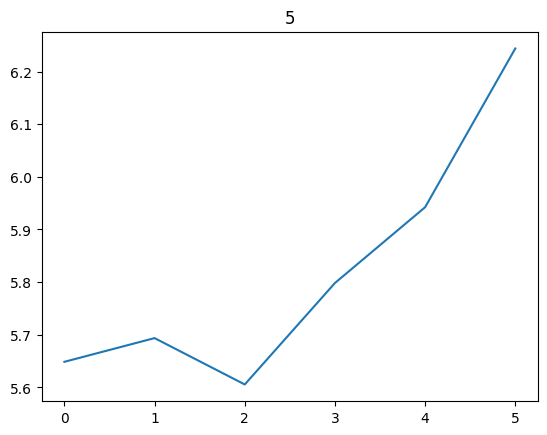

target act 5


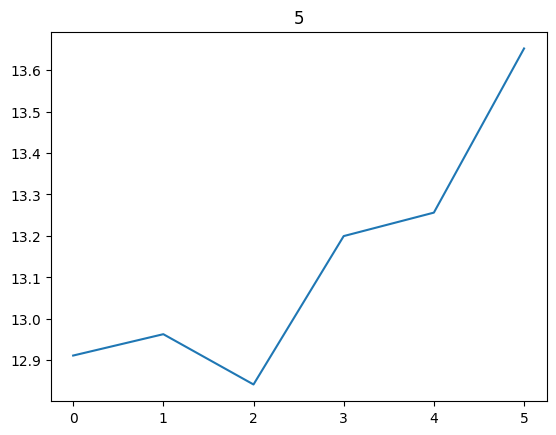

target act 1


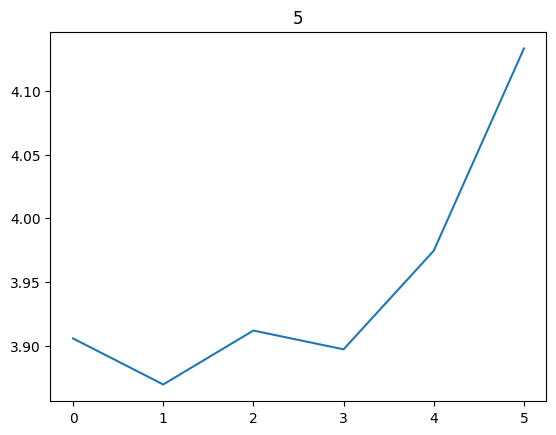

target act 4


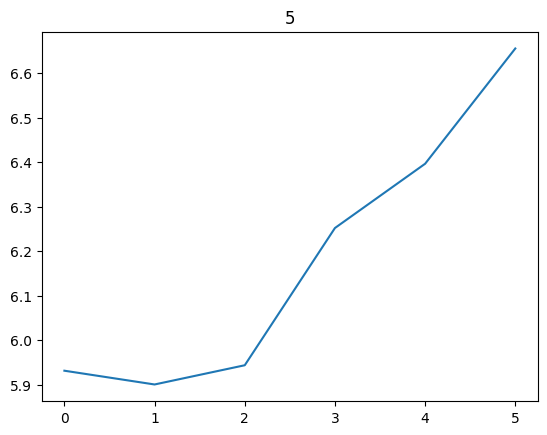

target act 4


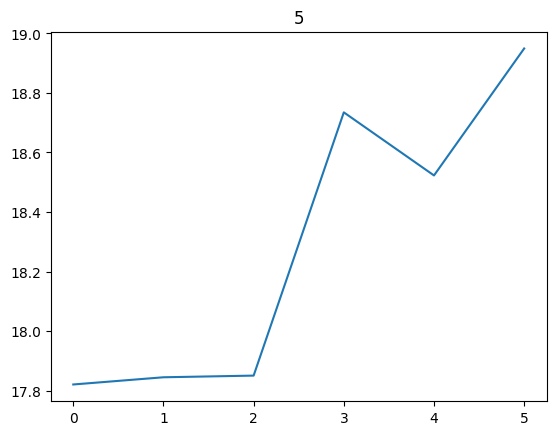

target act 1


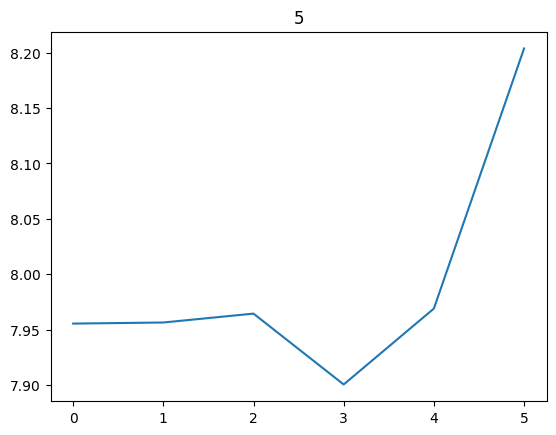

target act 4


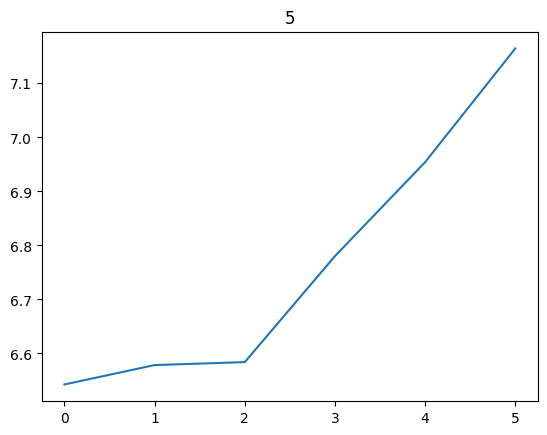

target act 4


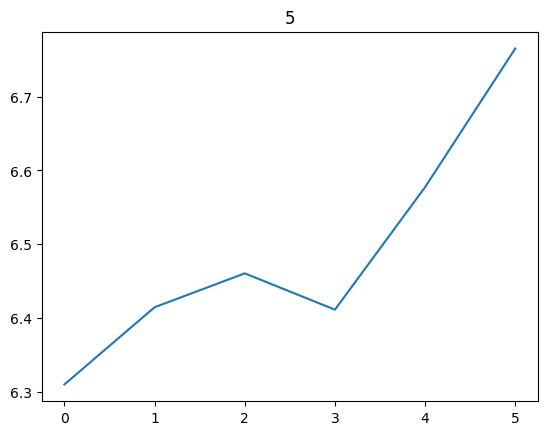

target act 0


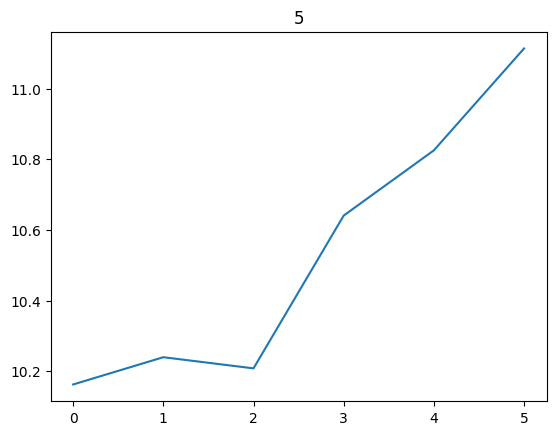

target act 5


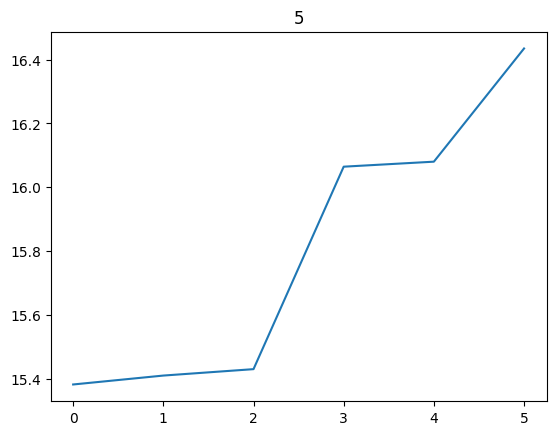

target act 3


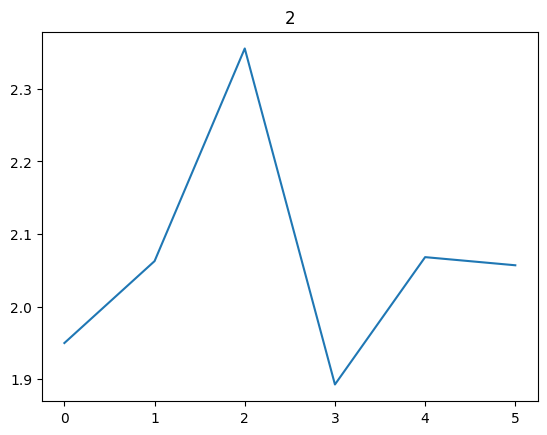

target act 5


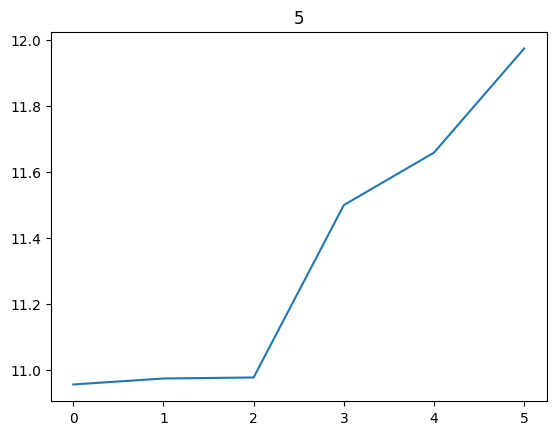

target act 5


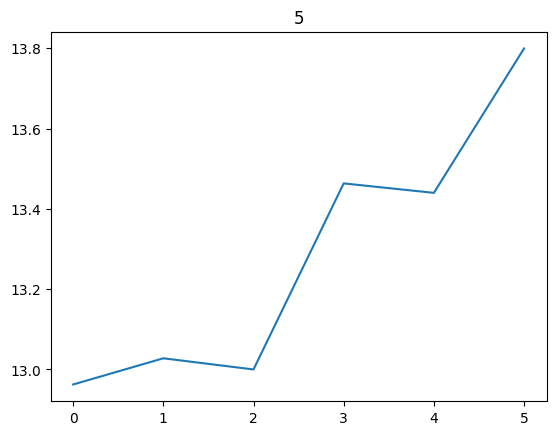

target act 3


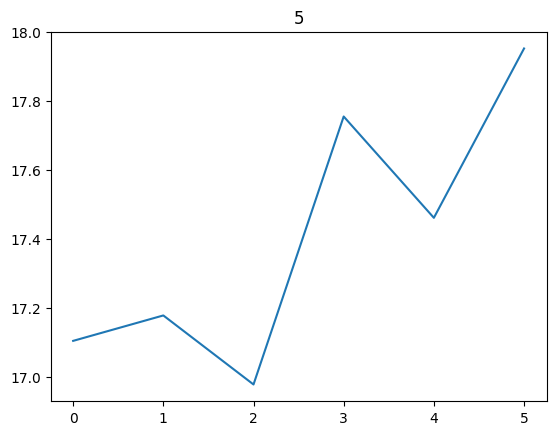

target act 3


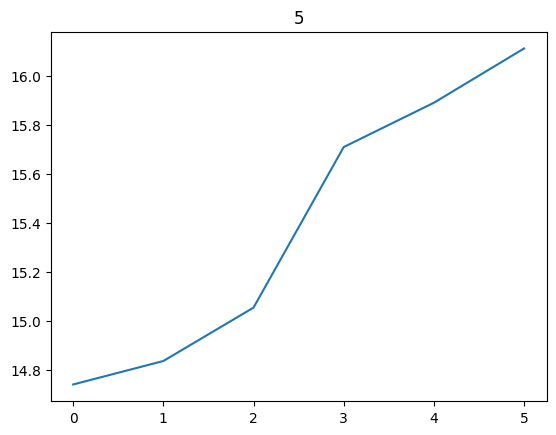

target act 0


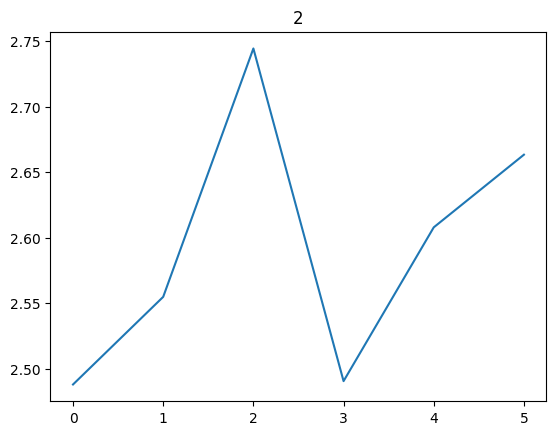

target act 1


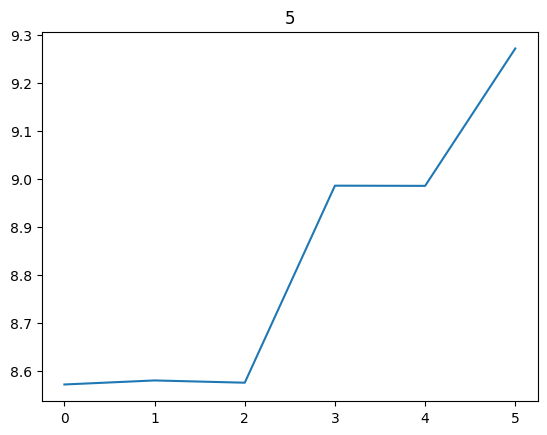

target act 0


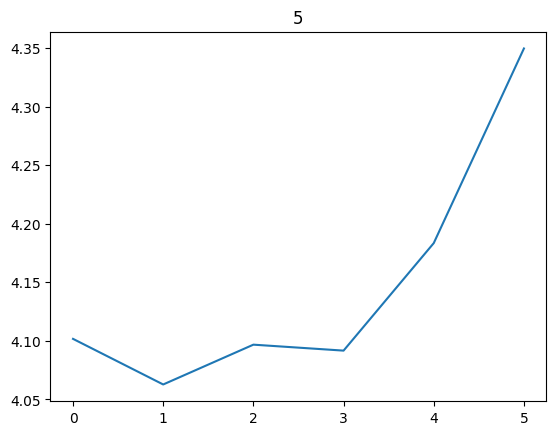

target act 0


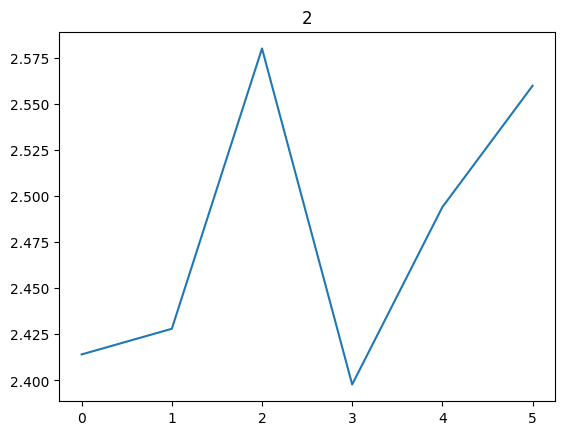

target act 4


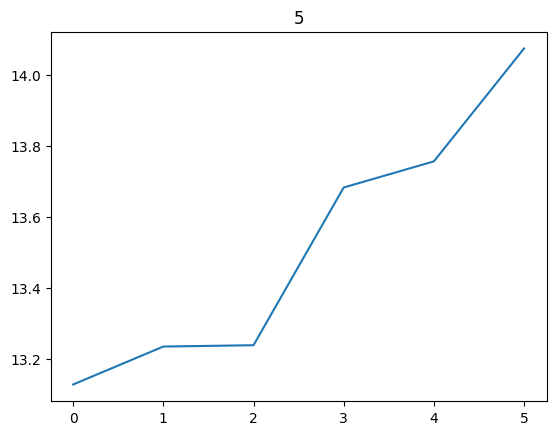

target act 1


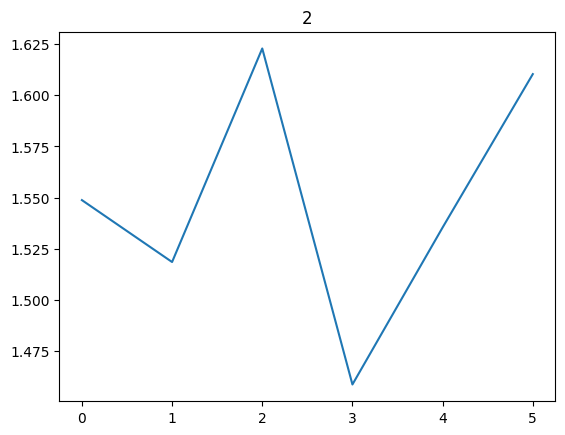

target act 3


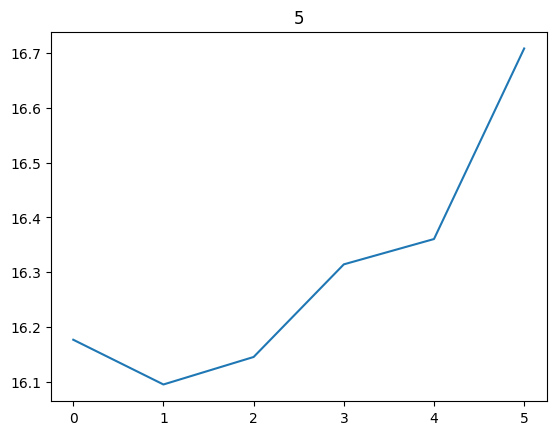

target act 5


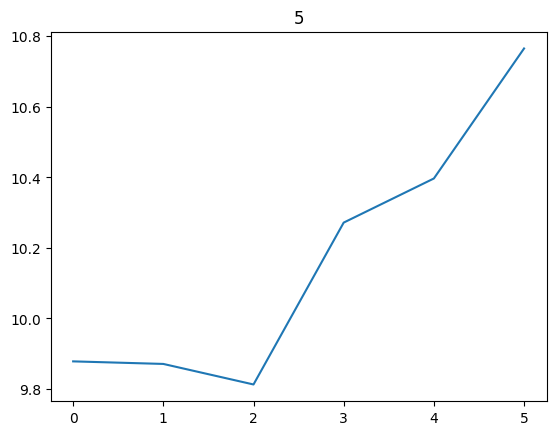

target act 5


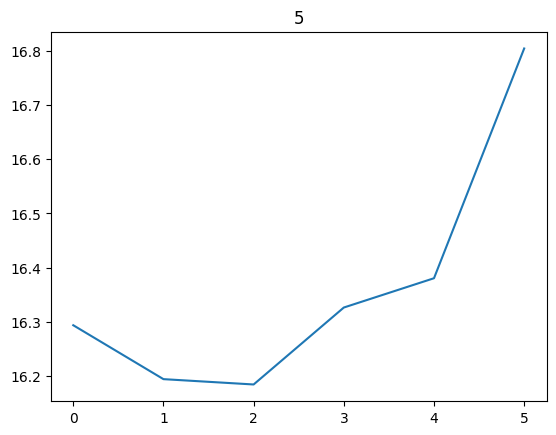

target act 4


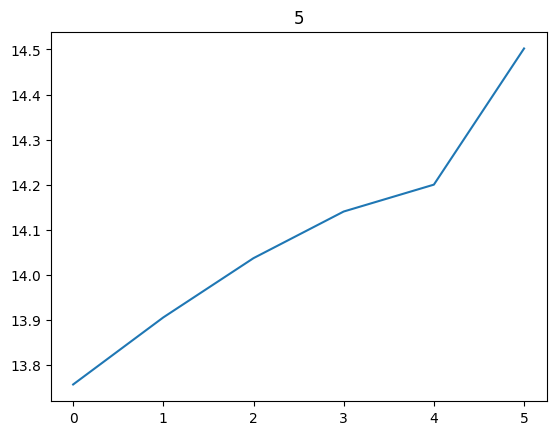

target act 3


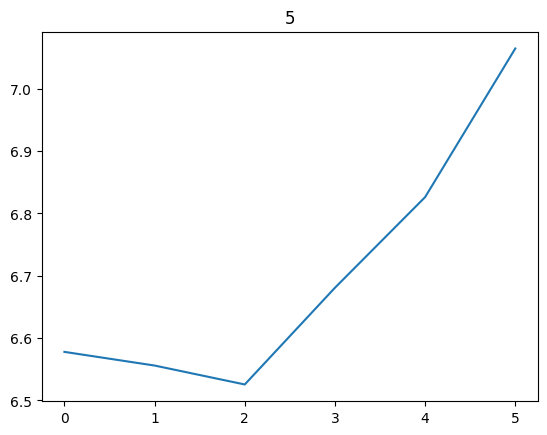

target act 2


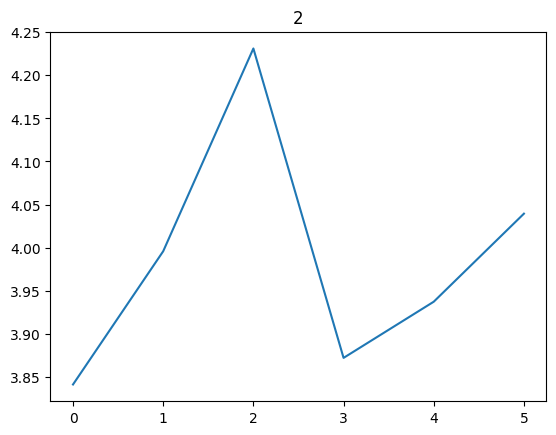

target act 2


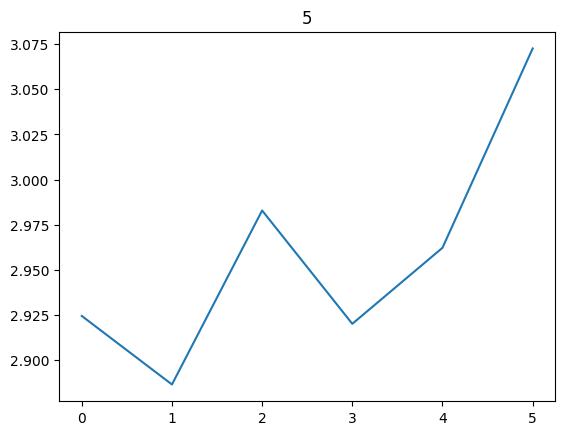

target act 3


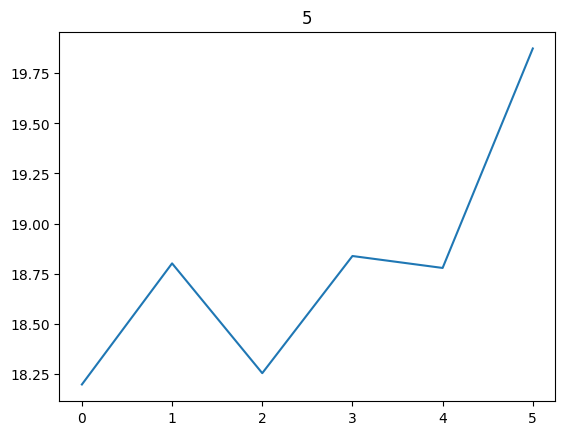

target act 5


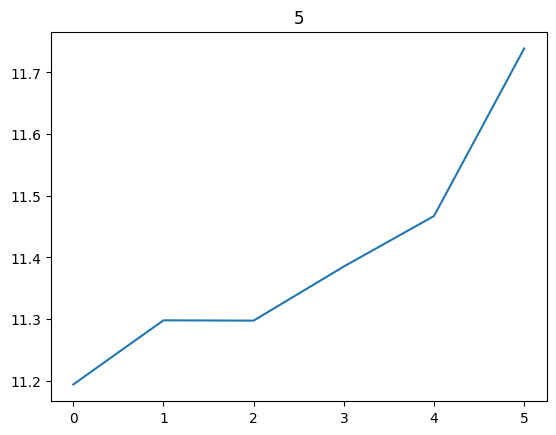

target act 5


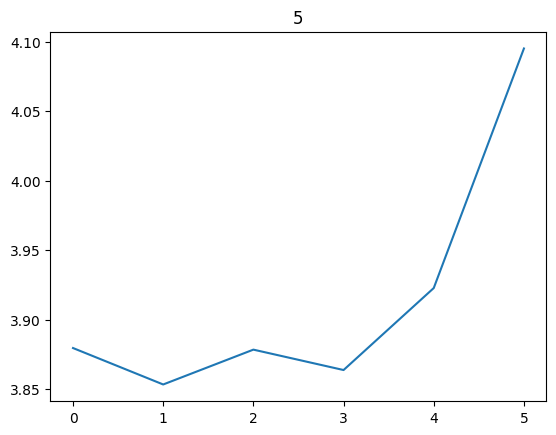

target act 1


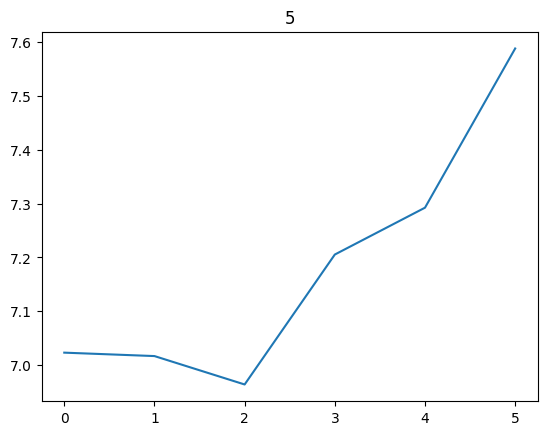

target act 5


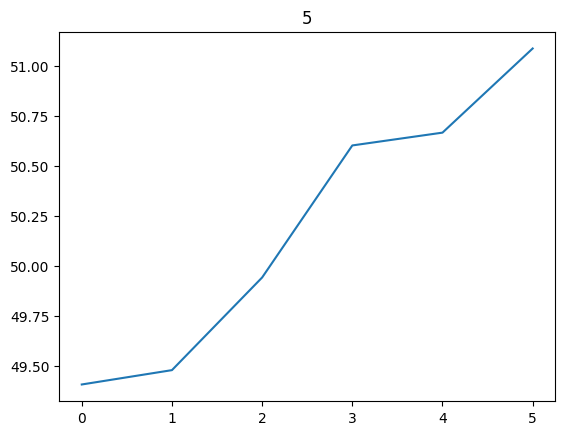

target act 3


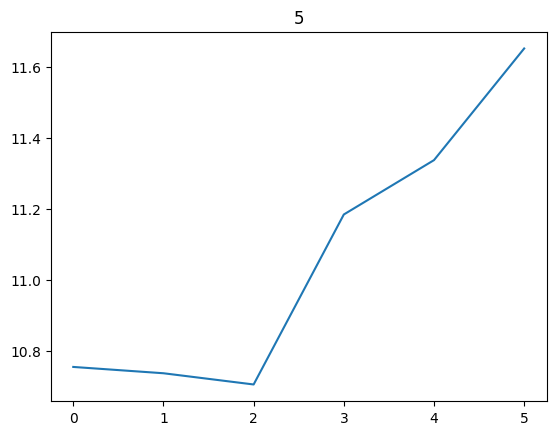

target act 5


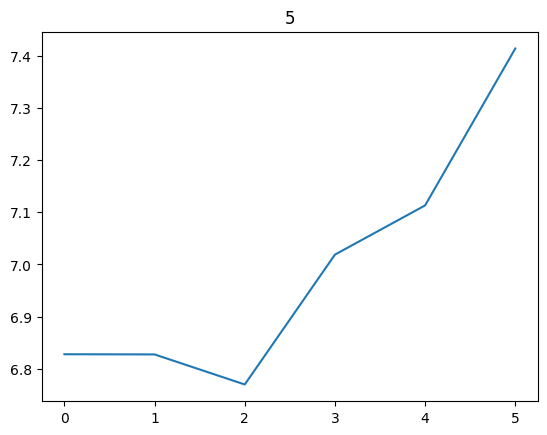

target act 0


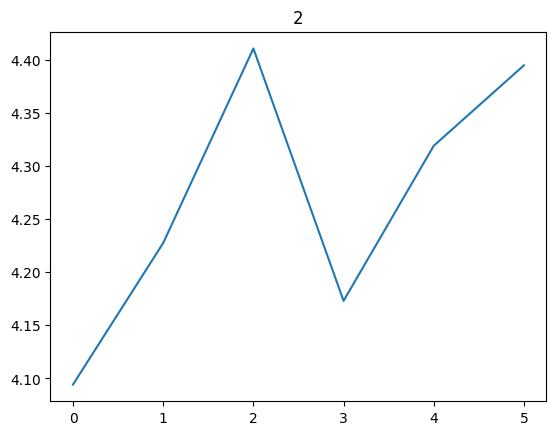

target act 2


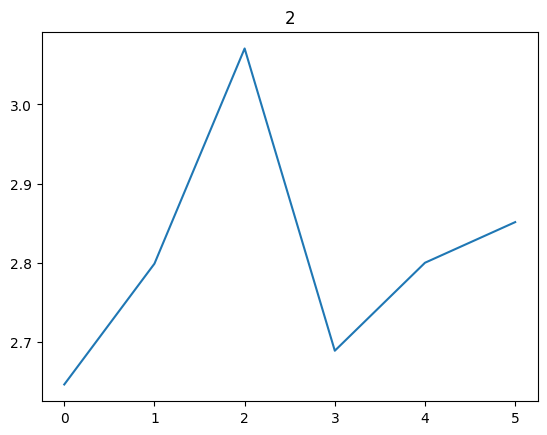

target act 5


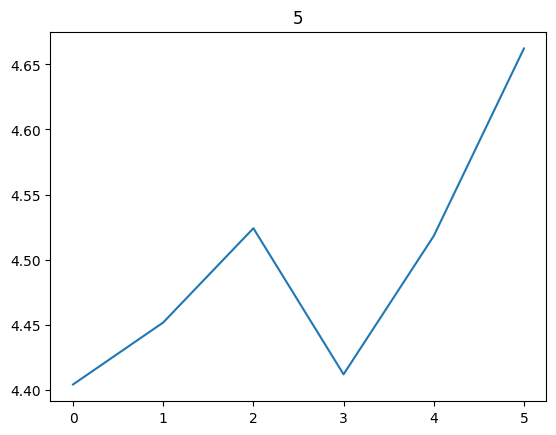

target act 4


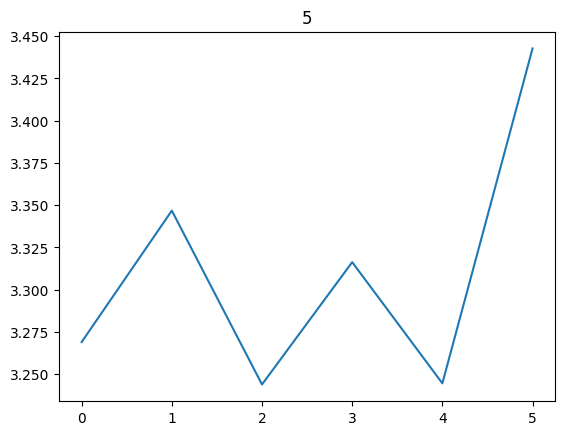

target act 5


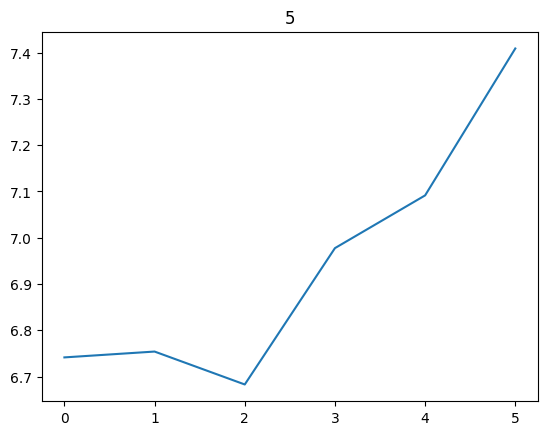

target act 3


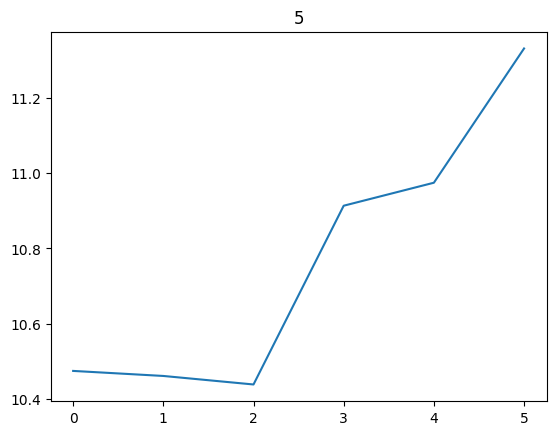

target act 5


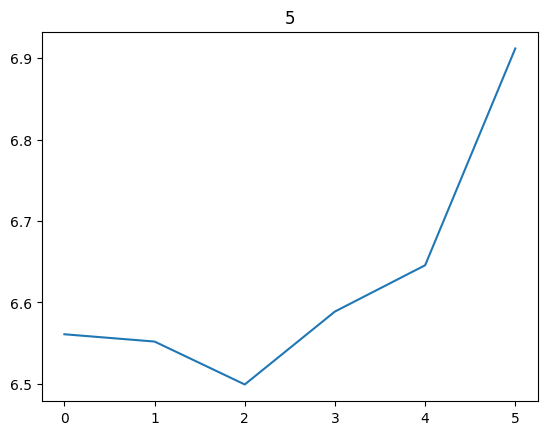

target act 2


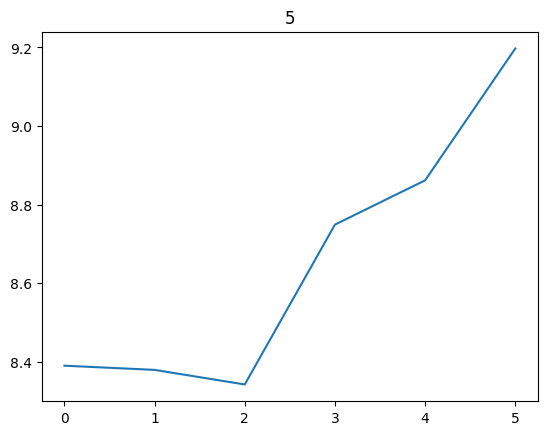

target act 3


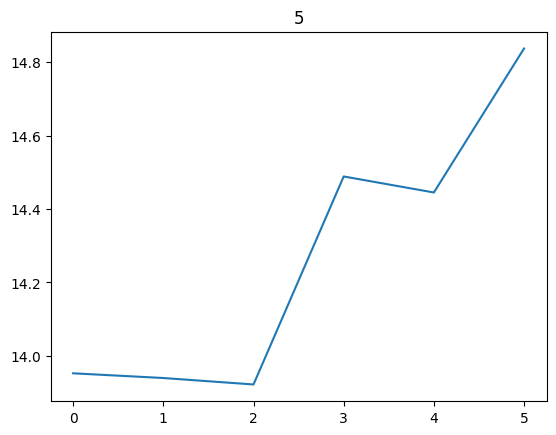

target act 4


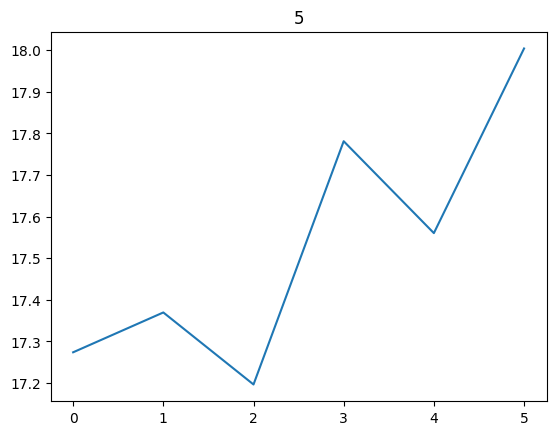

target act 4


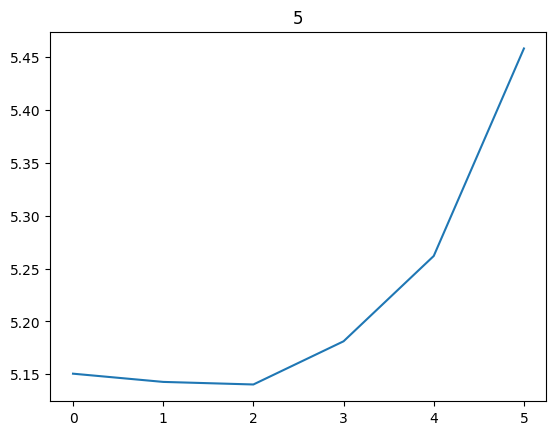

target act 3


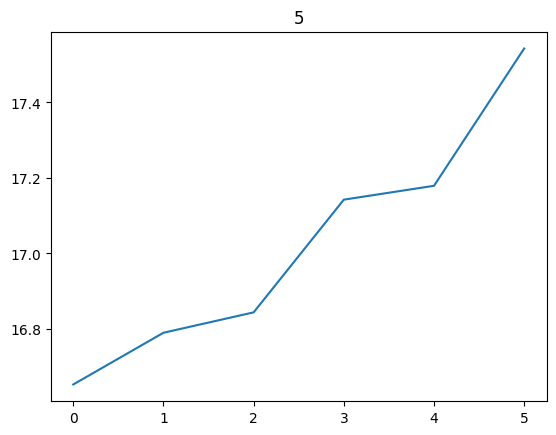

target act 1


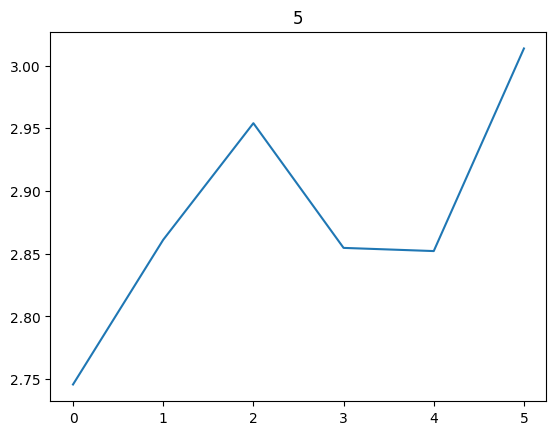

target act 2


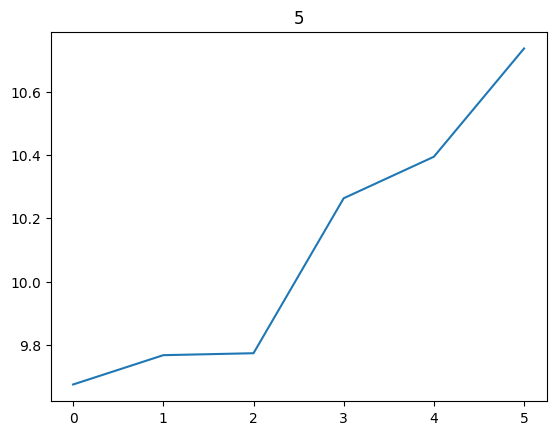

target act 5


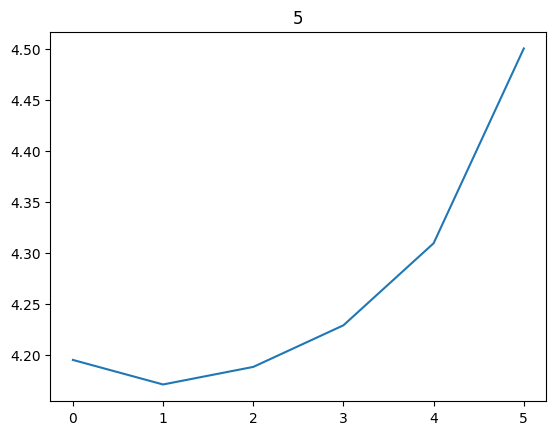

target act 2


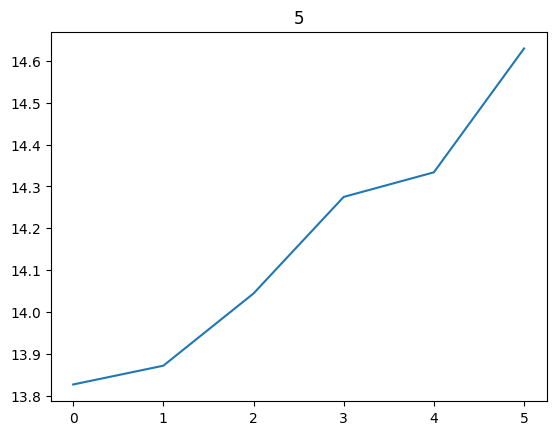

target act 2


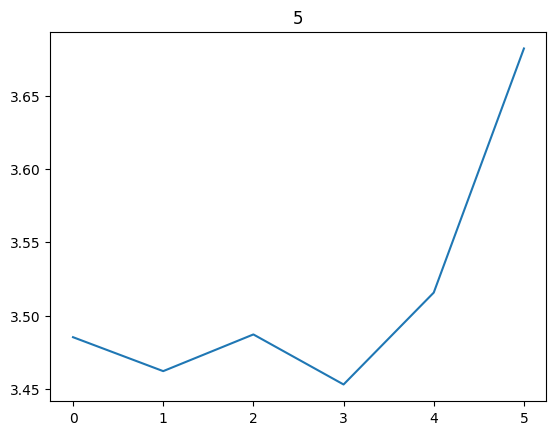

target act 4


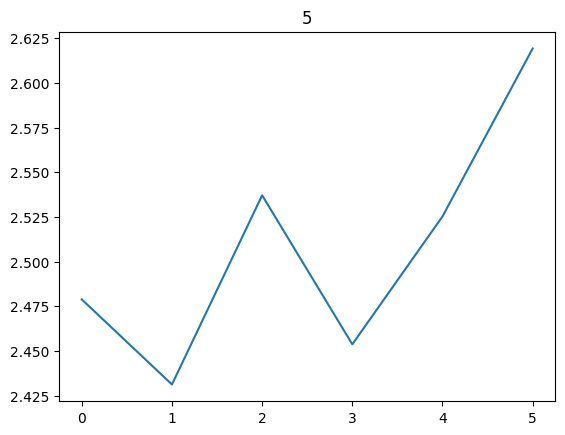

target act 3


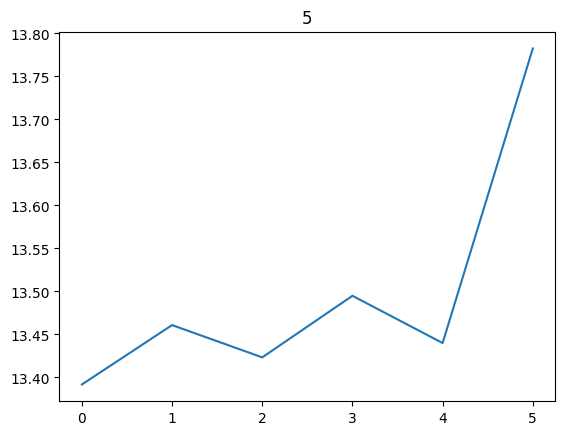

target act 4


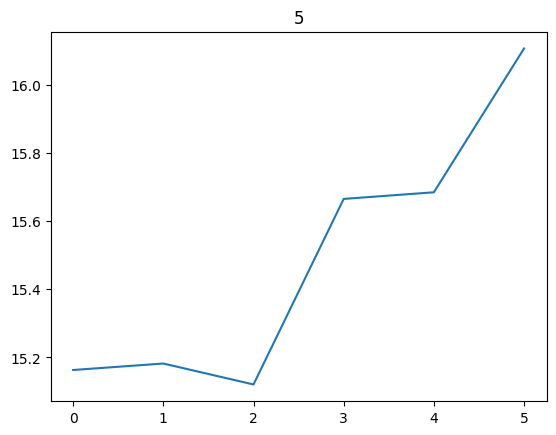

target act 3


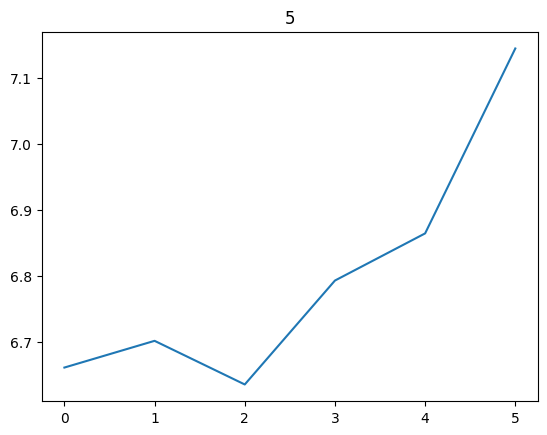

target act 4


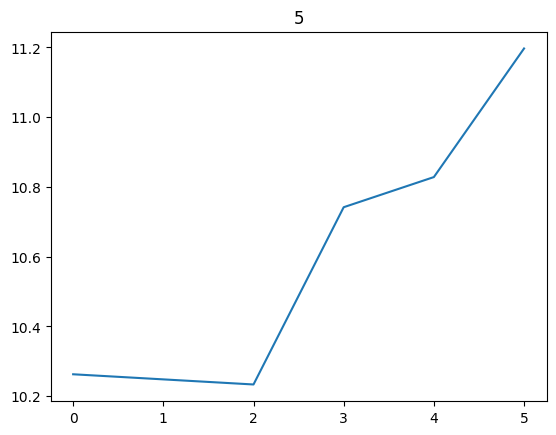

target act 1


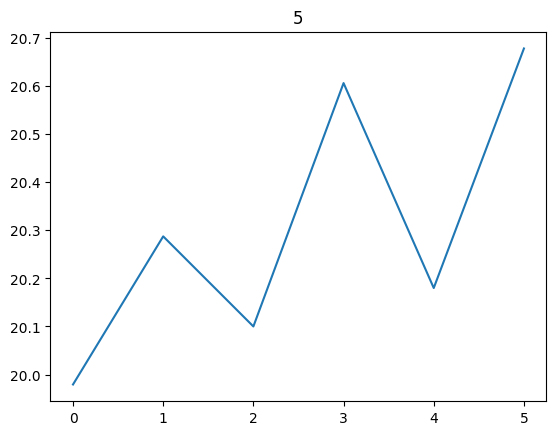

target act 4


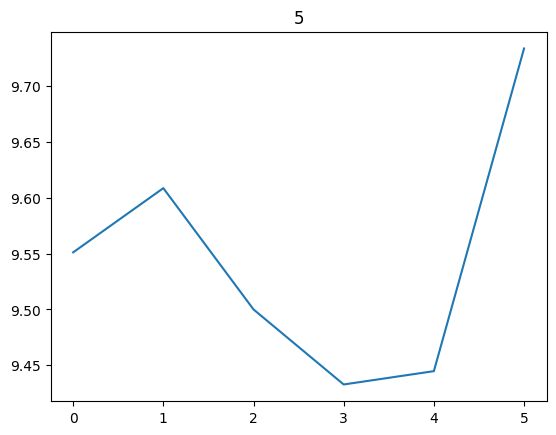

target act 3


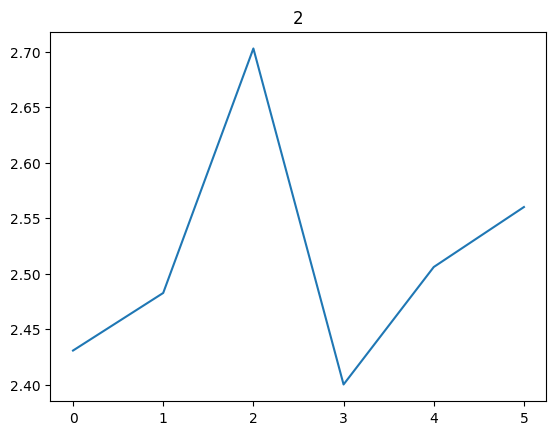

target act 4


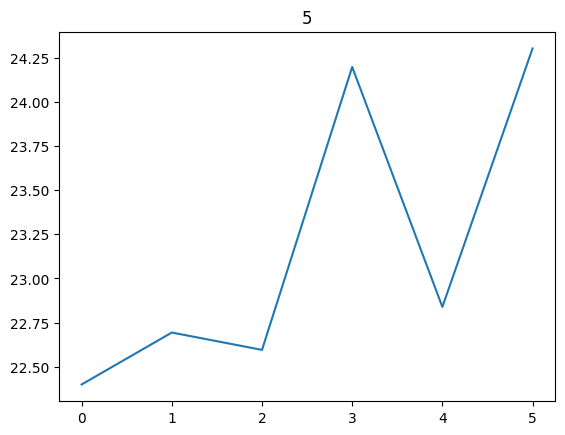

target act 4


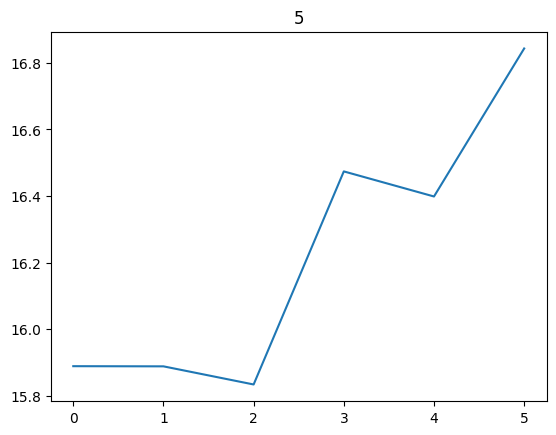

target act 5


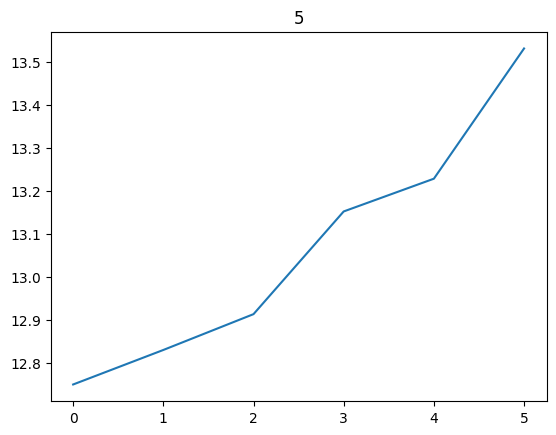

target act 2


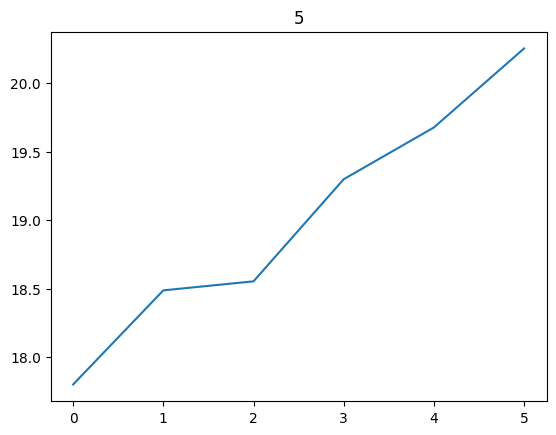

target act 3


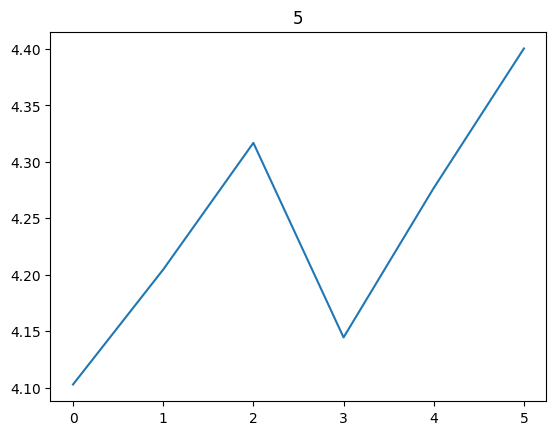

target act 1


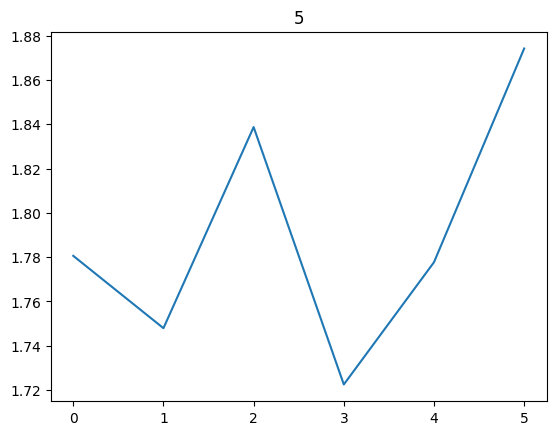

target act 5


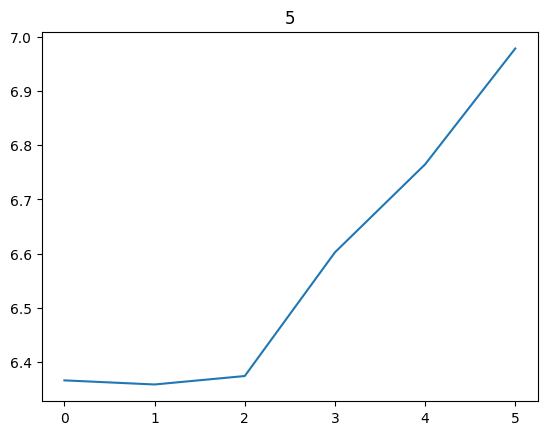

target act 4


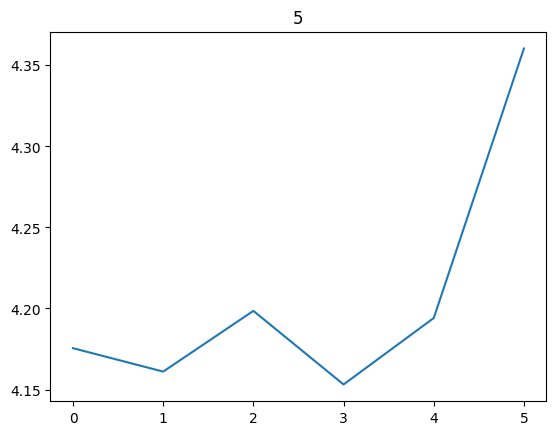

target act 5


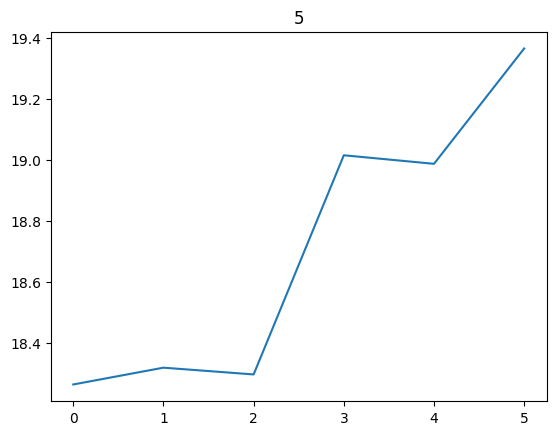

target act 5


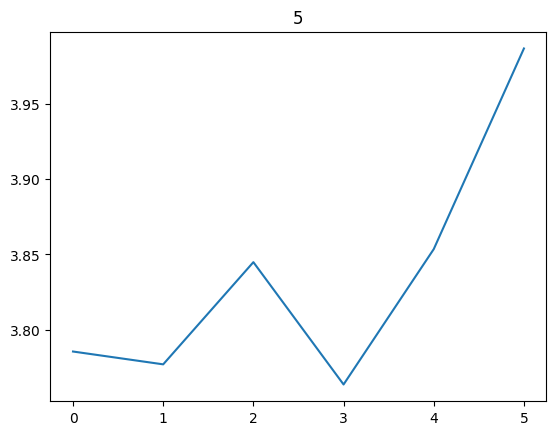

target act 4


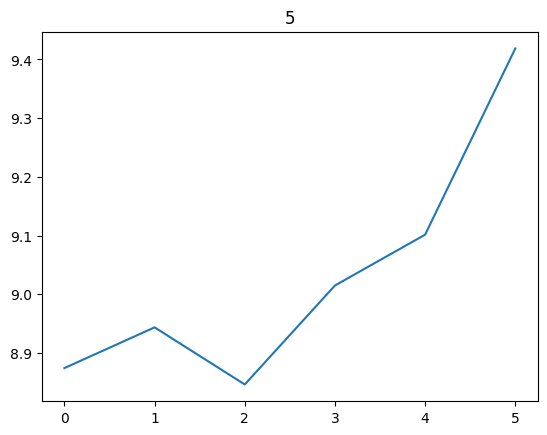

target act 3


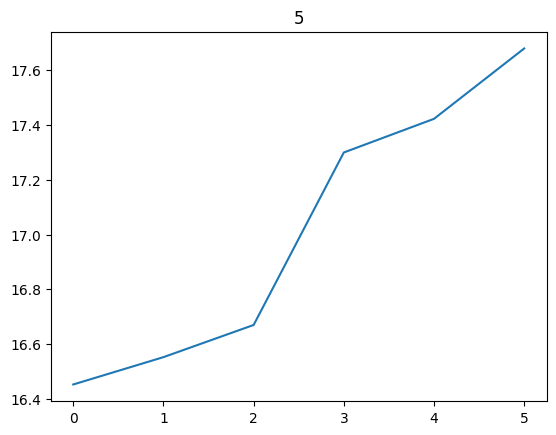

target act 0


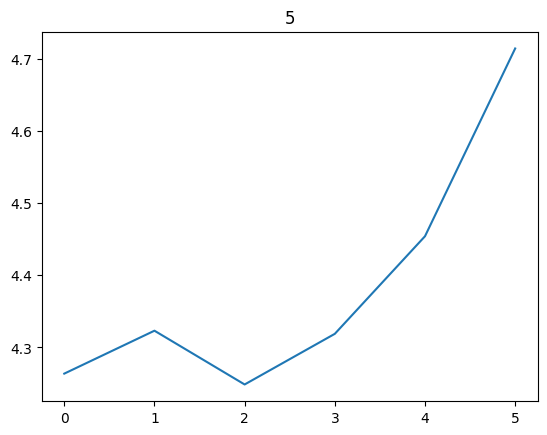

target act 5


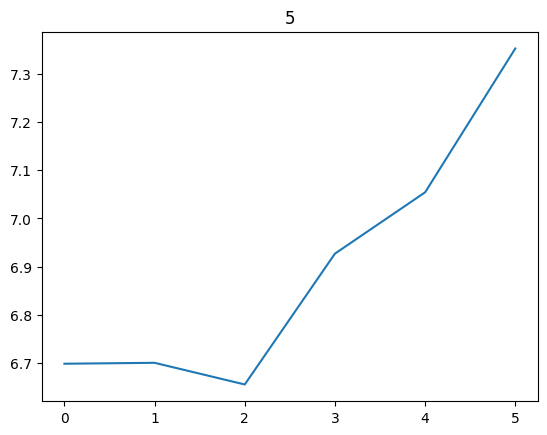

target act 4


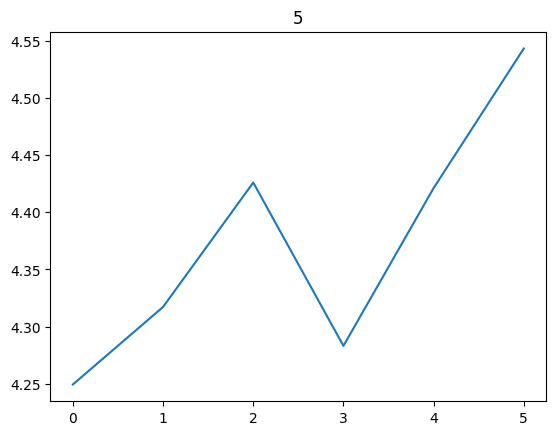

target act 3


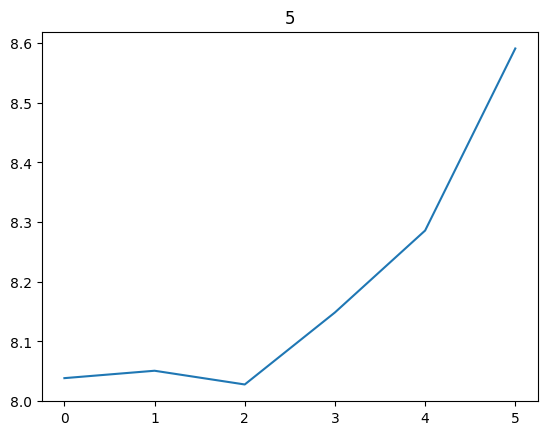

target act 1


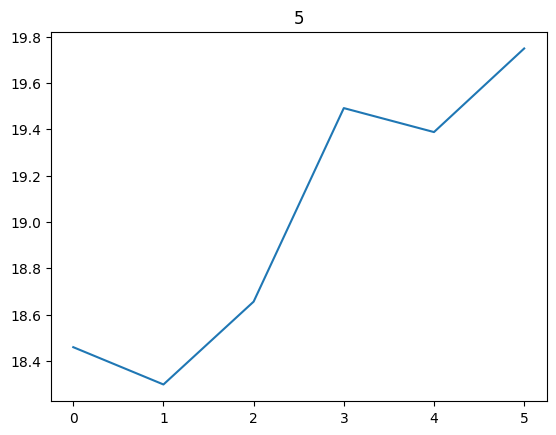

target act 4


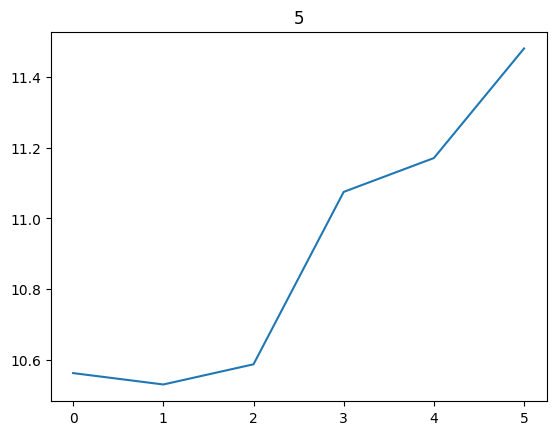

target act 0


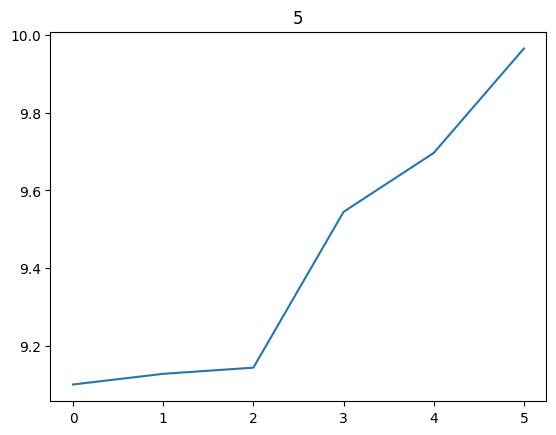

target act 0


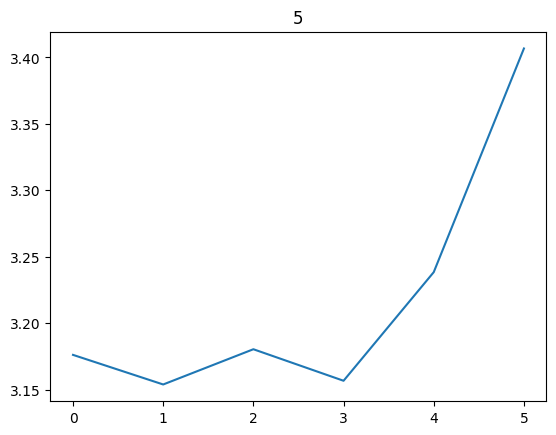

target act 3


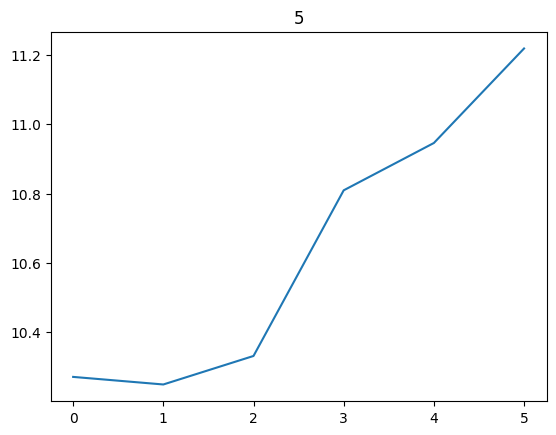

target act 4


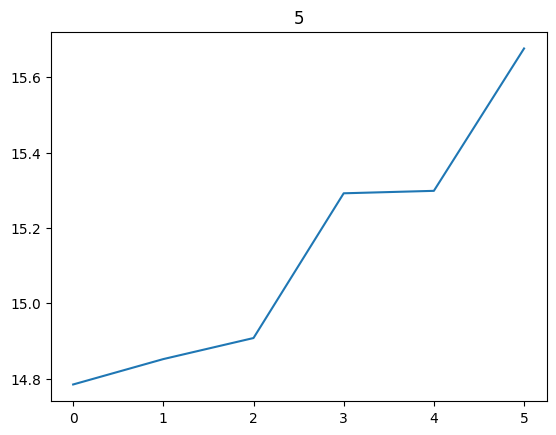

target act 5


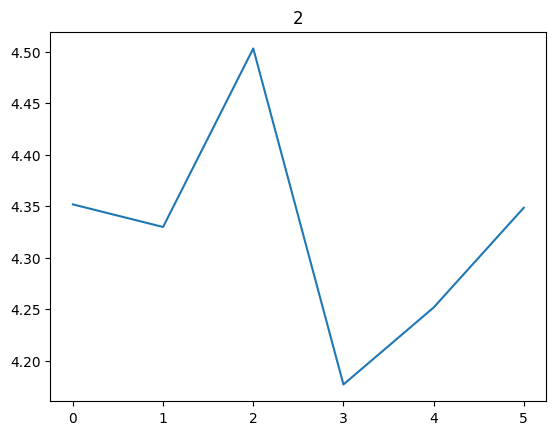

target act 5


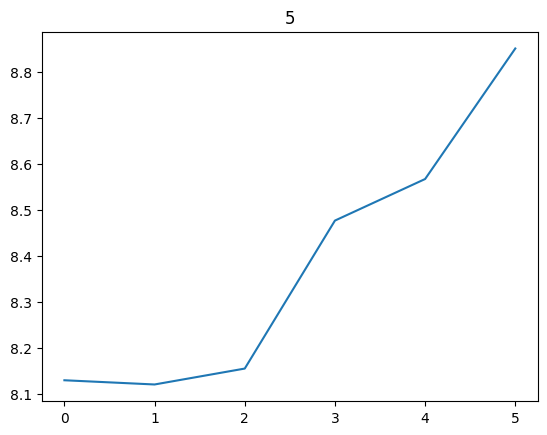

target act 5


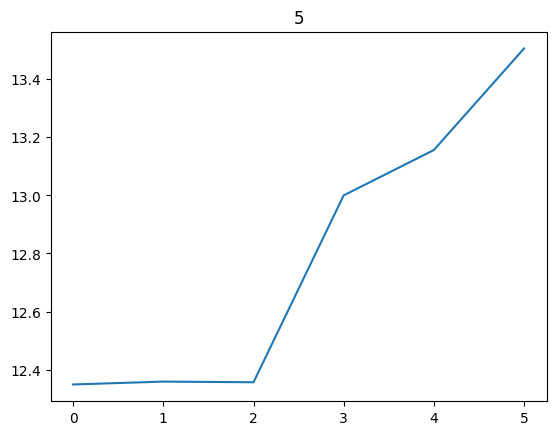

target act 5


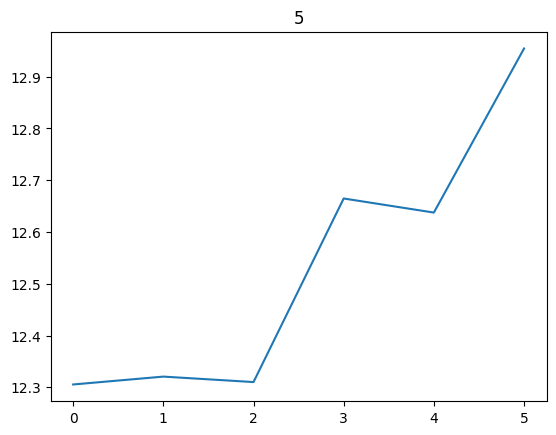

target act 5


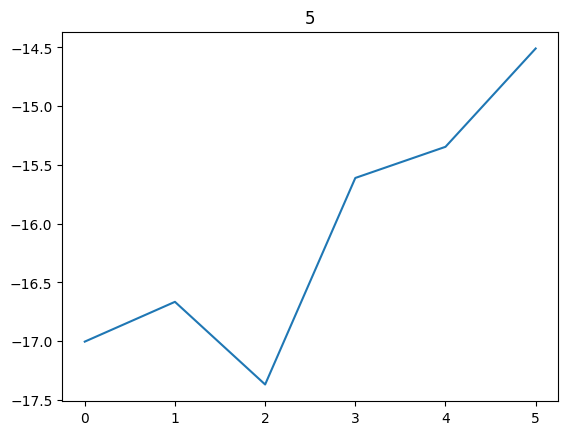

target act 2


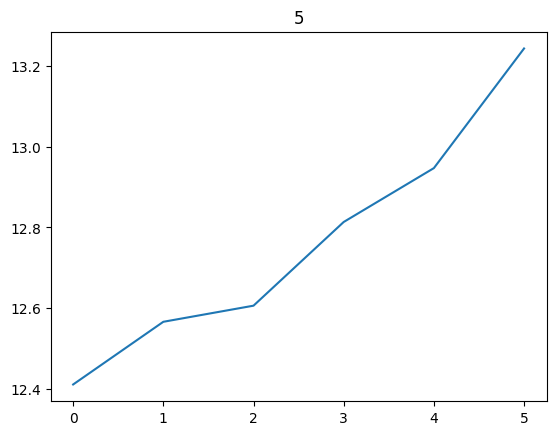

target act 4


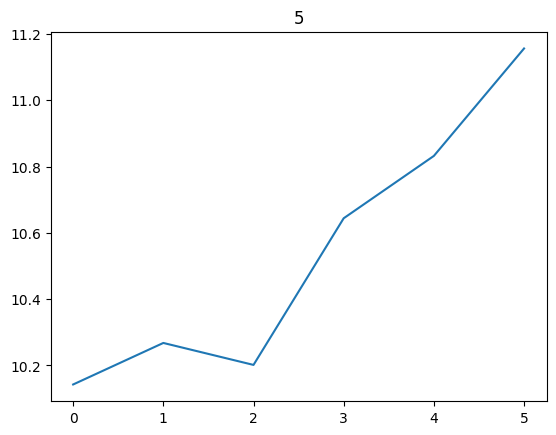

target act 4


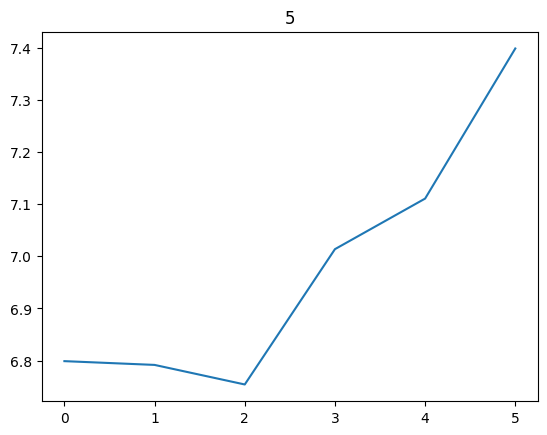

target act 5


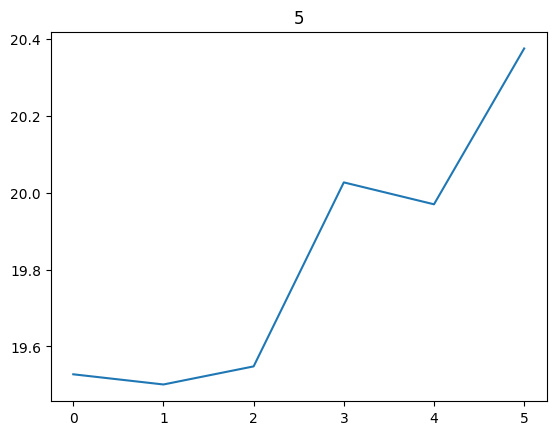

target act 0


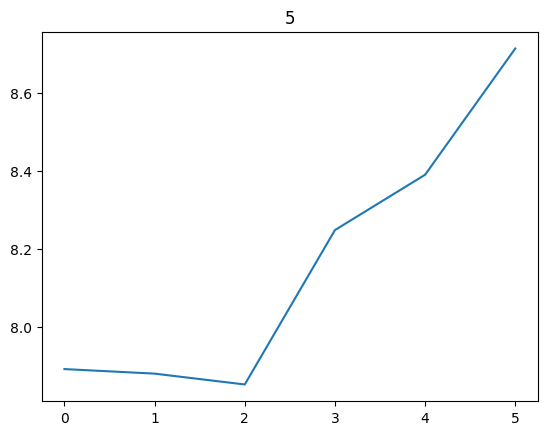

target act 0


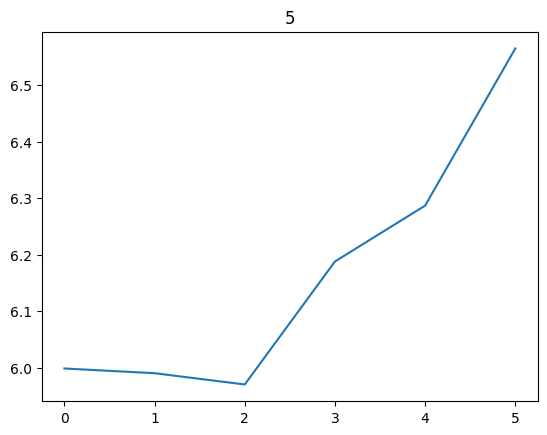

target act 0


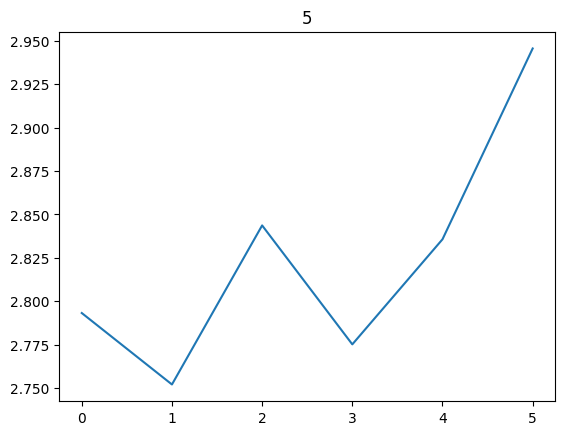

In [434]:
for batch_idx, experience in enumerate(dataloader):
    states, actions, rewards, next_states, dones = experience
    states = states.to(device)
    actions = actions.to(device)
    rewards = rewards.to(device)
    next_states = next_states.to(device)
    dones = dones.to(device)
    for idx in range(states.shape[0]): 
#         print('Q', agent.network(torch.from_numpy().float().unsqueeze(0).to(device)) 
#         if actions[idx].item() != 2:
#             continue
        print('target act', actions[idx].item())
        getQ(agent, states.cpu().numpy()[idx])
#         print('idx', idx, 'action', agent.get_action(state=states.cpu().numpy()[idx], epsilon=0), 'target action', 
#               actions.cpu().numpy()[idx])
    if batch_idx > 10:
        break
    

In [30]:
'''
action和阈值的关系
0.003, 'a' = 0
0.161, 'a' = 1
0.412, 'a' = 2
0.992, 'a' = 3
1.583, 'a' = 4
2.210, 'a' = 5
'''

"\naction和阈值的关系\n0.003, 'a' = 0\n0.161, 'a' = 1\n0.412, 'a' = 2\n0.992, 'a' = 3\n1.583, 'a' = 4\n2.210, 'a' = 5\n"

In [83]:
import tornado.web
import json
import asyncio

In [84]:
class predict(tornado.web.RequestHandler):
    def initialize(self):
        self.set_header("Content-Type", "application/json")

    async def post(self):
        data = json.loads(self.request.body)
        print("Predicting...,data:",data)
        try:
            features = np.array([data['coordstream_driver_empty_minute_uniquecnt_10'],data['engine_dispatch_broatcast_cnt_5'],0,0,0,0,0,0,0,0,0])
            print("=======features=======",len(features),features)
            prediction = agent.get_action(state=features, epsilon=0.1)
            print("prediction",int(prediction[0]))
            resp_data = {
                "prediction": int(prediction[0])}
            self.write(json.dumps(resp_data))
        except KeyError:
            print("Key does not exist")
            self.write(json.dumps({"prediction": "-1"}))


def make_app():
    return tornado.web.Application([
        (r"/predict", predict),
    ])


async def main():
    tornado.log.enable_pretty_logging()
    app = make_app()
    app.listen(5000)
    shutdown_event = asyncio.Event()
    await shutdown_event.wait()

In [86]:
!curl -X POST -H "Content-Type: application/json" -d '{"coordstream_driver_empty_minute_uniquecnt_10": 1, "engine_dispatch_broatcast_cnt_5": 2}' http://localhost:5000/predict

{"prediction": 5}

In [311]:
feature = pd.read_csv('all_feature.txt', sep=' ', header=None)
feature_name = feature[0].values.tolist()

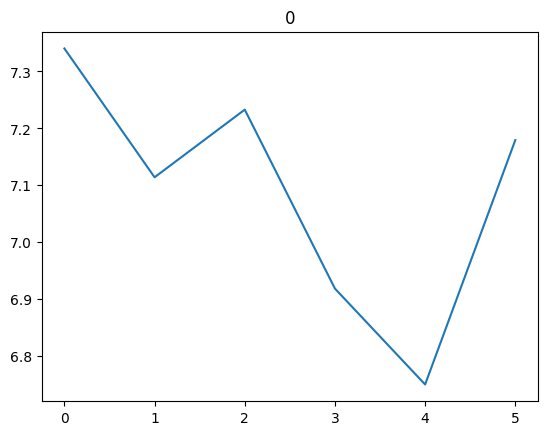

In [436]:
feature_dict = {}
for name in feature_name:
    feature_dict[name] = 0

# 想要过滤的状况，反而没有过滤，想输出5
feature_dict['waittime'] = 0
feature_dict['nearby_total_driver_num'] = 0.1
feature_dict['nearby_idle_driver_num'] = 0.1
feature_dict['nearby_grid_order_num'] = 1
feature_dict['nearby_total_order_num'] = 1

getQ(agent, np.array(list(feature_dict.values())))

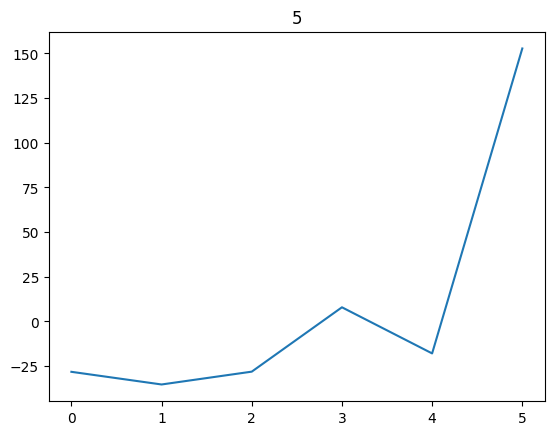

In [437]:
feature_dict = {}
for name in feature_name:
    feature_dict[name] = 0

# 不想过滤的状况，反而被过滤了, 想输出0
feature_dict['waittime'] = 1
feature_dict['nearby_total_driver_num'] = 1
feature_dict['nearby_idle_driver_num'] = 1
feature_dict['nearby_grid_order_num'] = 0.1
feature_dict['nearby_total_order_num'] = 0.1

getQ(agent, np.array(list(feature_dict.values())))